In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import nmrglue as ng
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 500

In [2]:
torch.__version__

'2.2.1'

In [3]:
## Name model, and load and preprocess dataset

In [4]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = "DAE_21Met" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [ ]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400 = np.load('Dataset21_400MHz_Spec.npy')
spectra100 = np.load('Dataset21_100MHz_Spec.npy')
conc1 = np.load('Dataset21_Conc.npy')

# Load validation dataset
spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
spectraVal100 = np.load('Dataset21_100MHz_Val_Spec.npy')
spectraValConc = np.load('Dataset21_Val_Conc.npy')

# Load representative validation spectra
RepSpectra400 = np.load("Dataset21_400MHz_RepresentativeExamples_Spectra.npy")
RepSpectra100 = np.load("Dataset21_100MHz_RepresentativeExamples_Spectra.npy")
RepConc = np.load("Dataset21_RepresentativeExamples_Concentrations.npy")
RepSpecNames = np.load("Dataset21_RepresentativeExamples_VariableNames.npy")

In [5]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [6]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra100, spectra400, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)


# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 128, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 128, shuffle=True)

In [7]:
del X_train
del X_test
del y_train
del y_test
del spectraVal100
del spectraVal400

In [6]:
class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(46000, 2000),
            nn.ReLU(True),
            nn.Linear(2000, 200),
            nn.ReLU(True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(200, 2000),
            nn.ReLU(True),
            nn.Linear(2000, 46000),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
from torch.cuda.amp import GradScaler, autocast

def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 25  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        # For timing cell run time
        start = time.time()
        model.train()
        train_loss = 0.0
        
        
         # Instantiate the GradScaler
        scaler = GradScaler()
        for inputs, labels in train_loader:
            # Move data to GPU
             inputs, labels = inputs.to(device), labels.to(device)
             # Zero the parameter gradients
             optimizer.zero_grad()
            # Enable autocasting for forward and backward passes
             with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
             train_loss += loss.item() * inputs.size(0)
             # Scale the loss and perform backpropagation
             scaler.scale(loss).backward()
             # Step the optimizer
             scaler.step(optimizer)
              # Update the scaler
             scaler.update()
        train_losses.append(train_loss)

        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                # Enable autocasting for forward passes
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        end = time.time()
        print("Epoch time: ",end-start)


    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [11]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model = DAE()

# Move the model to the GPU device
model.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params2.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/500], Train Loss: 3.4470, Test Loss: 0.6310
Epoch time:  18.641955137252808
Epoch [2/500], Train Loss: 2.5375, Test Loss: 0.6319
Epoch time:  7.293989658355713
Epoch [3/500], Train Loss: 2.5373, Test Loss: 0.6312
Epoch time:  6.964309930801392
Epoch [4/500], Train Loss: 2.5367, Test Loss: 0.6313
Epoch time:  7.2951977252960205
Epoch [5/500], Train Loss: 2.5365, Test Loss: 0.6307
Epoch time:  18.353596687316895
Epoch [6/500], Train Loss: 2.5352, Test Loss: 0.6314
Epoch time:  7.297099828720093
Epoch [7/500], Train Loss: 2.5346, Test Loss: 0.6318
Epoch time:  6.961703062057495
Epoch [8/500], Train Loss: 2.5345, Test Loss: 0.6314
Epoch time:  7.295884370803833
Epoch [9/500], Train Loss: 2.5341, Test Loss: 0.6302
Epoch time:  18.84347152709961
Epoch [10/500], Train Loss: 2.5329, Test Loss: 0.6304
Epoch time:  7.319947719573975
Epoch [11/500], Train Loss: 2.5335, Test Loss: 0.6302
Epoch time:  6.918905258178711
Epoch [12/500], Train

Epoch [97/500], Train Loss: 2.5309, Test Loss: 0.6298
Epoch time:  7.006371736526489
Epoch [98/500], Train Loss: 2.5303, Test Loss: 0.6296
Epoch time:  7.328124523162842
Epoch [99/500], Train Loss: 2.5303, Test Loss: 0.6297
Epoch time:  6.987905263900757
Epoch [100/500], Train Loss: 2.5302, Test Loss: 0.6297
Epoch time:  7.325459718704224
Epoch [101/500], Train Loss: 2.5303, Test Loss: 0.6295
Epoch time:  7.016491174697876
Epoch [102/500], Train Loss: 2.5305, Test Loss: 0.6297
Epoch time:  7.329280138015747
Epoch [103/500], Train Loss: 2.5304, Test Loss: 0.6296
Epoch time:  7.019434213638306
Epoch [104/500], Train Loss: 2.5304, Test Loss: 0.6297
Epoch time:  7.2830541133880615
Epoch [105/500], Train Loss: 2.5302, Test Loss: 0.6296
Early stopping at epoch 105
Execution time: 922.7609302997589 seconds


In [12]:
# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')
np.save(ModelName + "_TrainLoss.npy", train_losses)
np.save(ModelName + "_TestLoss.npy", test_losses)

In [7]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')


# Load validation dataset
spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
spectraVal100 = np.load('Dataset21_100MHz_Val_Spec.npy')


spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
spectraVal400 = torch.tensor(spectraVal400).float().to(device)


In [8]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params2.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model = DAE()

# Load the model's state dictionary from the loaded dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model.to(device)

DAE(
  (encoder): Sequential(
    (0): Linear(in_features=46000, out_features=2000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=2000, out_features=200, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=200, out_features=2000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=2000, out_features=46000, bias=True)
  )
)

In [10]:
## Switch to directory for saving model metrics
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics')

criterion = nn.MSELoss()
model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(spectraVal100[:100])  # Evaluate input spectra 

mse = criterion(outputs, spectraVal400[:100])


# Print RMSE
print('model err: ', mse)  # Print RMSE

# Save RMSE to a file
np.save(ModelName + "ValMSE.npy", mse.cpu().detach().numpy())

model err:  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


In [9]:
## Create ppm scale for plotting ppm rather than just data point numbers for x-axis
ppm_all = (np.linspace(12.5, -2.5, 65536))
ppm = ppm_all[10000:56000]

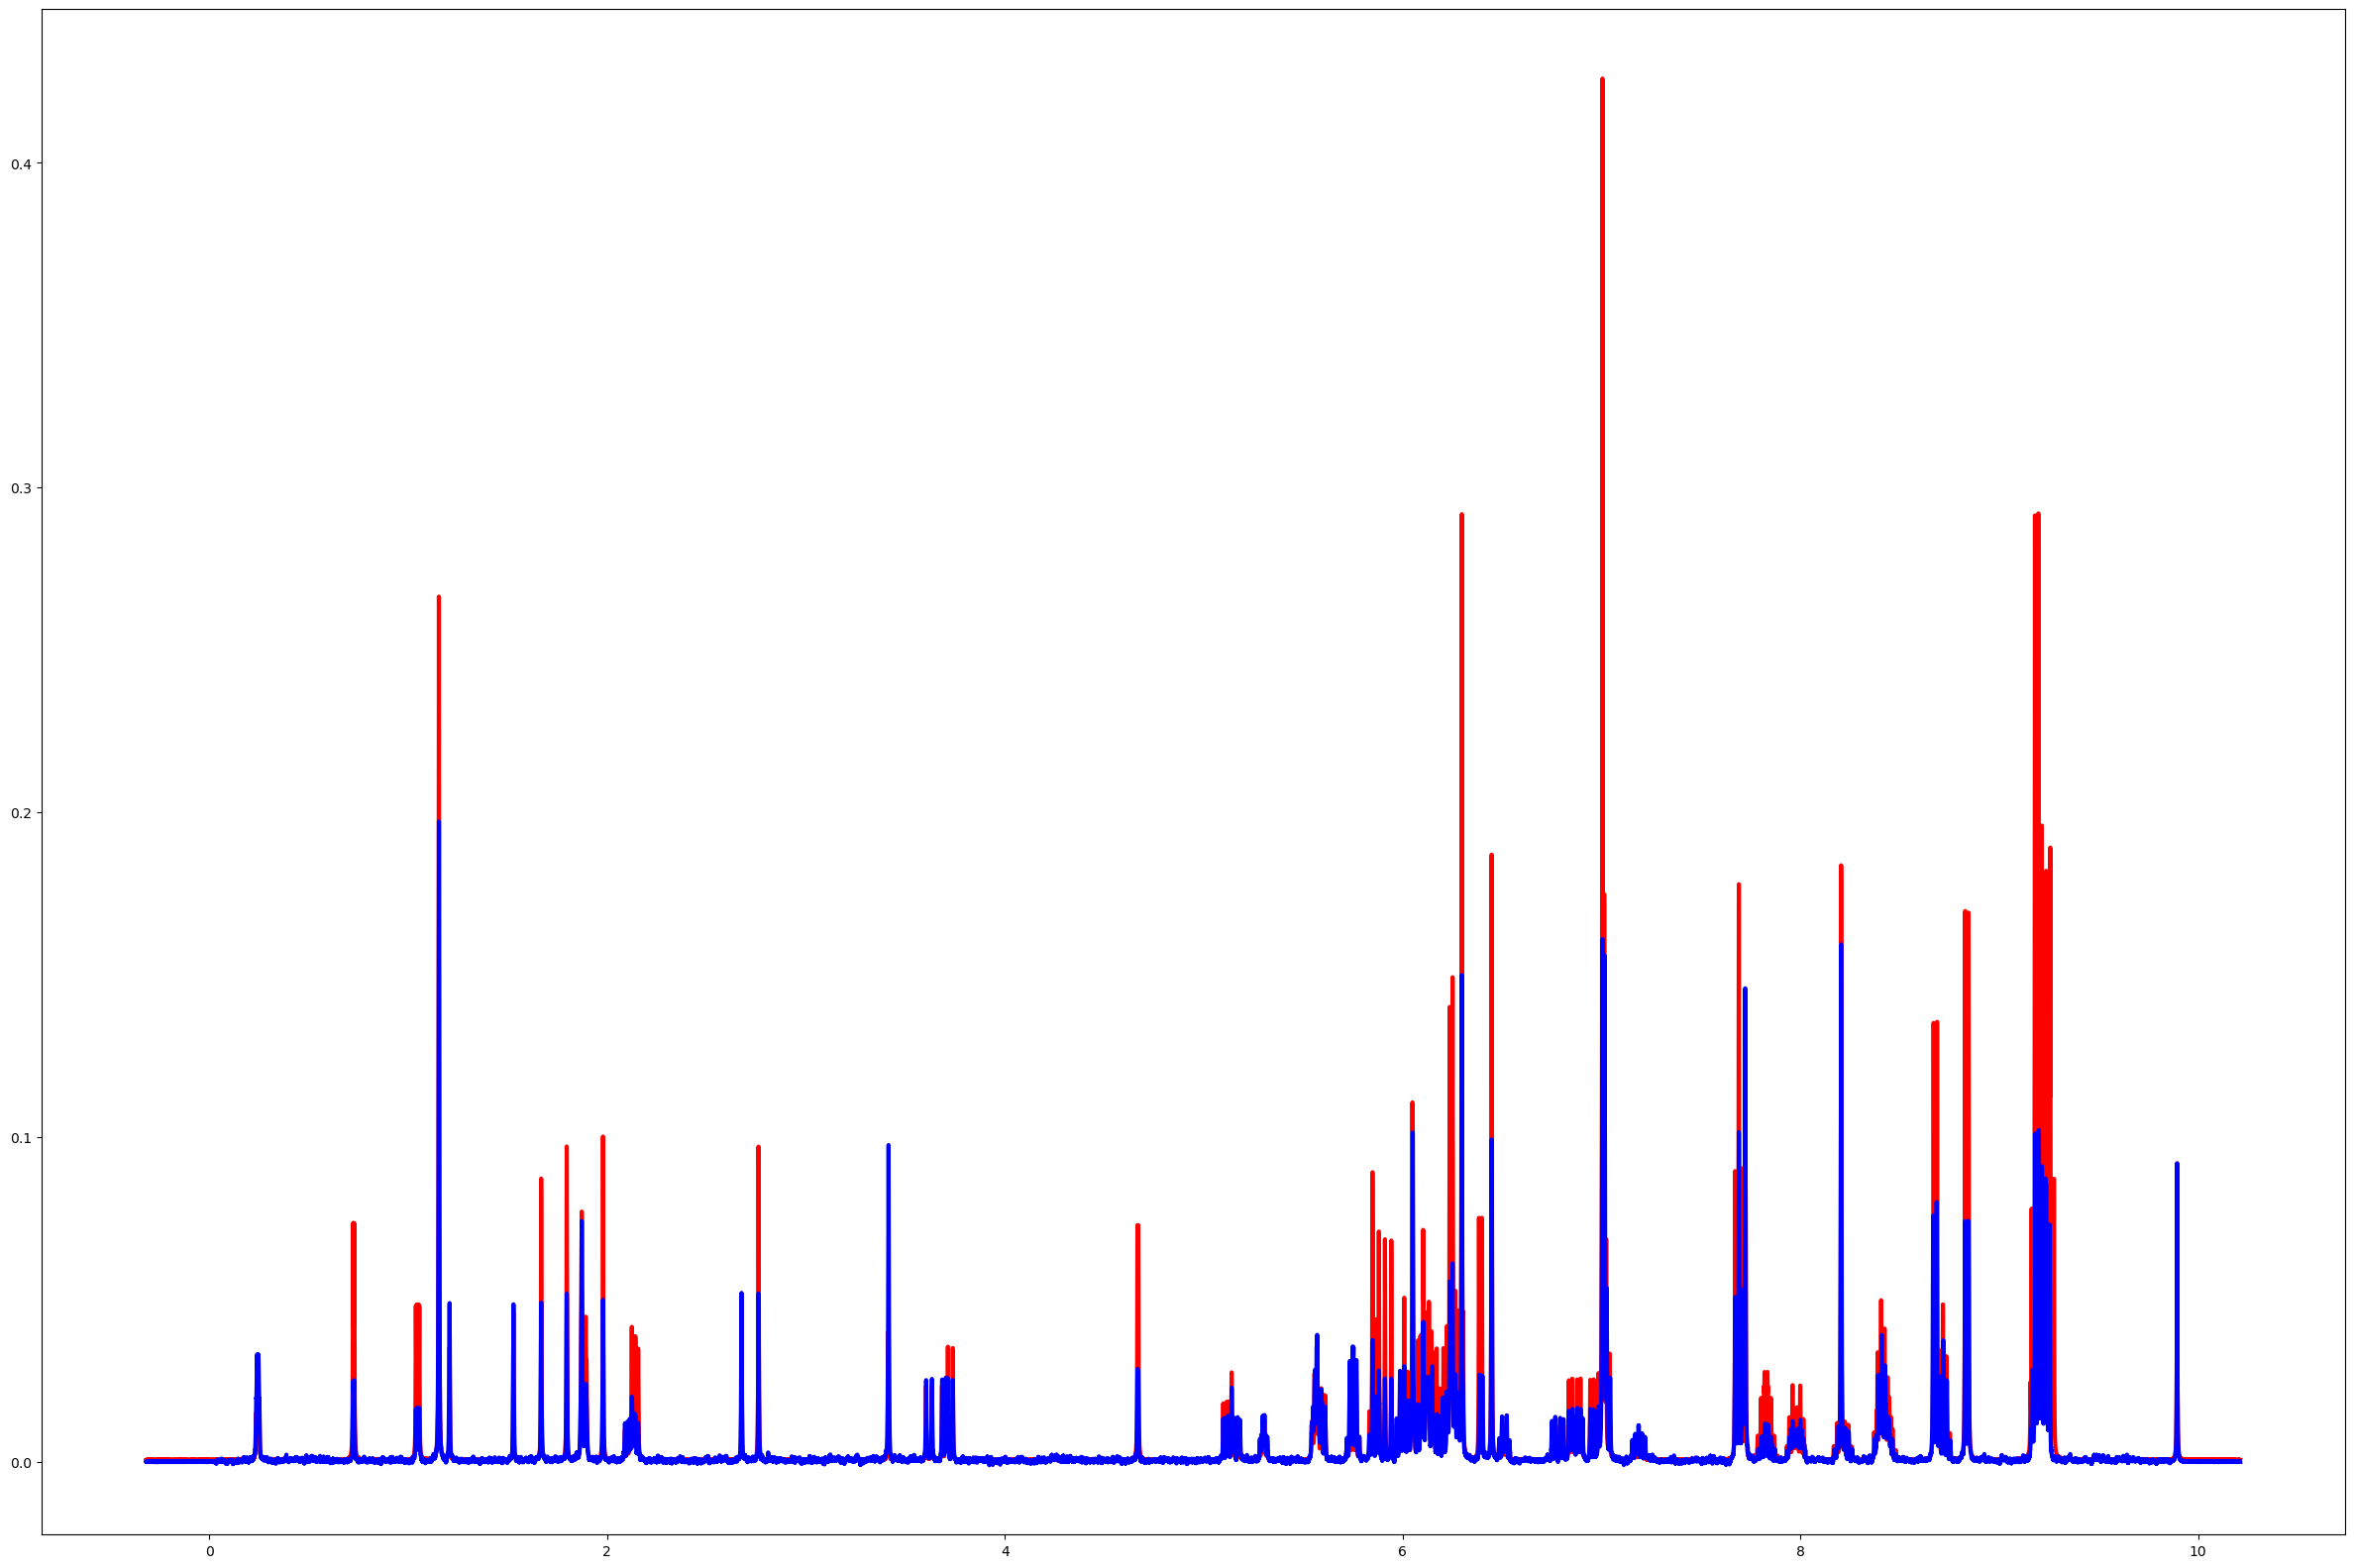

tensor(9.2757e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


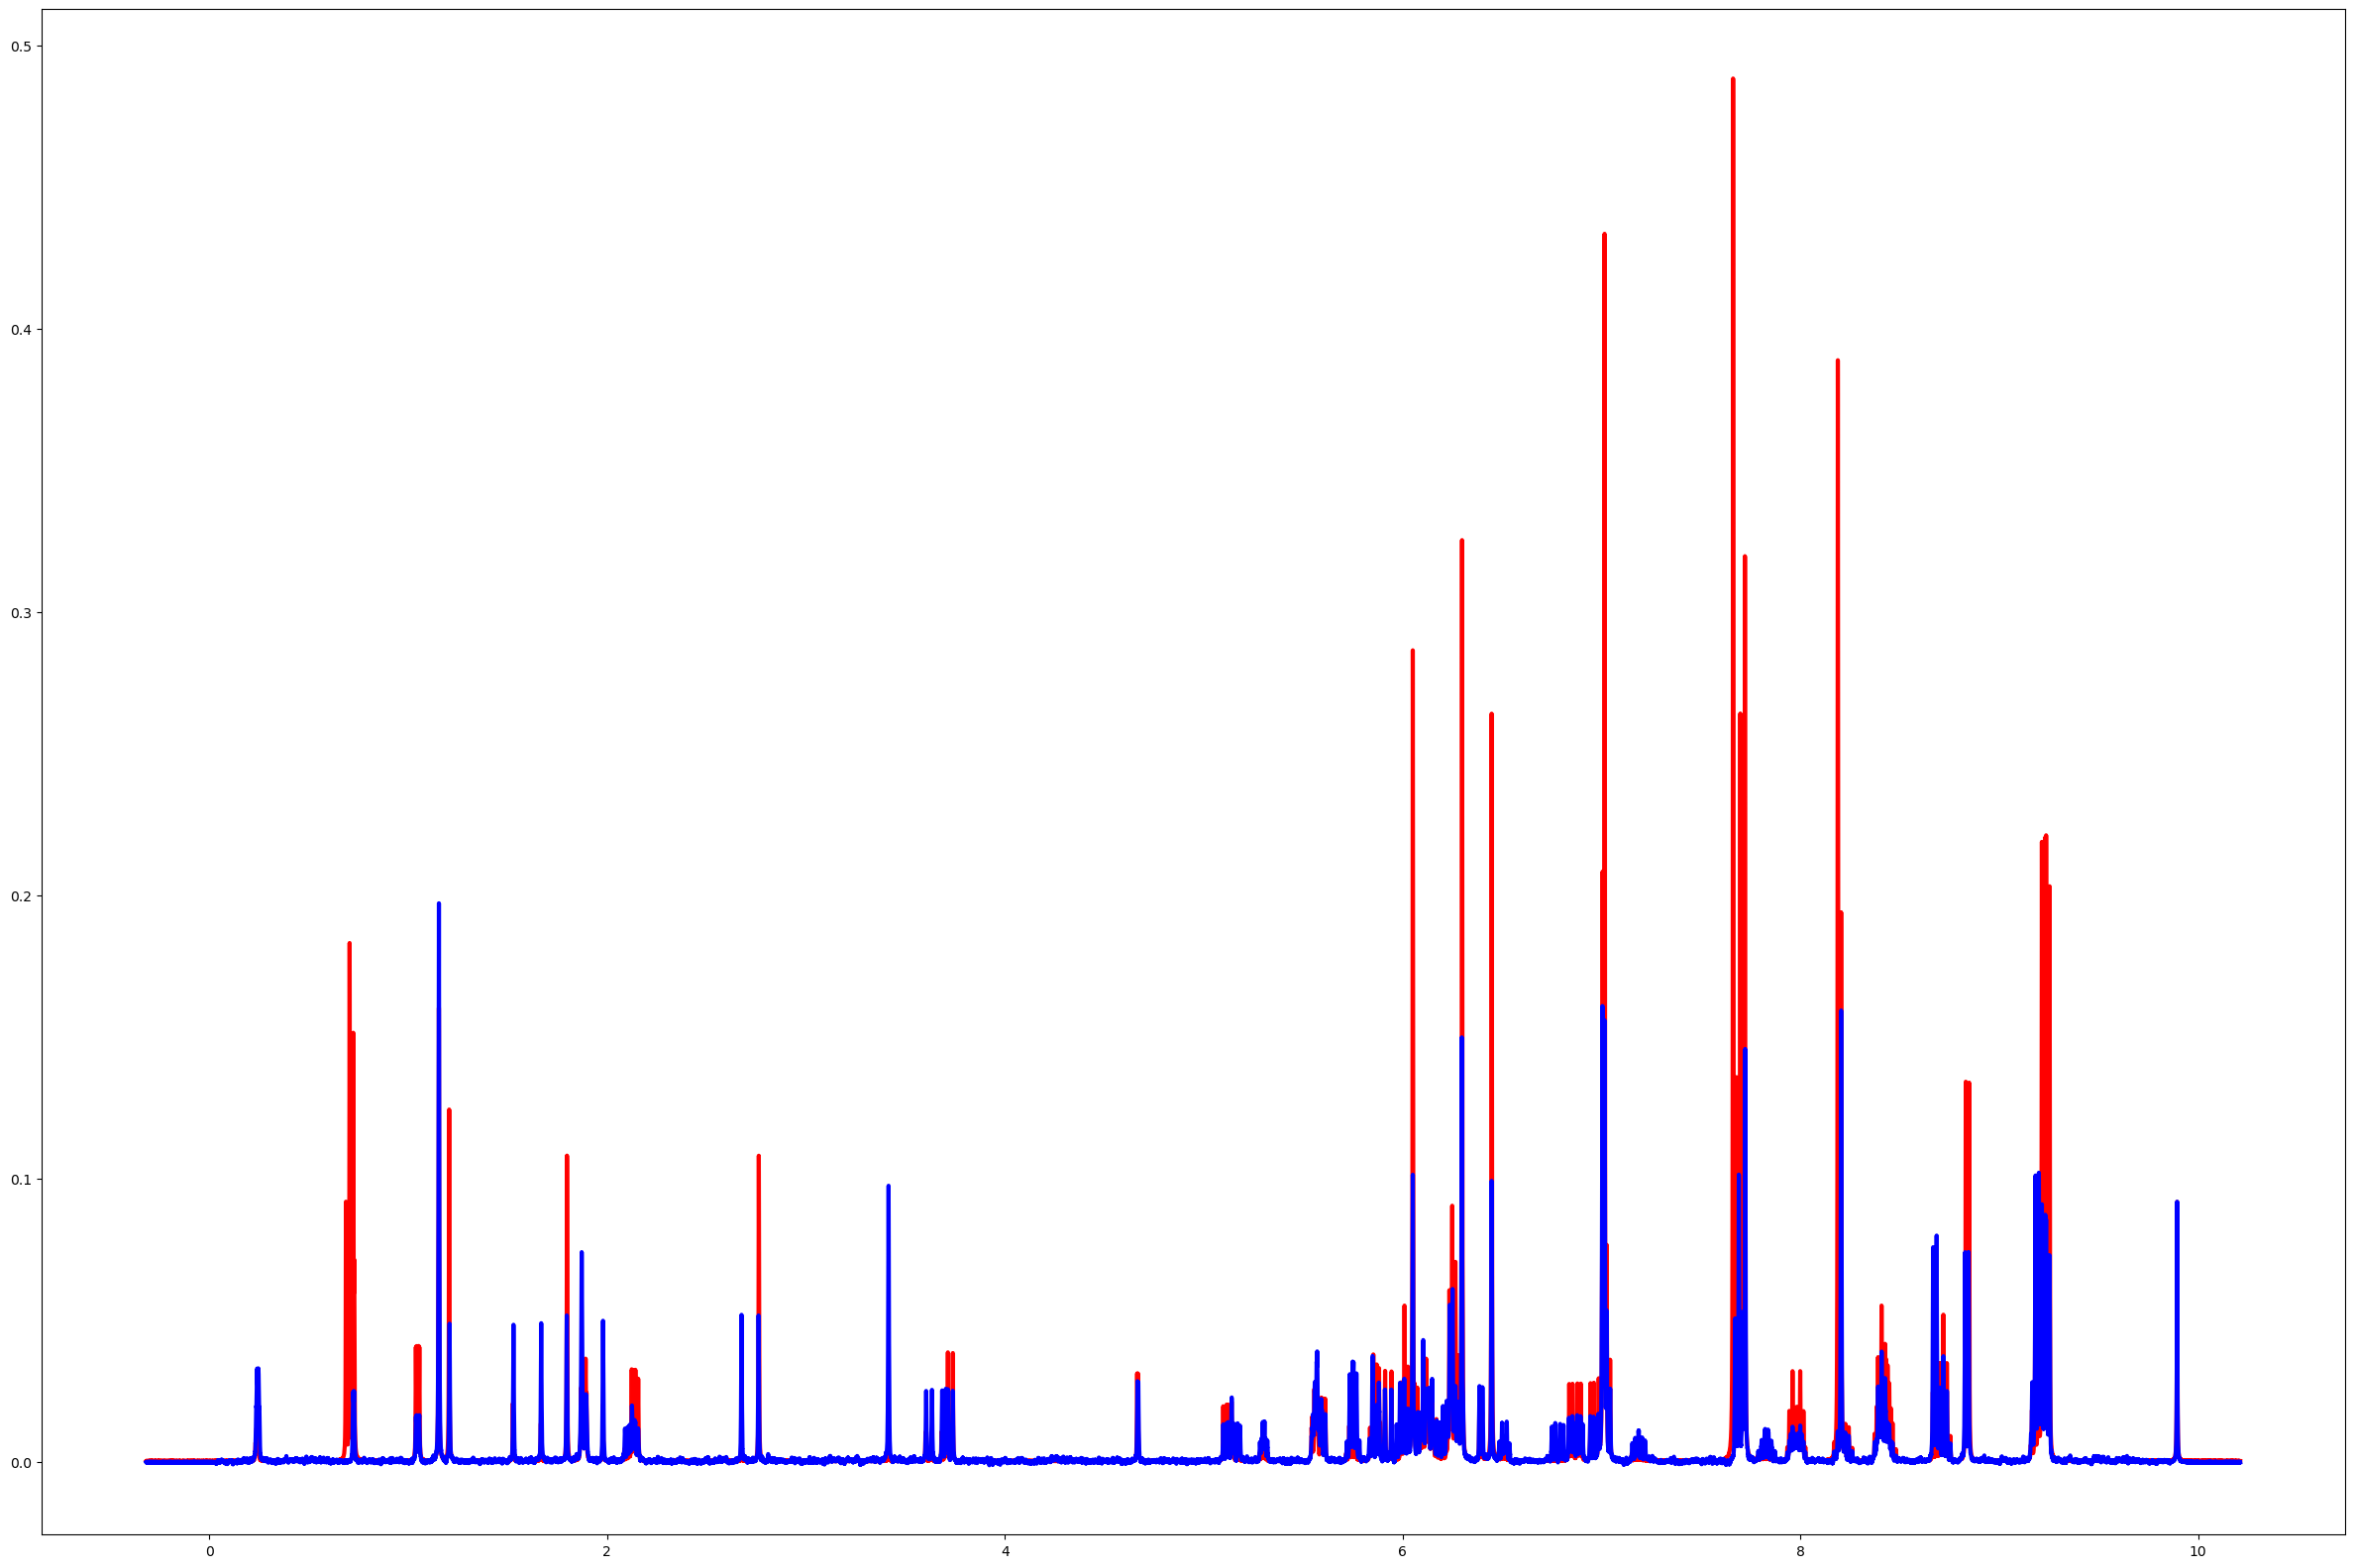

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


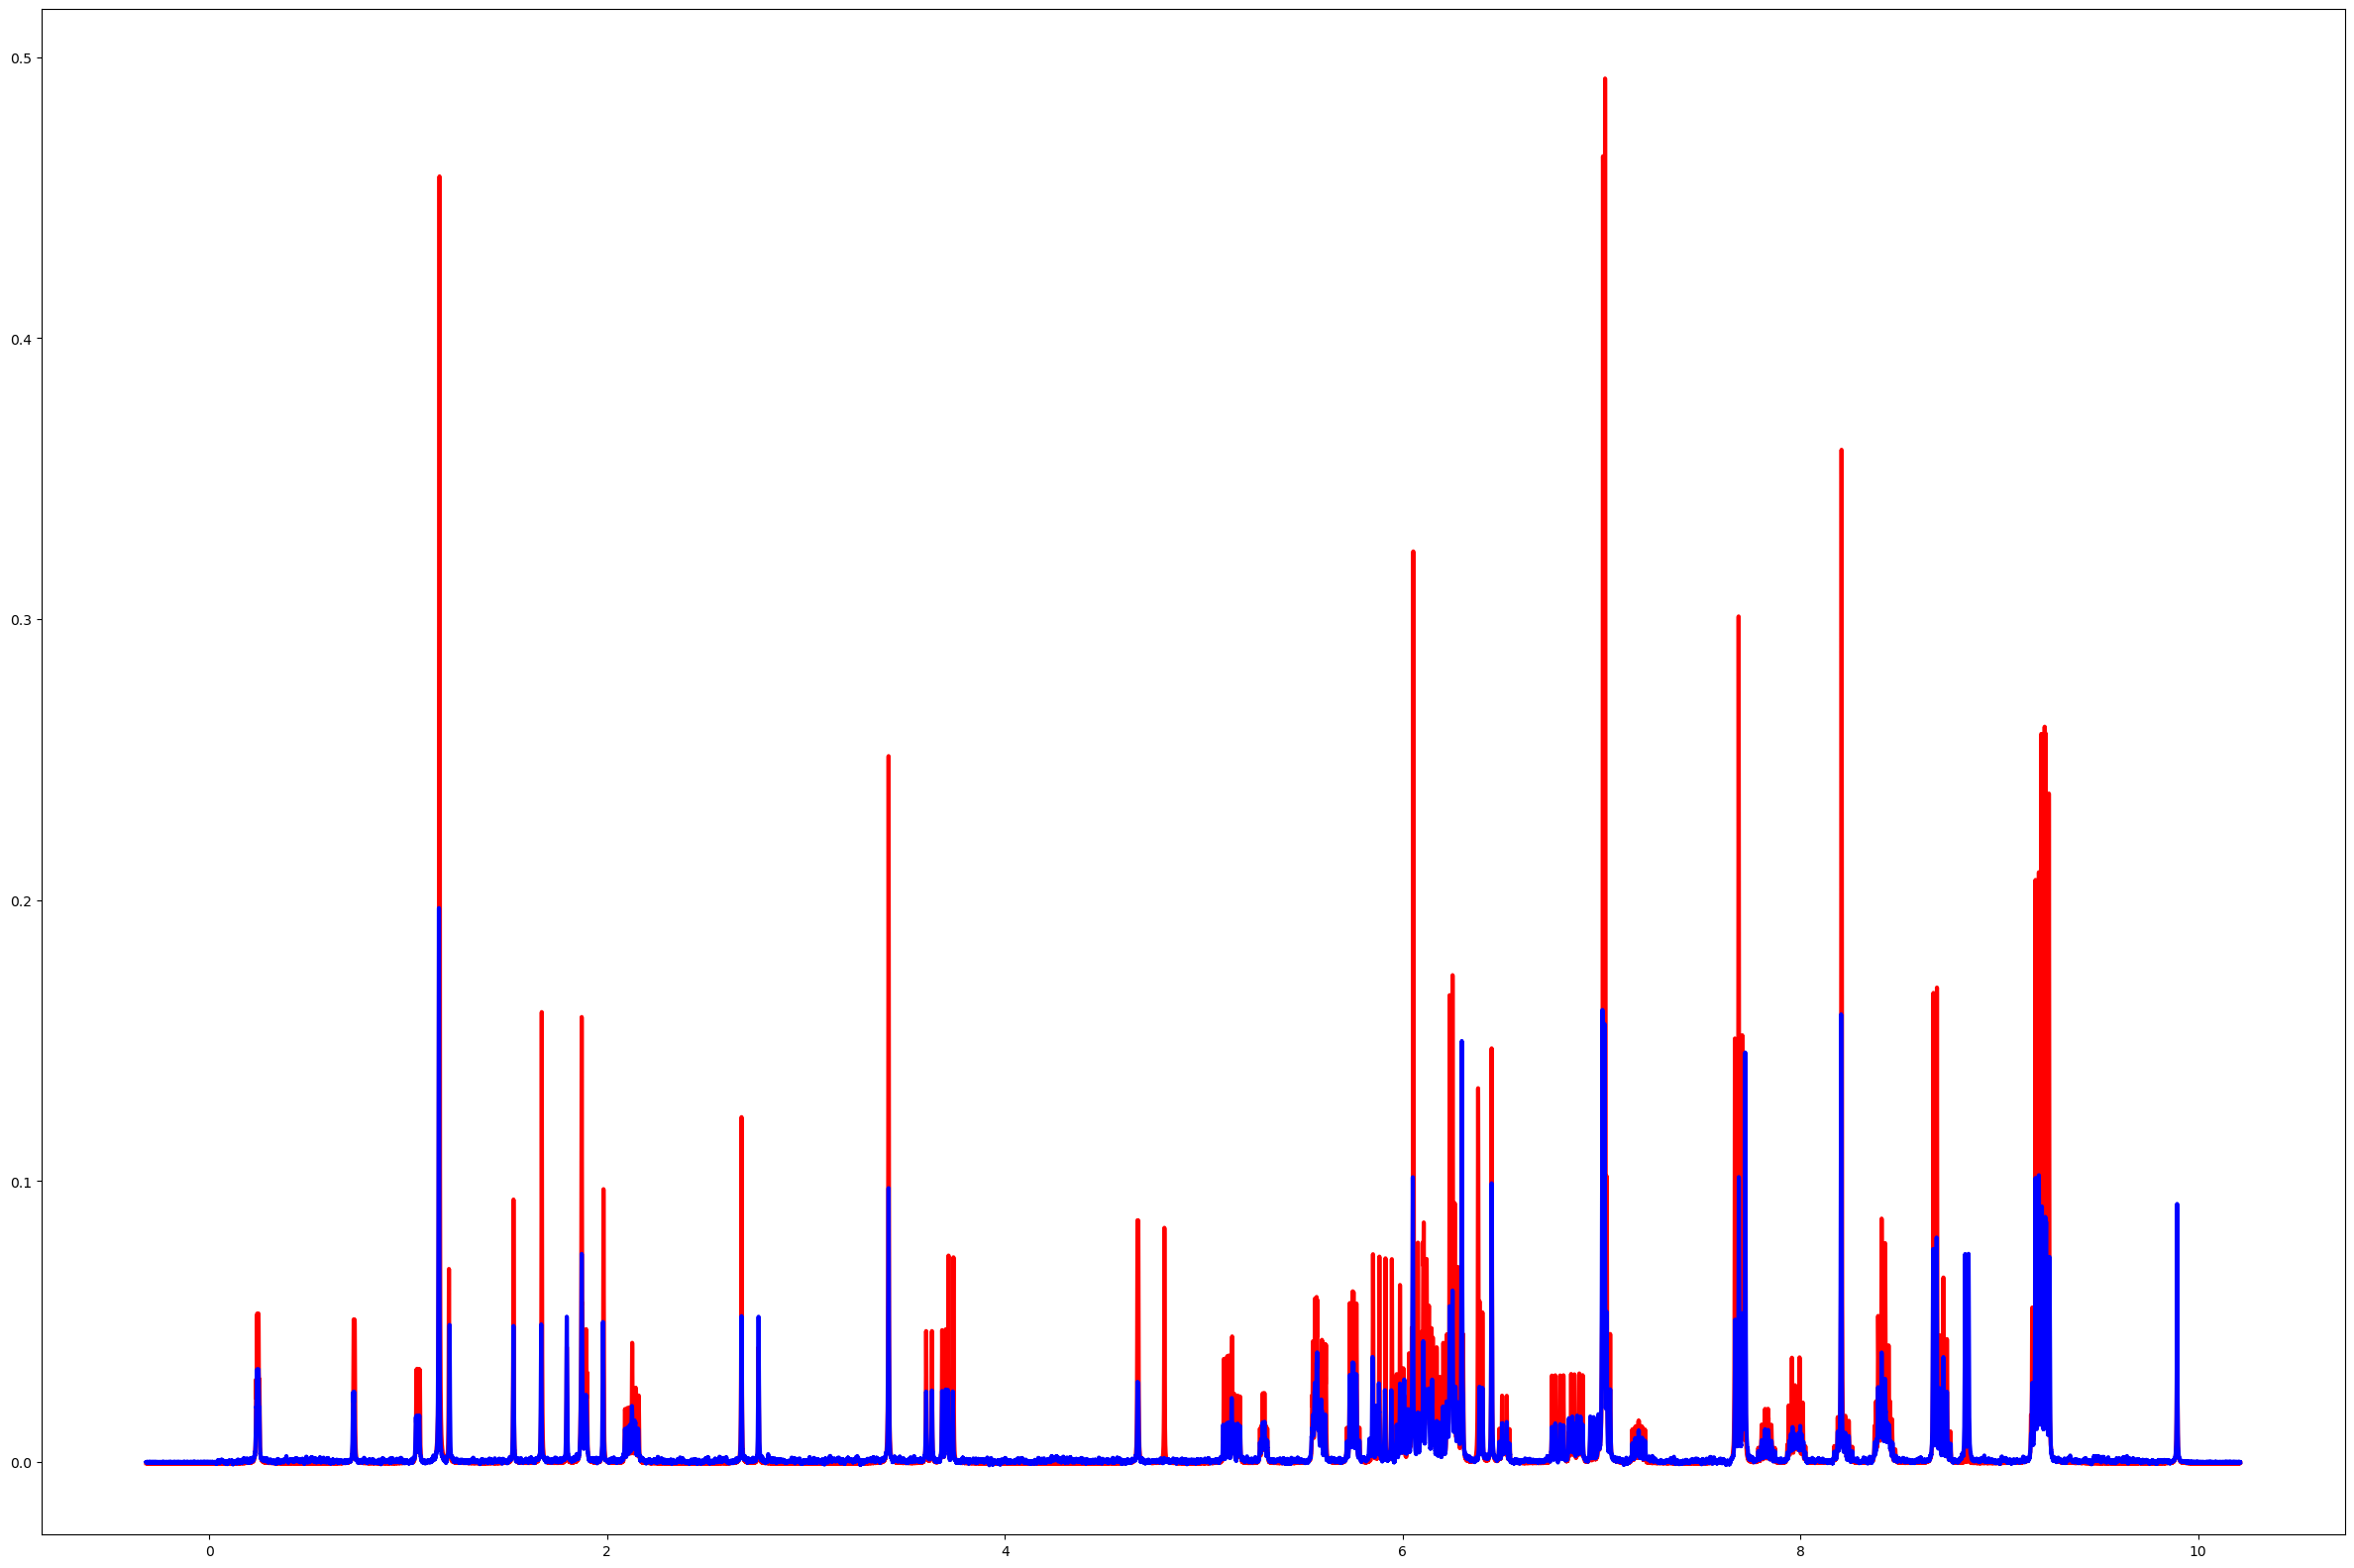

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


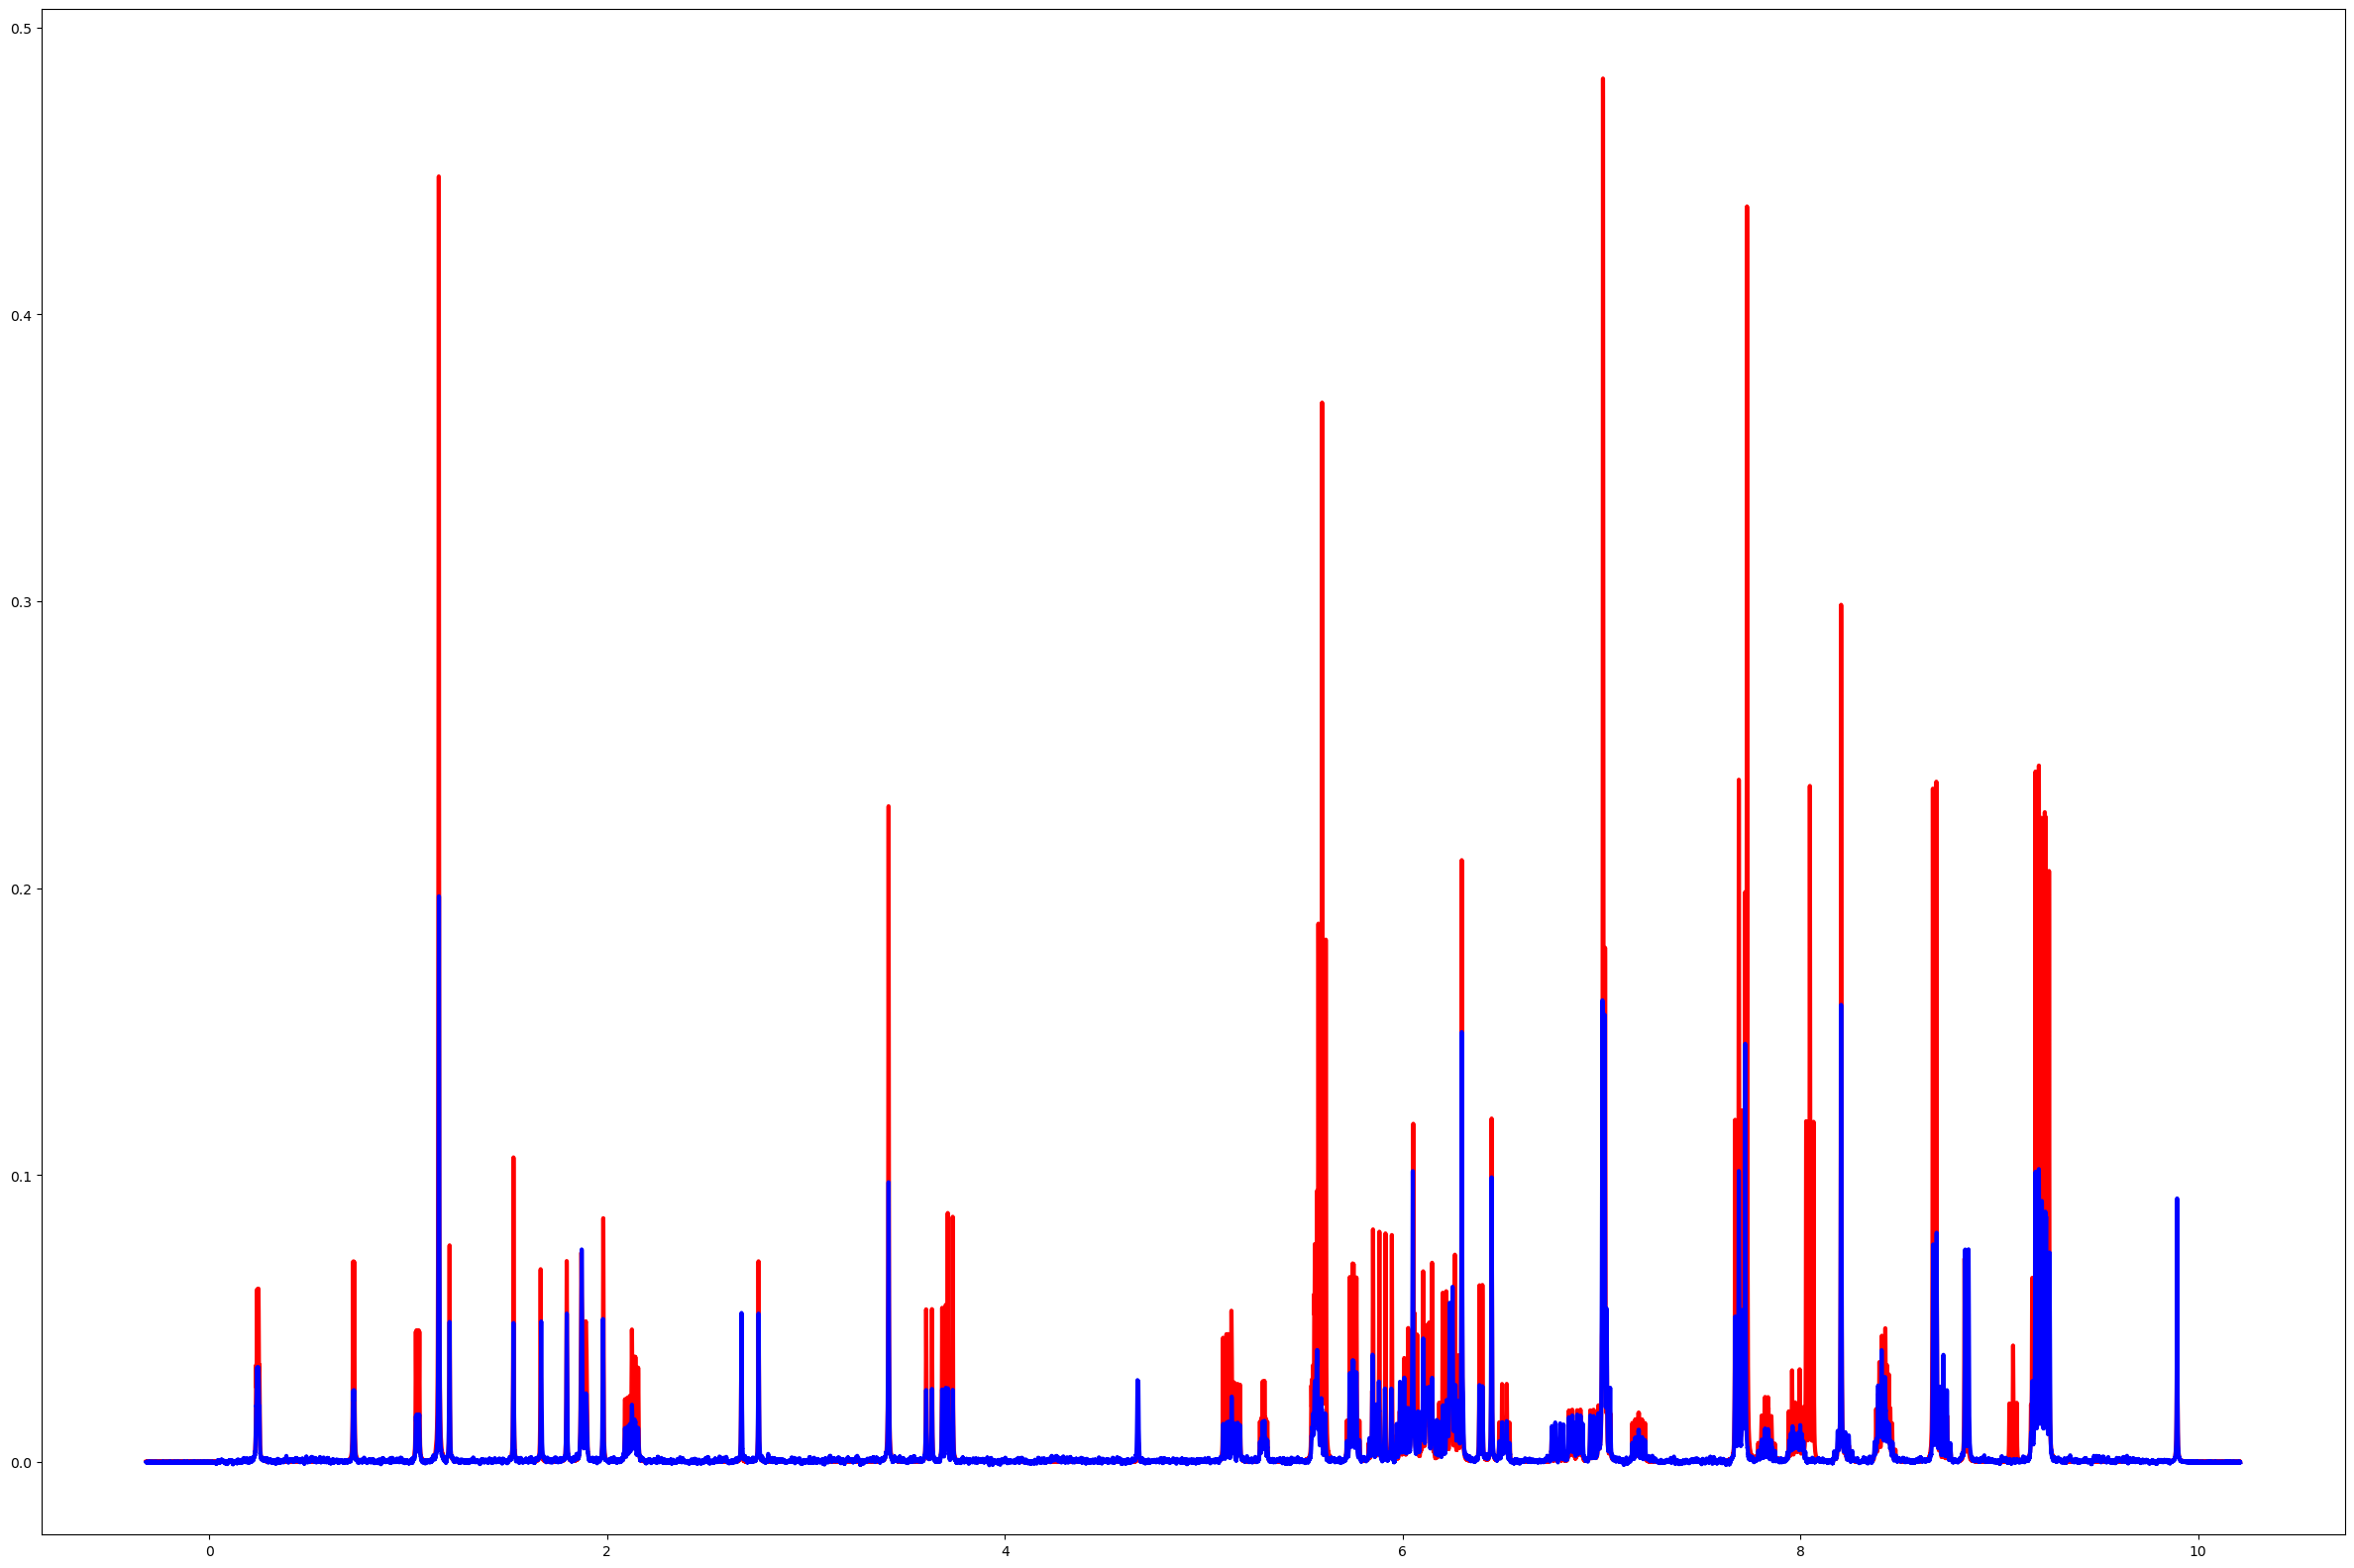

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


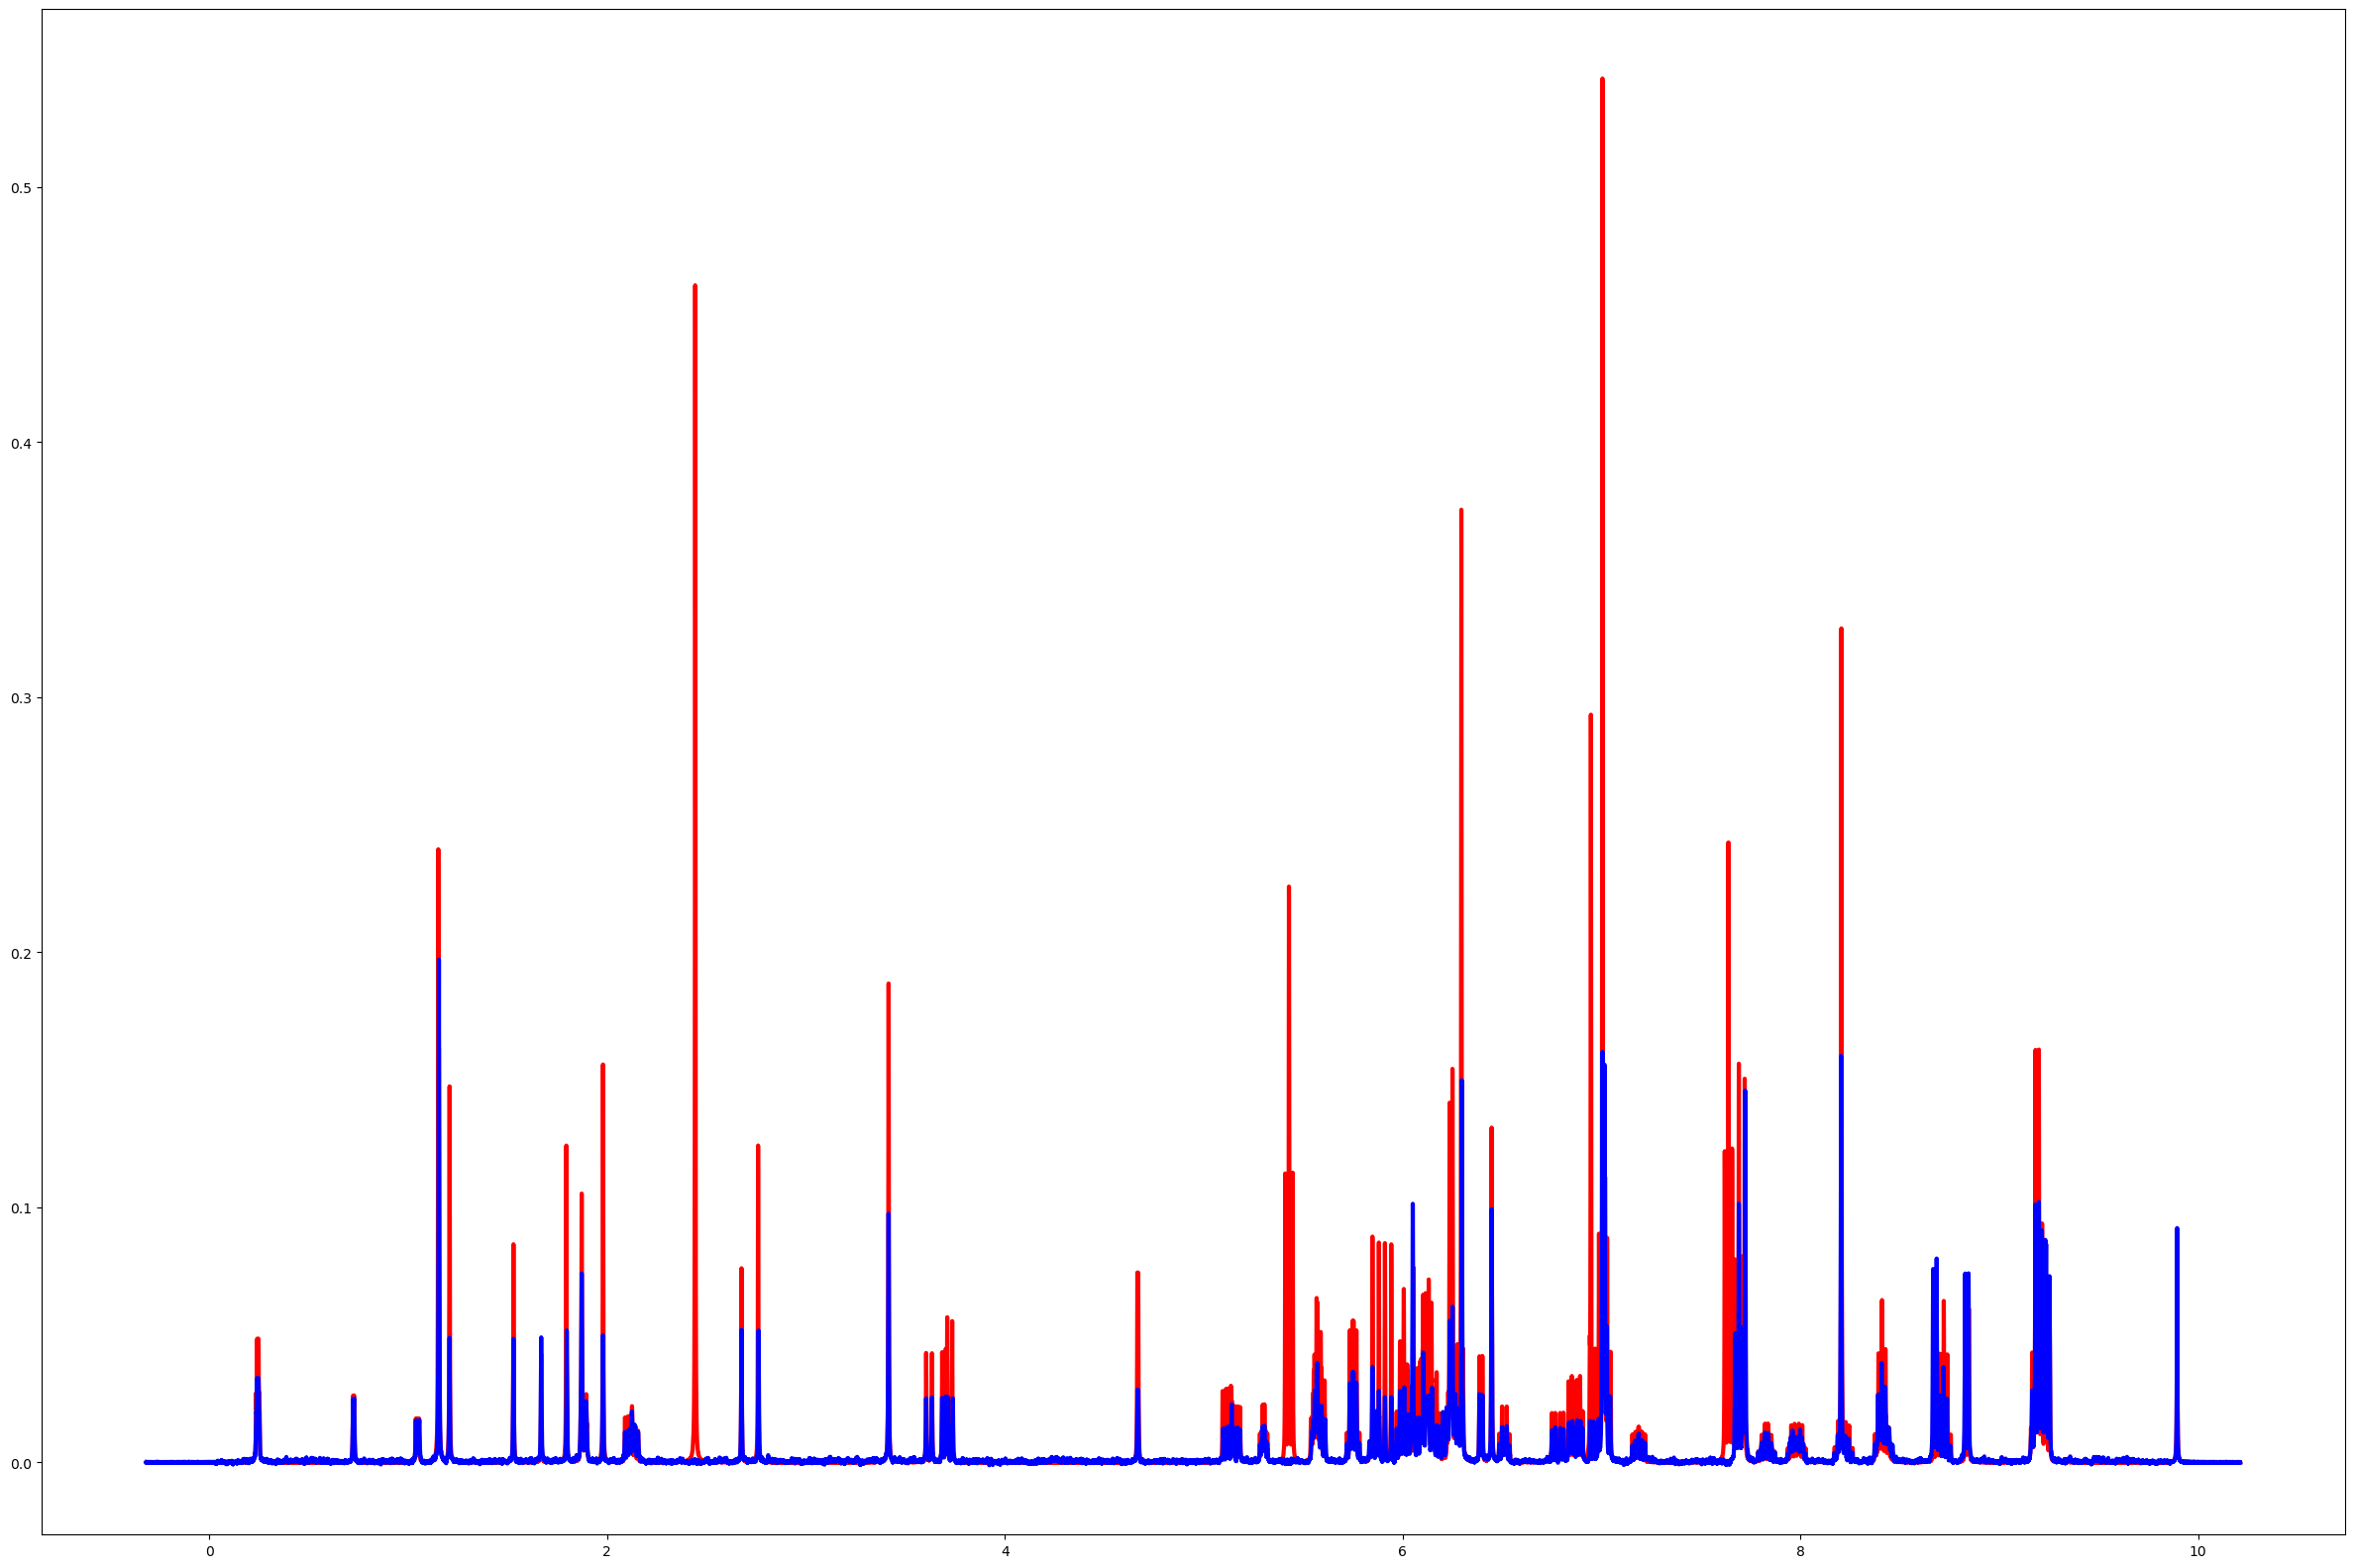

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


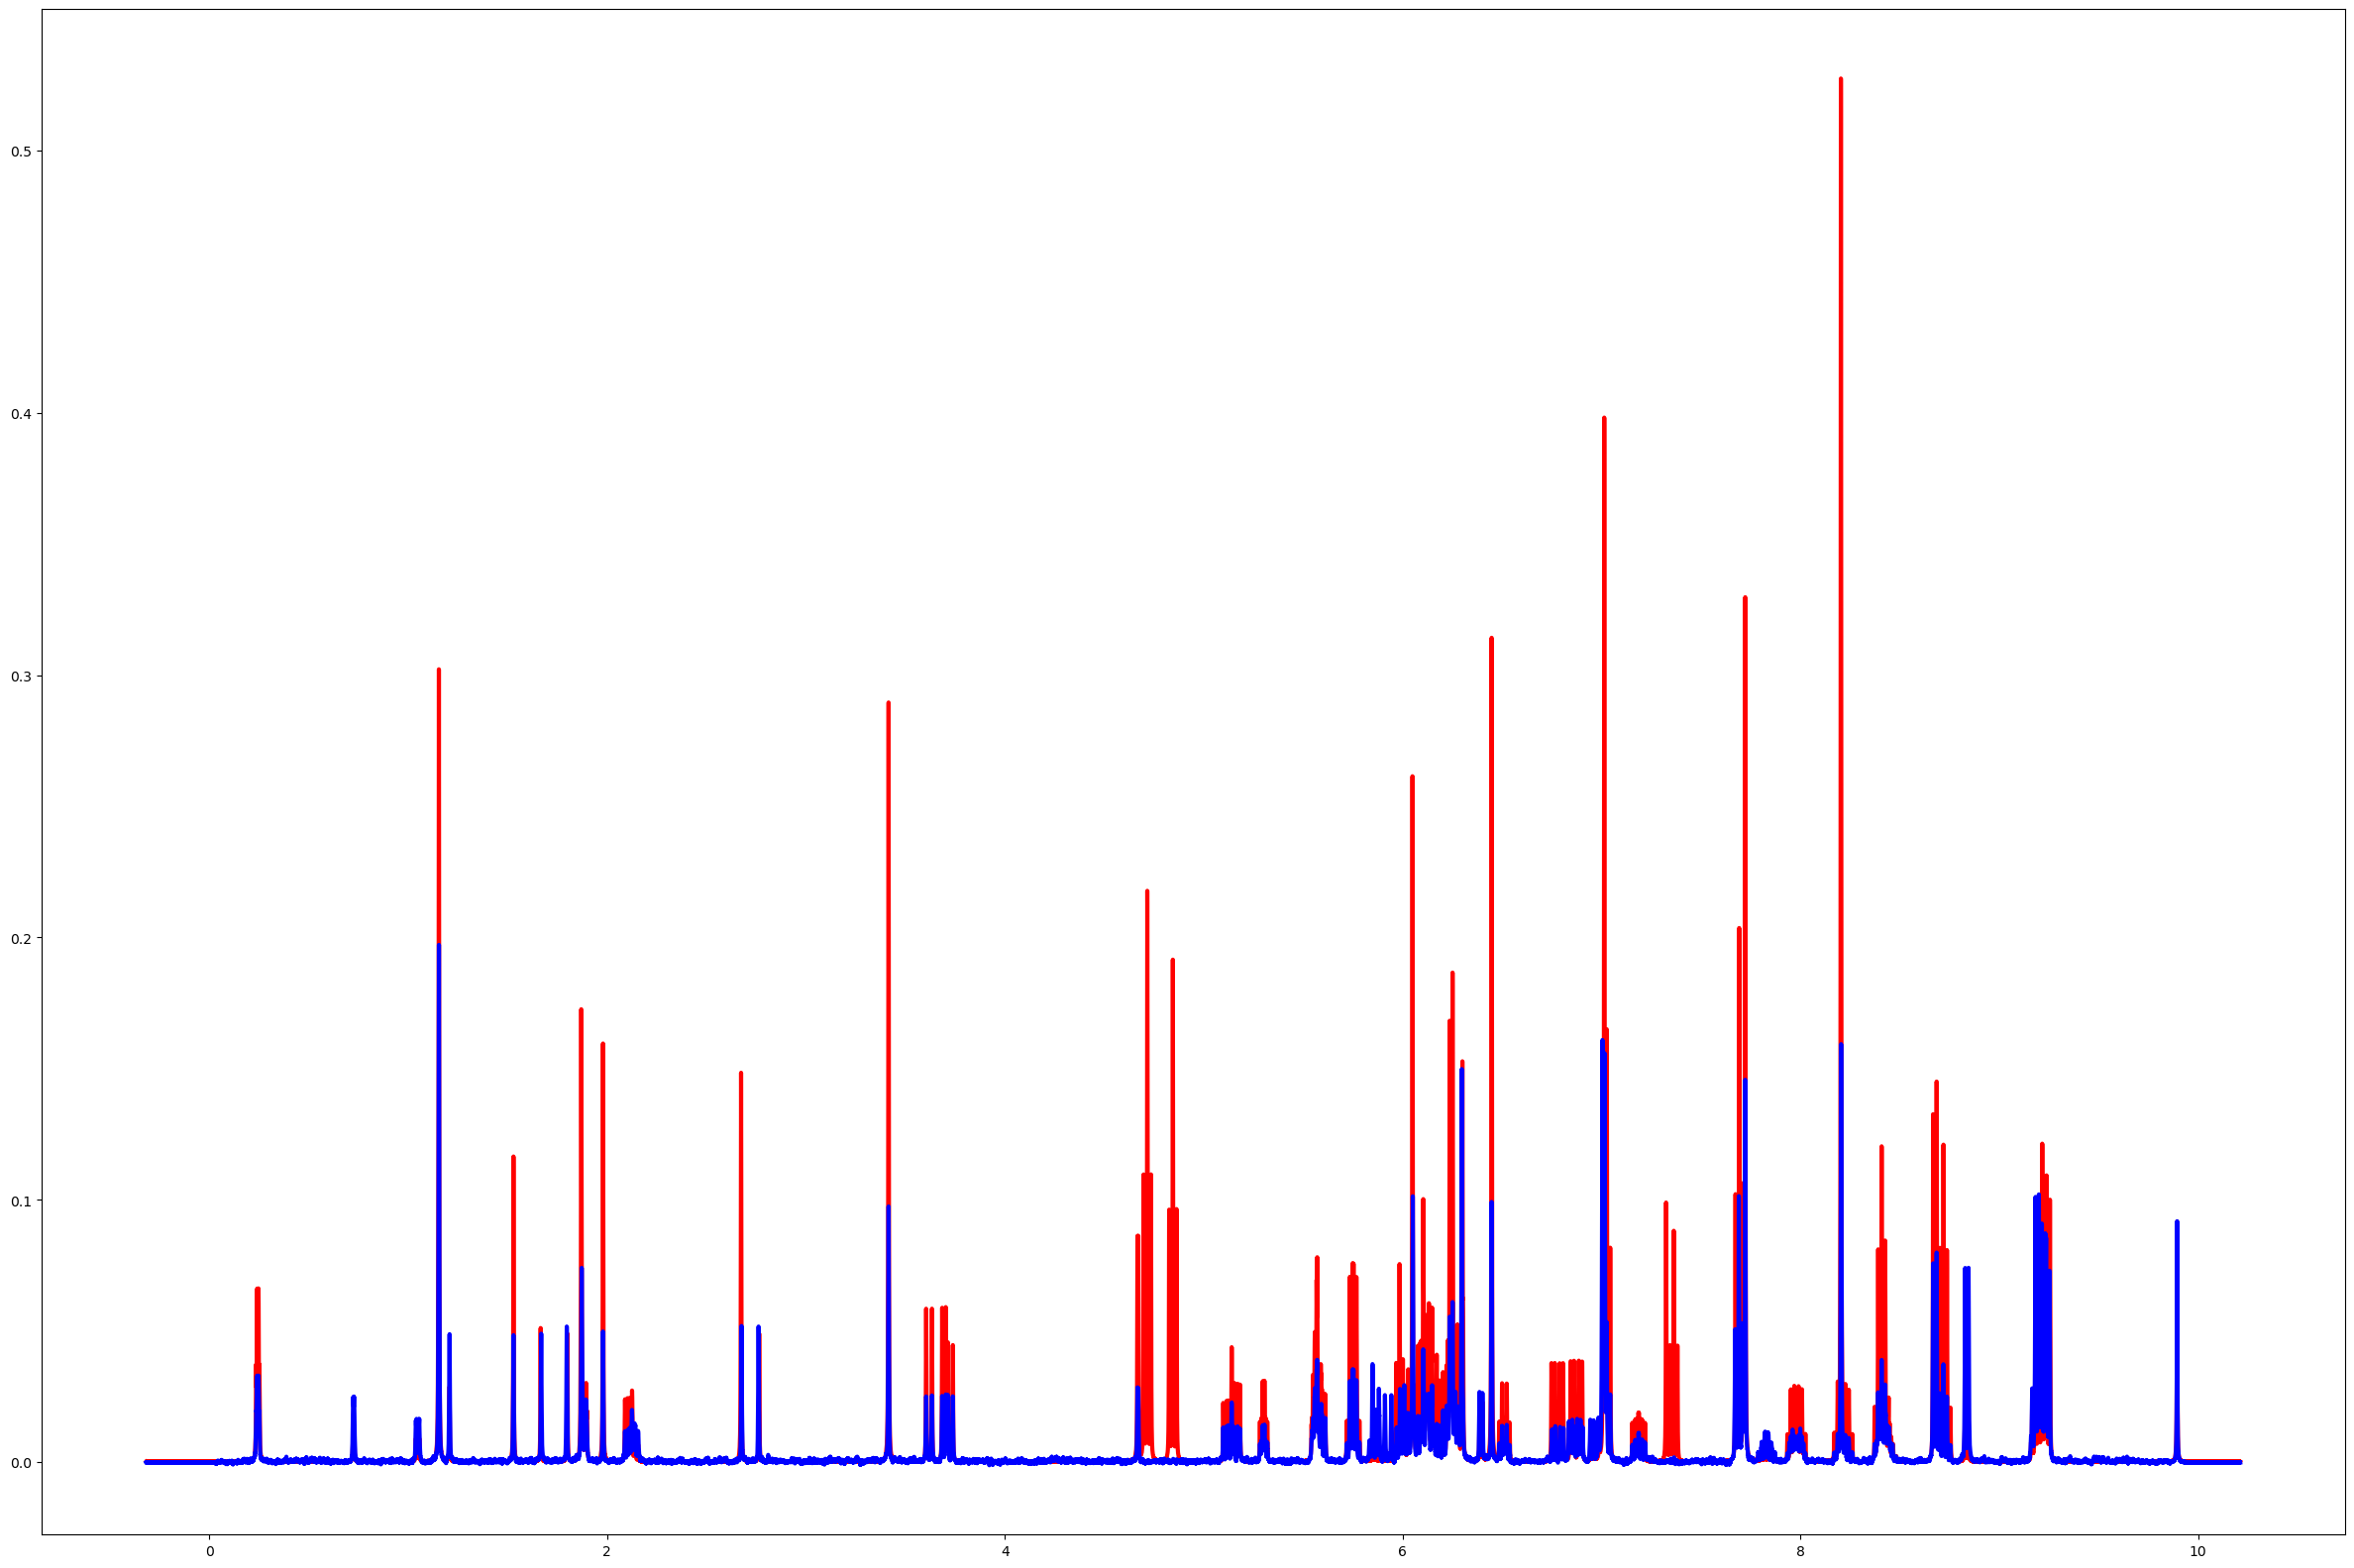

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


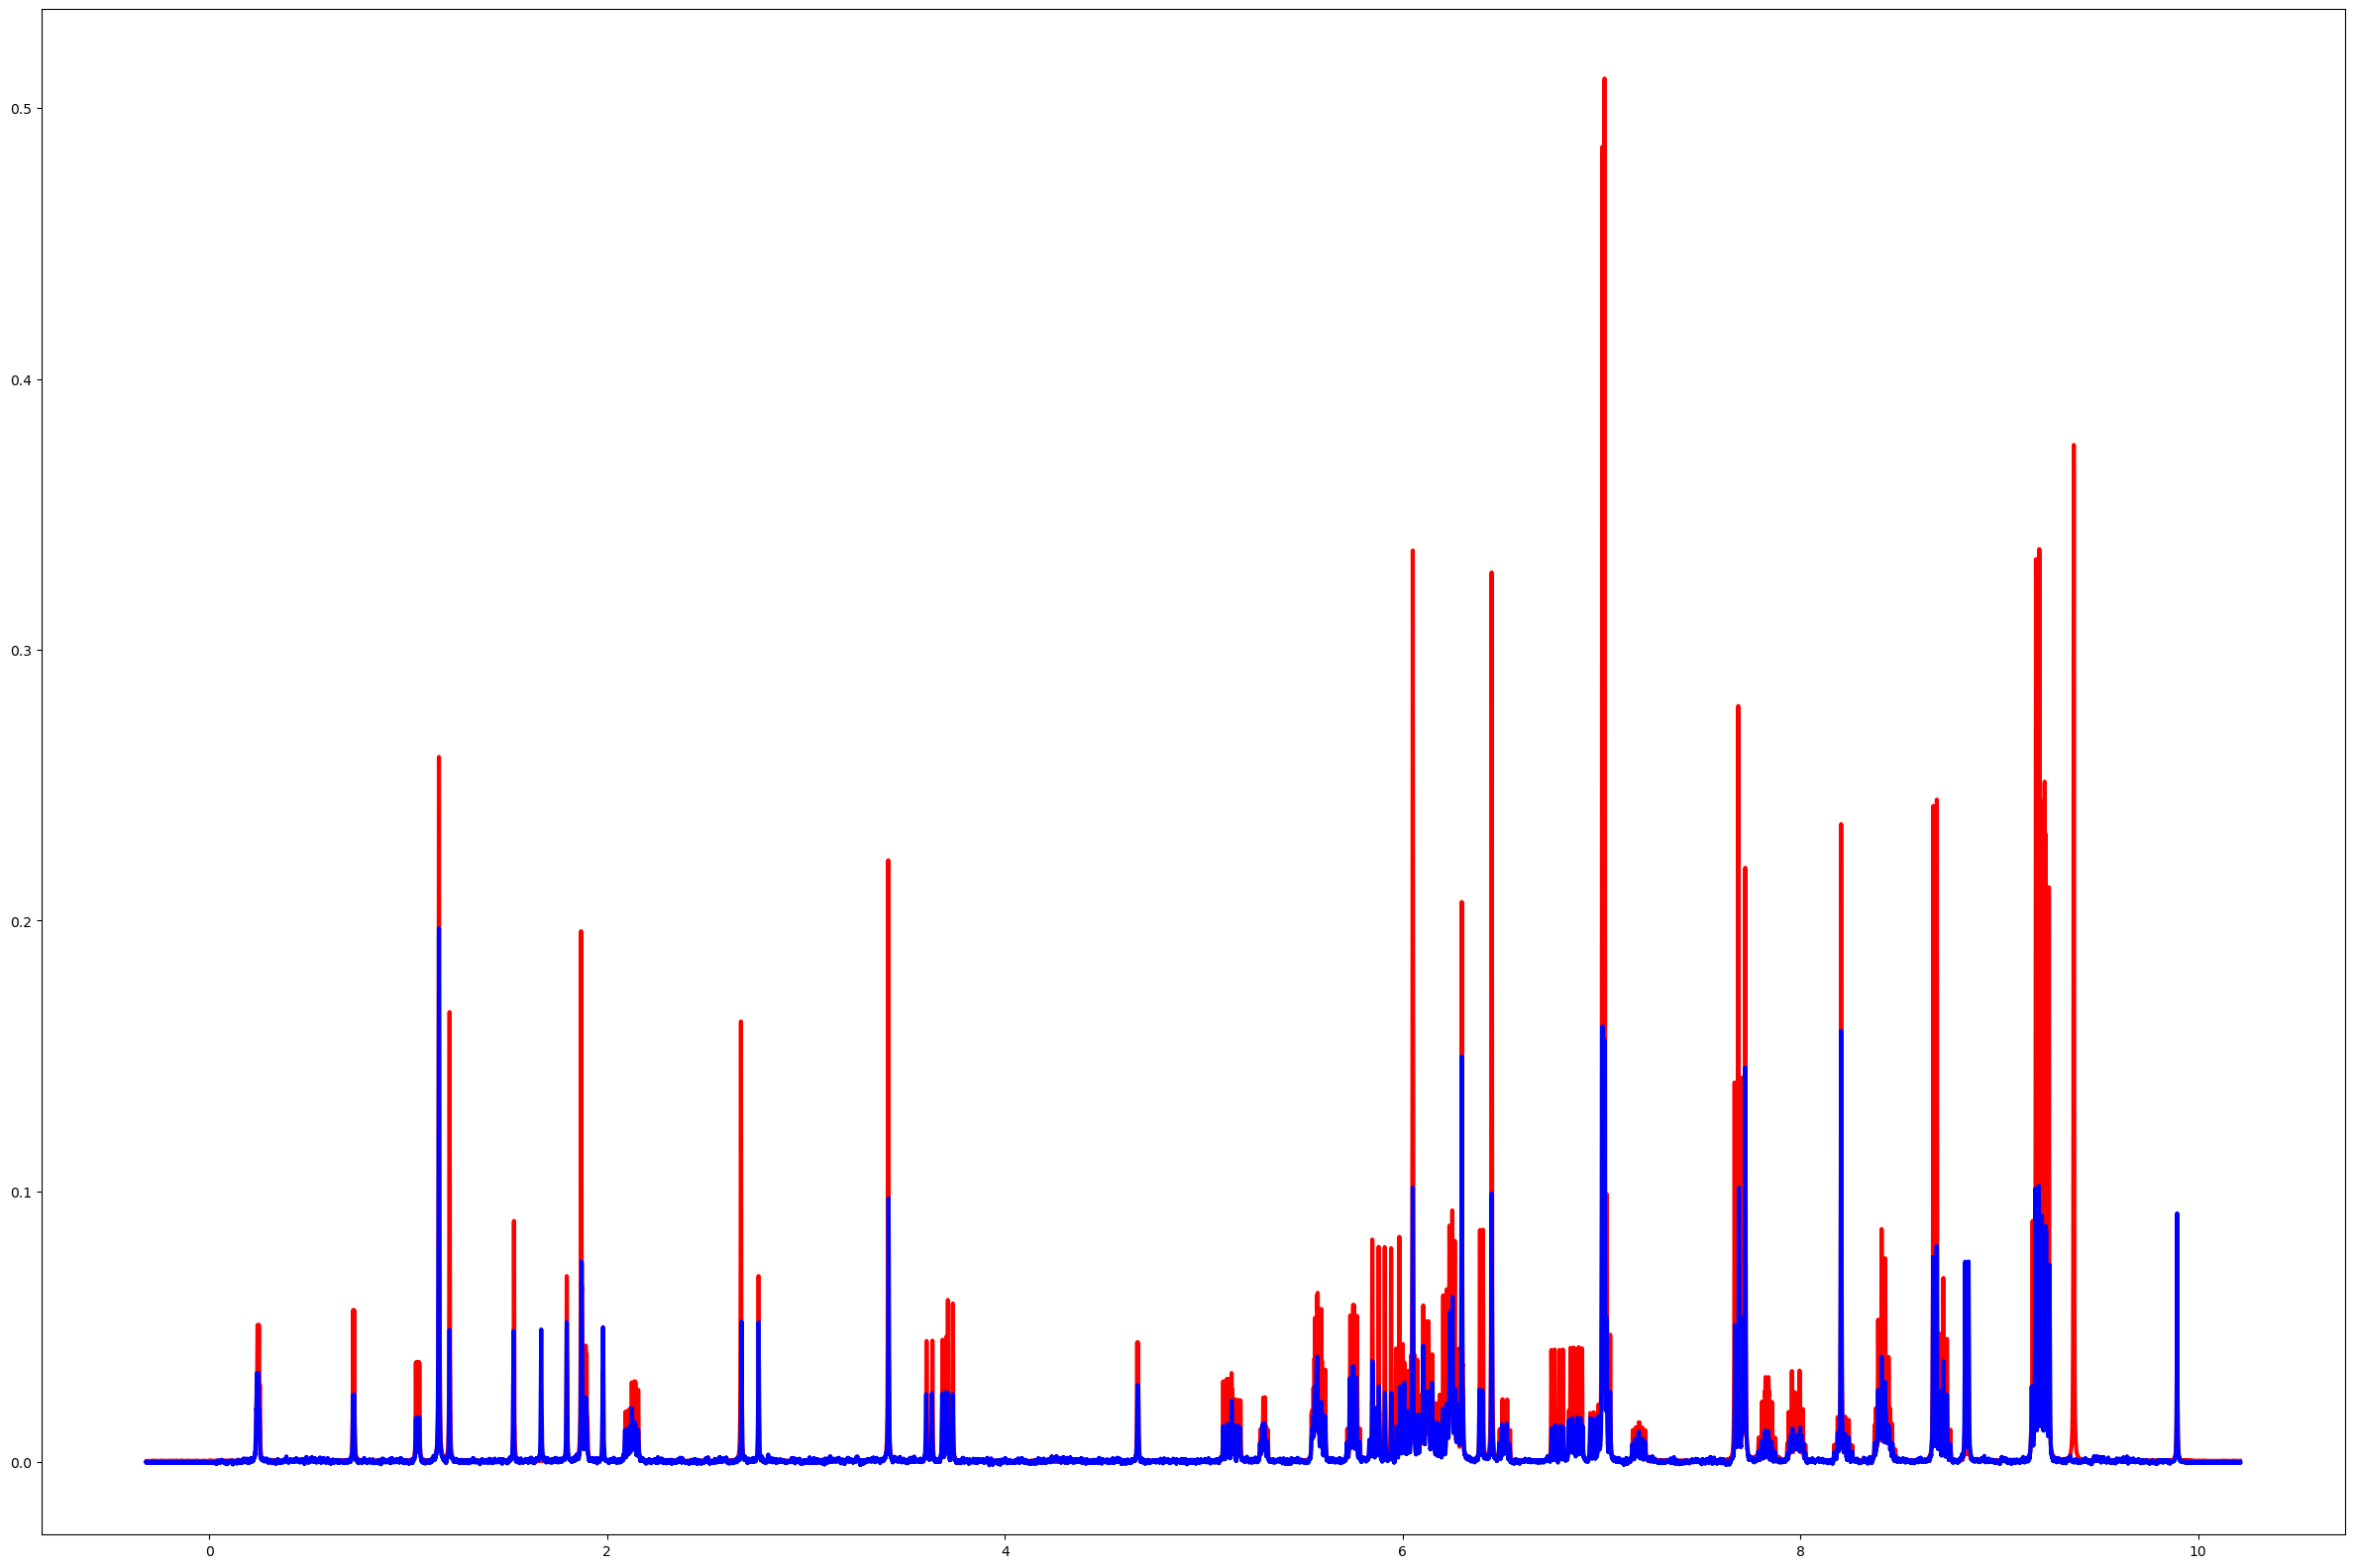

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


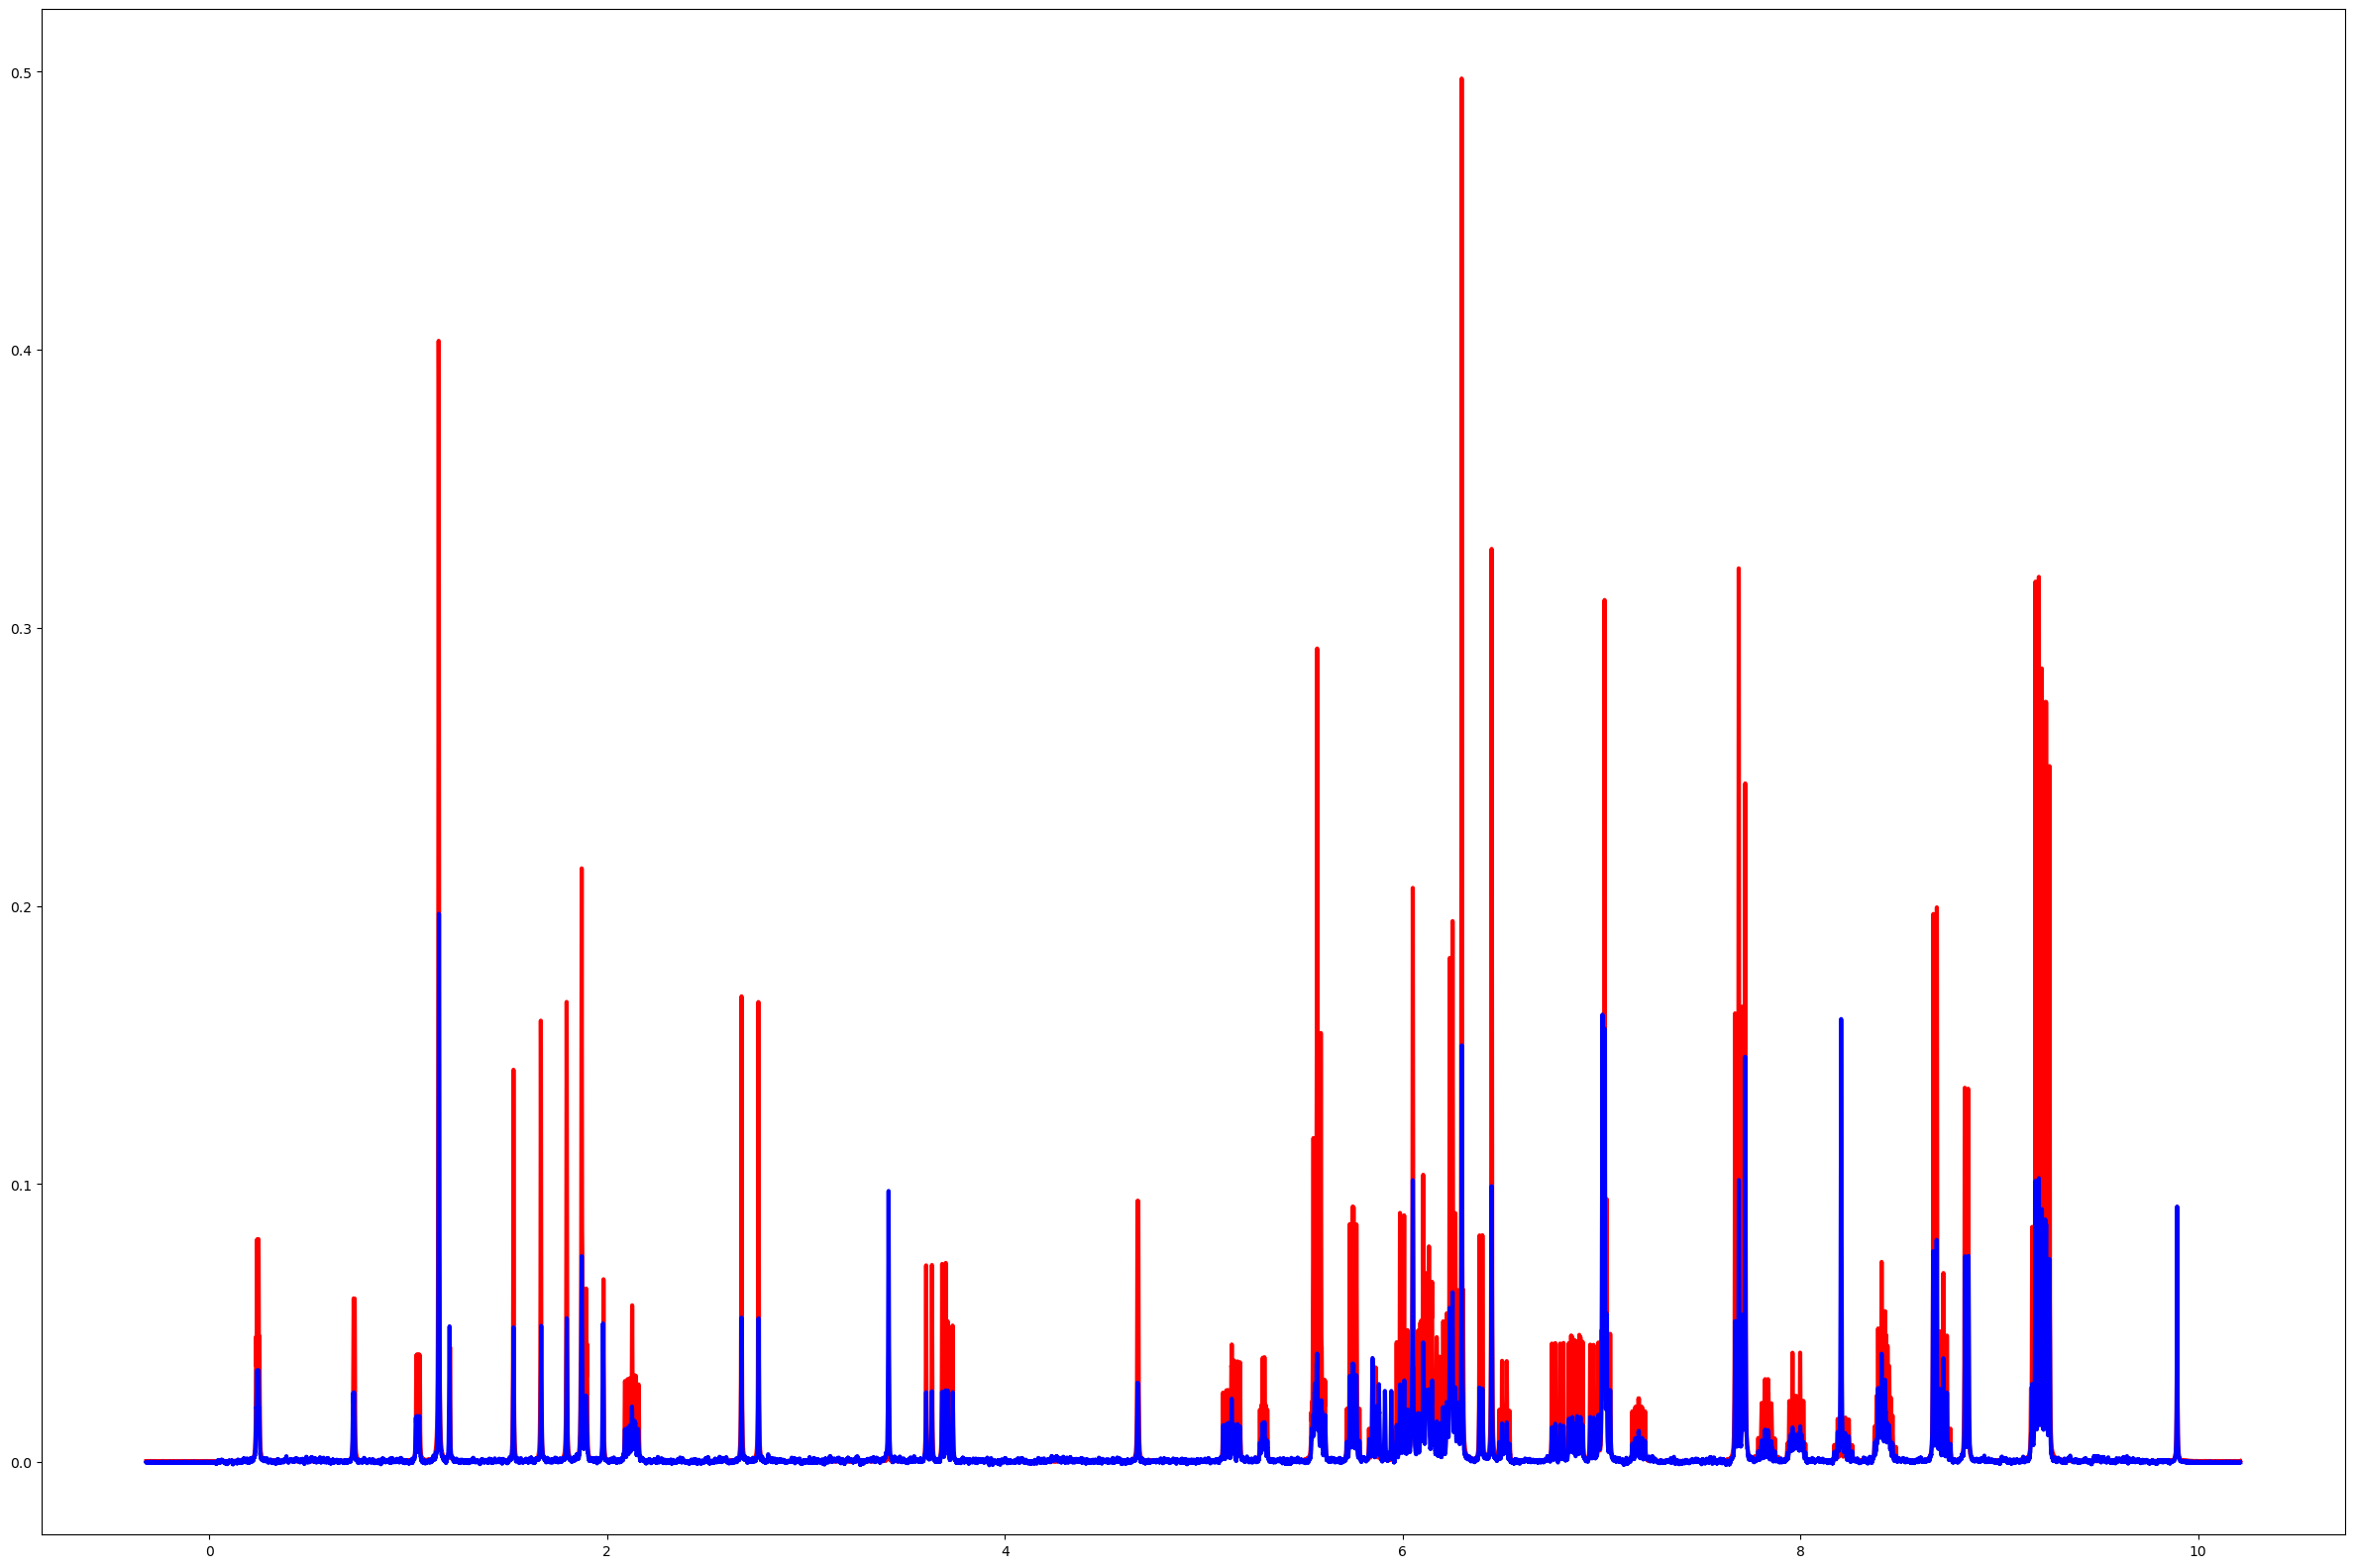

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


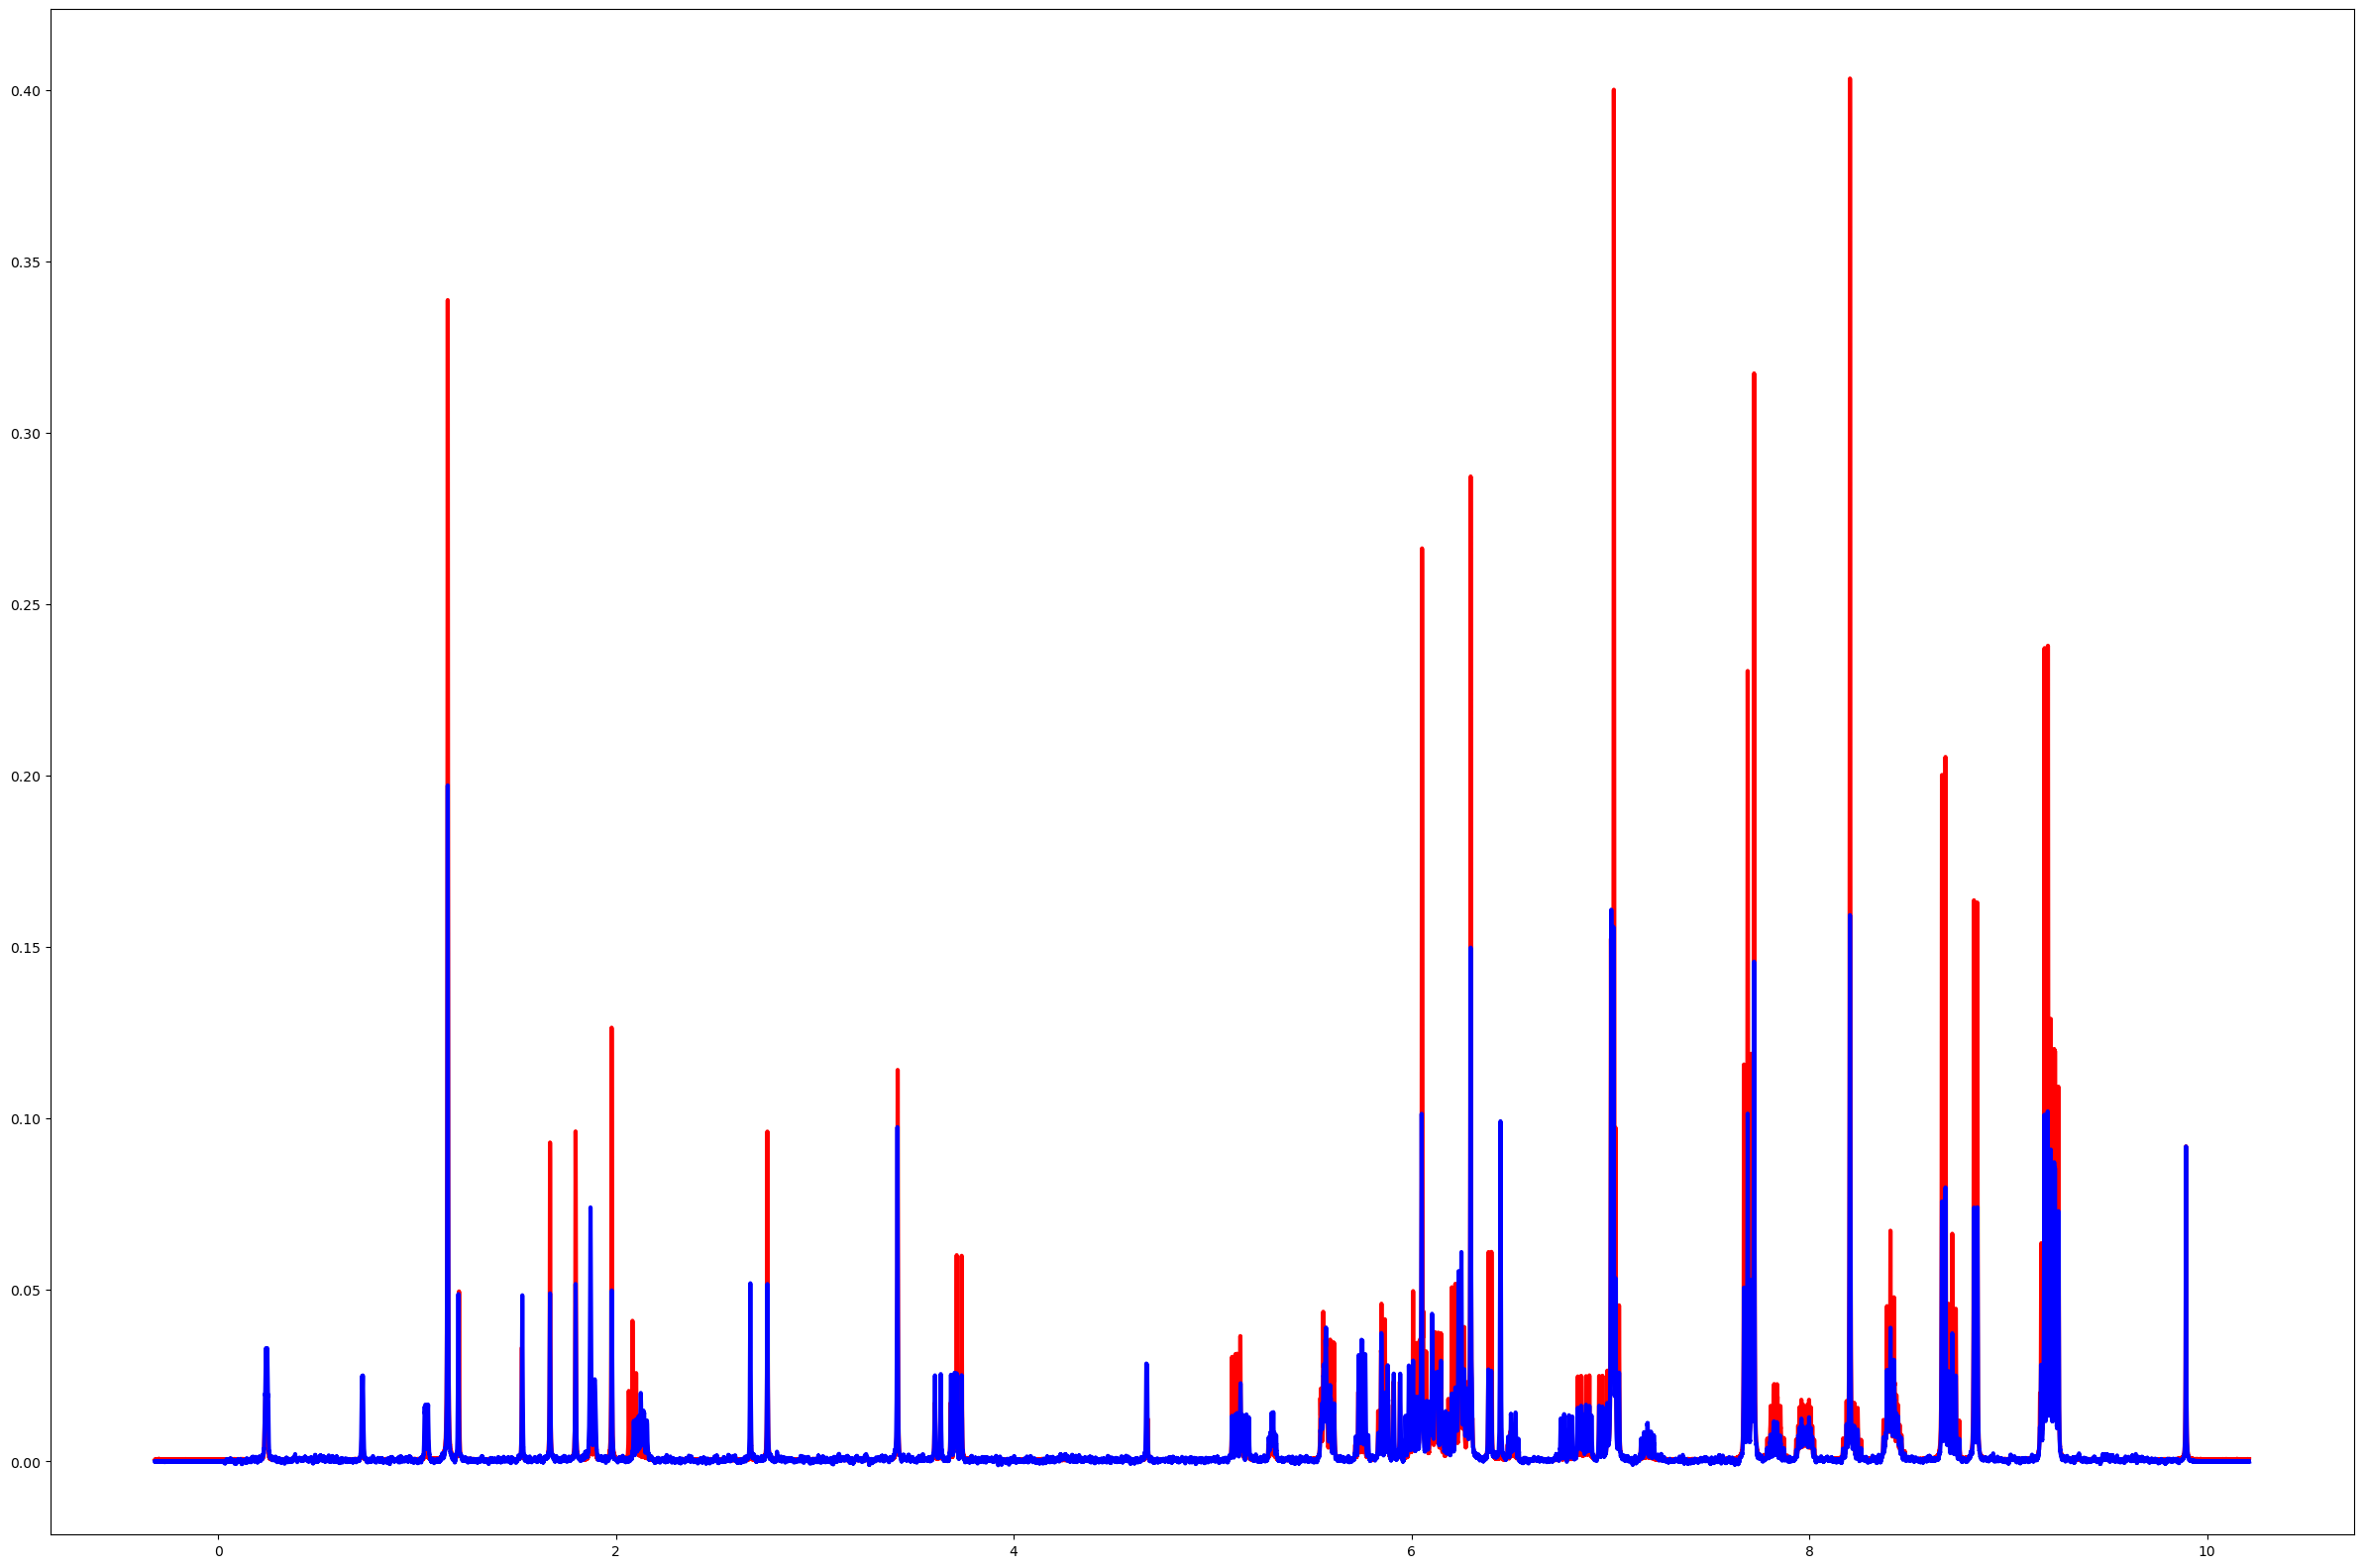

tensor(8.7114e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


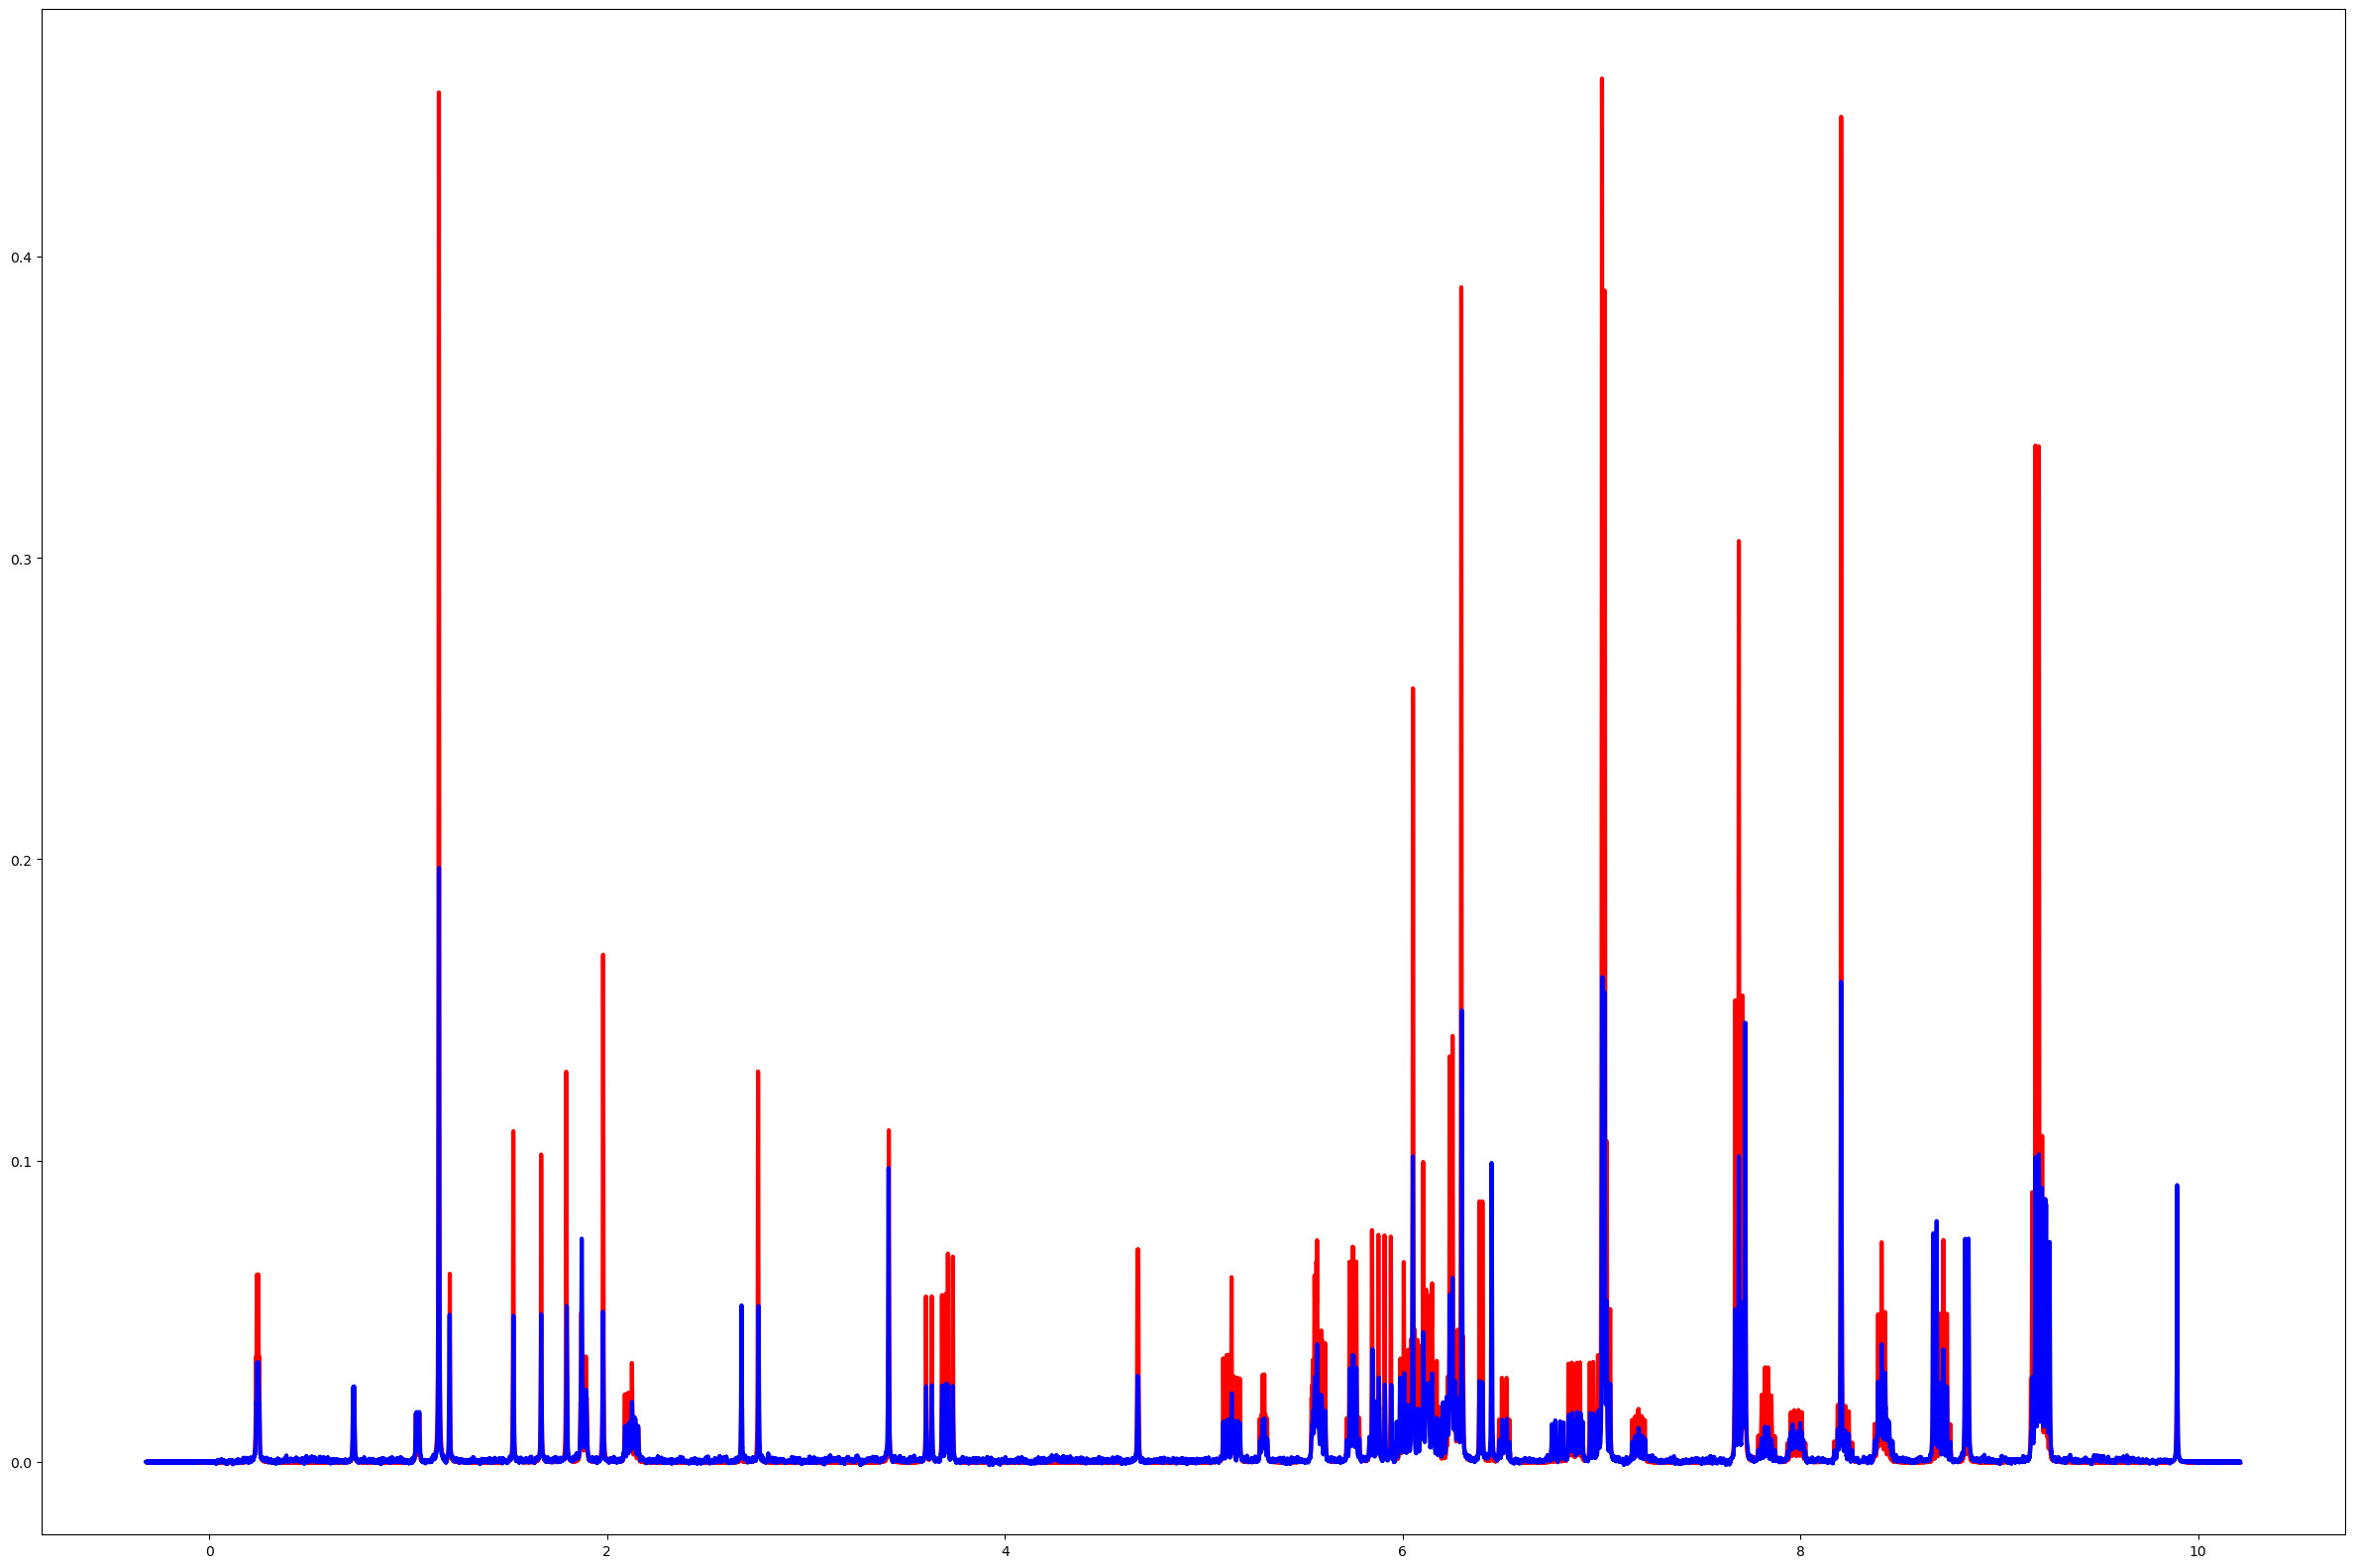

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


In [10]:

LF = spectraVal100[:100]
GT = spectraVal400[:100]
criterion = nn.MSELoss()
model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(LF).cpu().detach().numpy()

for i in np.arange(10):
    plt.plot(np.flip(ppm), GT[i].cpu().detach().numpy(), color = 'red', linewidth = 3)
    plt.plot(np.flip(ppm), outputs[i], color = 'blue', linewidth = 3)
    plt.show()
    print(criterion(model(LF)[i], GT[i]))

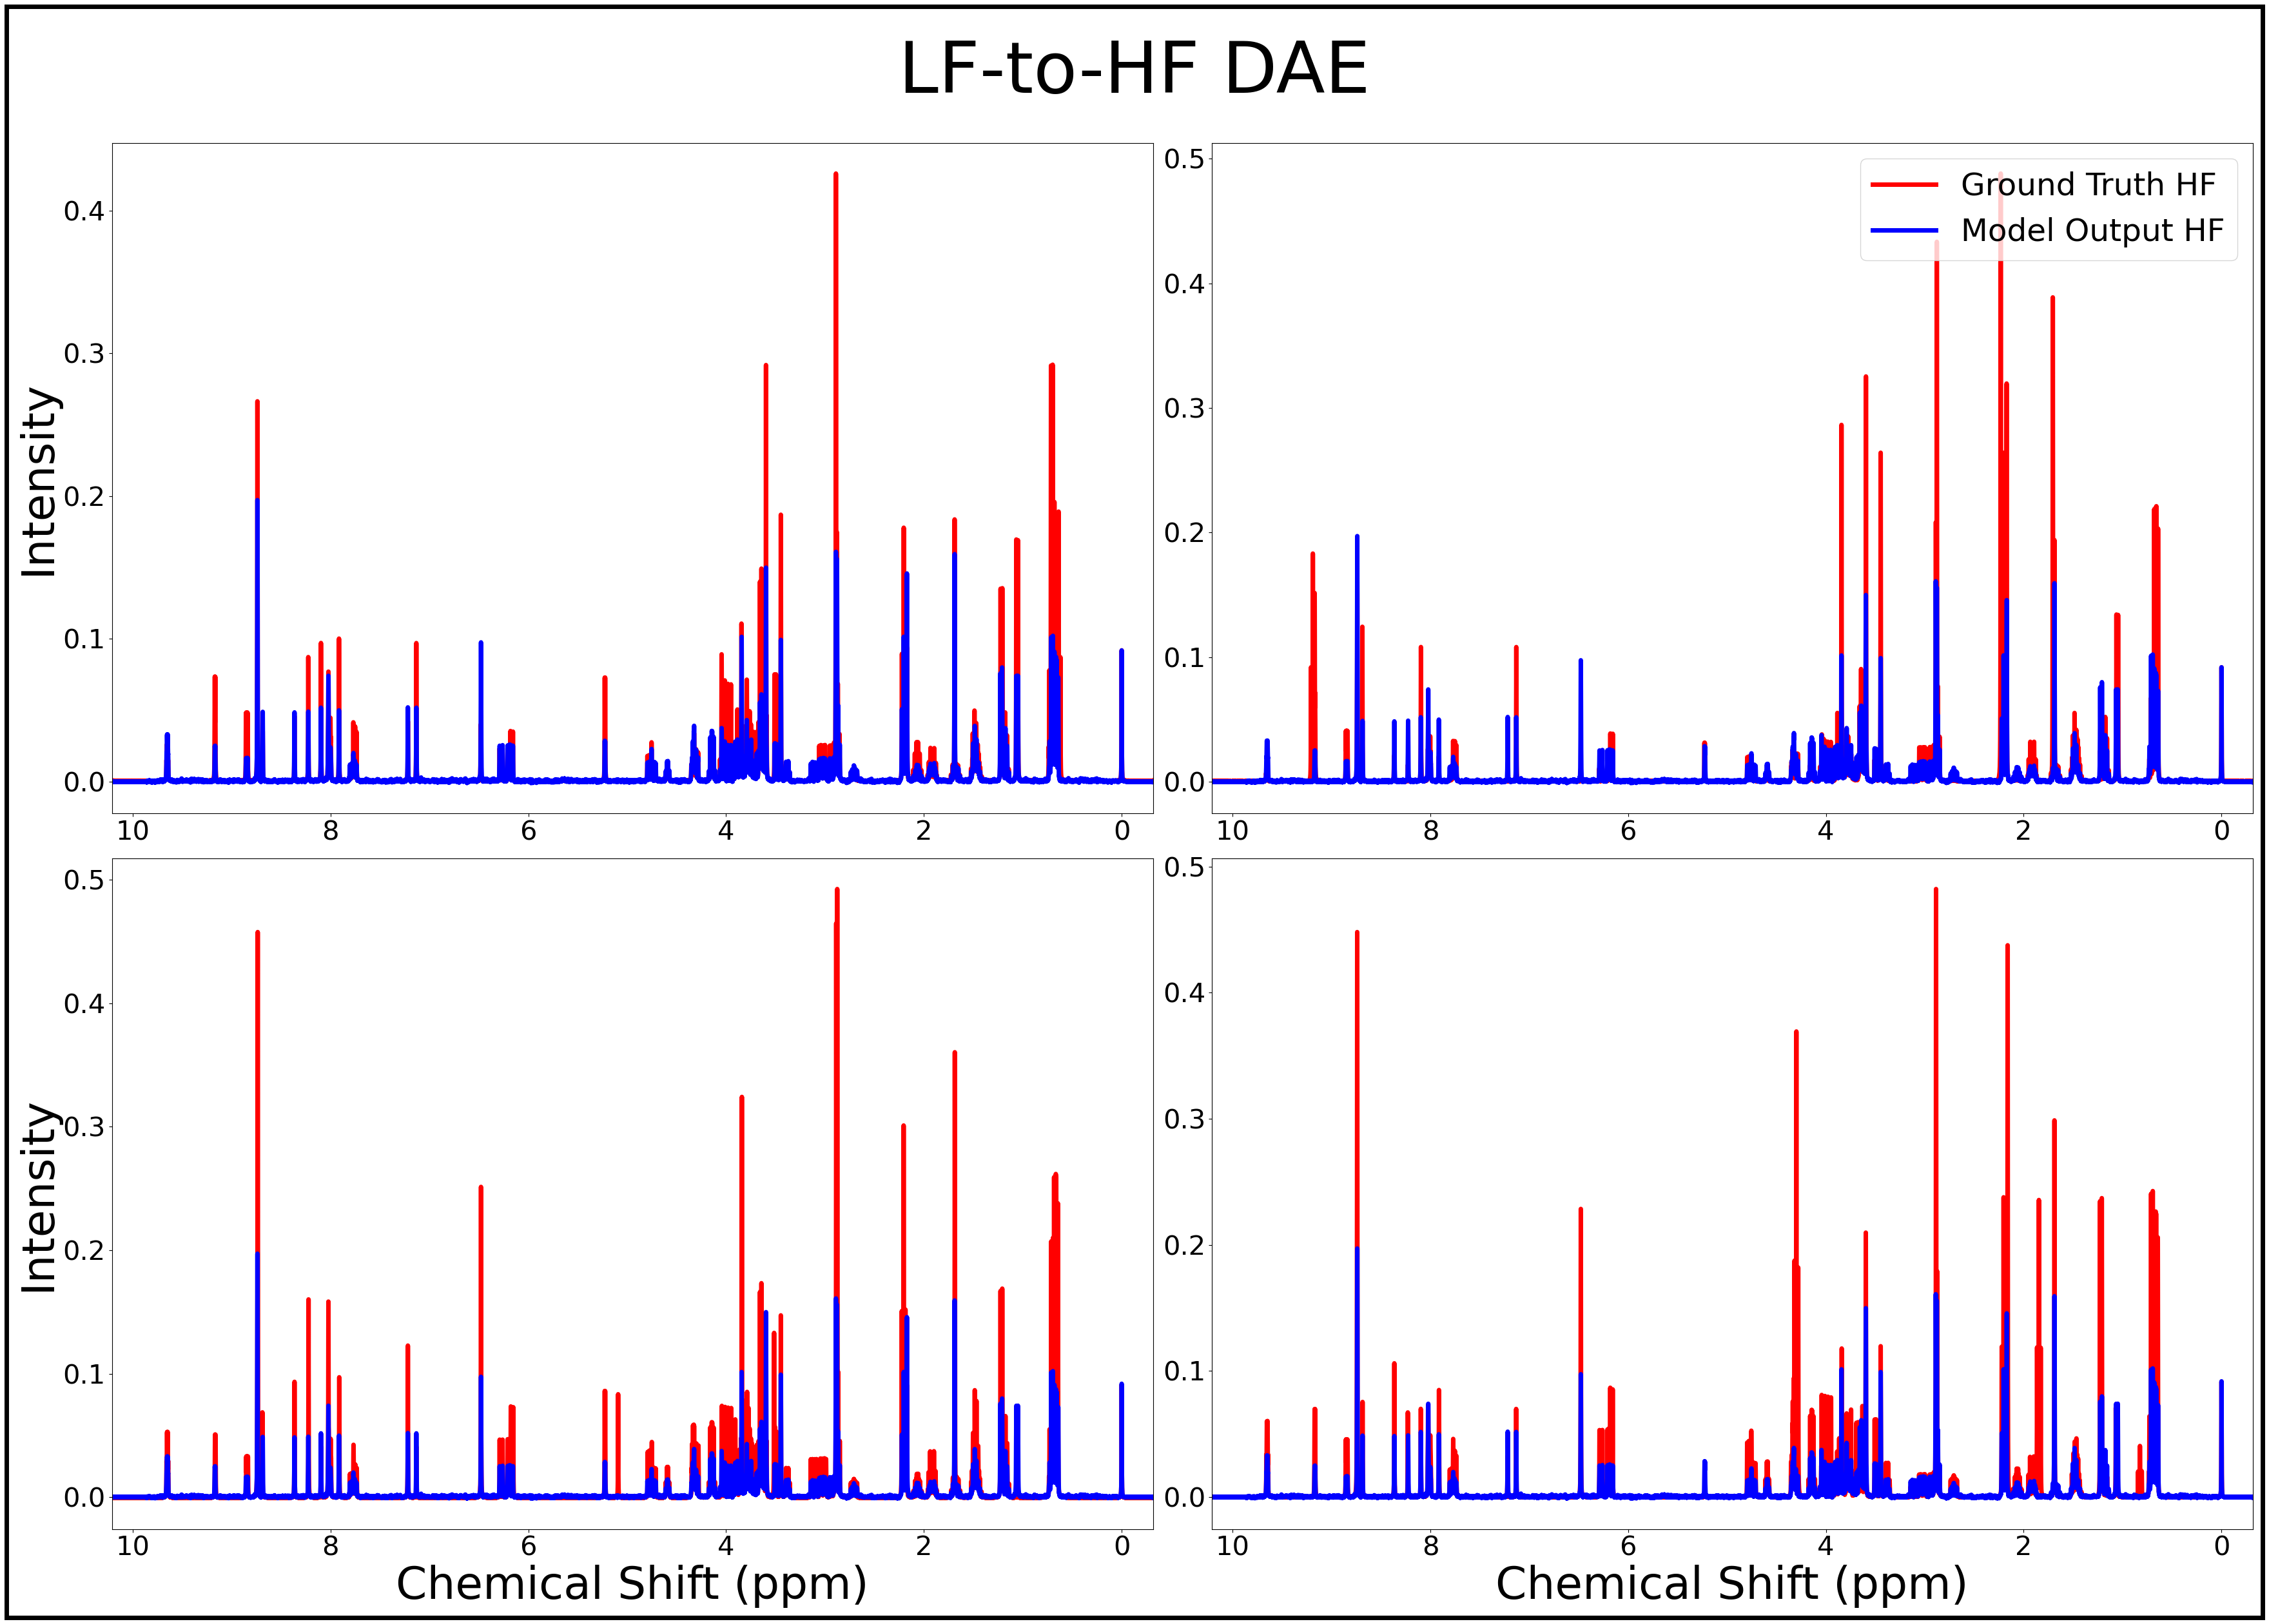

In [11]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')


# Create a figure with 2 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(35, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(LF).cpu().detach().numpy()

for i in range(4):
    ax = axes[i]
    ax.plot(ppm, GT[i].cpu().detach().numpy(), color='red', linewidth=5, label='Ground Truth HF')
    ax.plot(ppm, outputs[i], color='blue', linewidth=5, label='Model Output HF')
    ax.set_xlim(ppm[0], ppm[-1])
    
    # Add legend to the top-right plot (i == 1)
    if i == 1:
        ax.legend(loc='upper right', fontsize = 35)

    # Set x and y labels for the bottom two plots and left five plots
    if i // 2 == 1:  # Bottom two plots (8, 9)
        ax.set_xlabel('Chemical Shift (ppm)', fontsize=50)
    if i % 2 == 0:  # Left five plots (0, 2, 4, 6, 8)
        ax.set_ylabel('Intensity', fontsize=50)
        
    # Modify the size of the tick marks and numbers
    ax.tick_params(axis='both', which='major', labelsize=30)  # major ticks
    ax.tick_params(axis='both', which='minor', labelsize=30)  # minor ticks

# Add an overall title at the top
fig.suptitle('LF-to-HF DAE', fontsize=80)

# Add a rectangle around the entire figure
rect = plt.Rectangle((0, 0), 1, 1, transform=fig.transFigure, linewidth=5, edgecolor='black', facecolor='none')
fig.patches.append(rect)



plt.tight_layout(rect=[0, 0, 1, 0.97])
# Save the figure as a PNG with high resolution
plt.savefig('LF-to-HF_DAE.png', dpi=600, bbox_inches='tight')

plt.show()



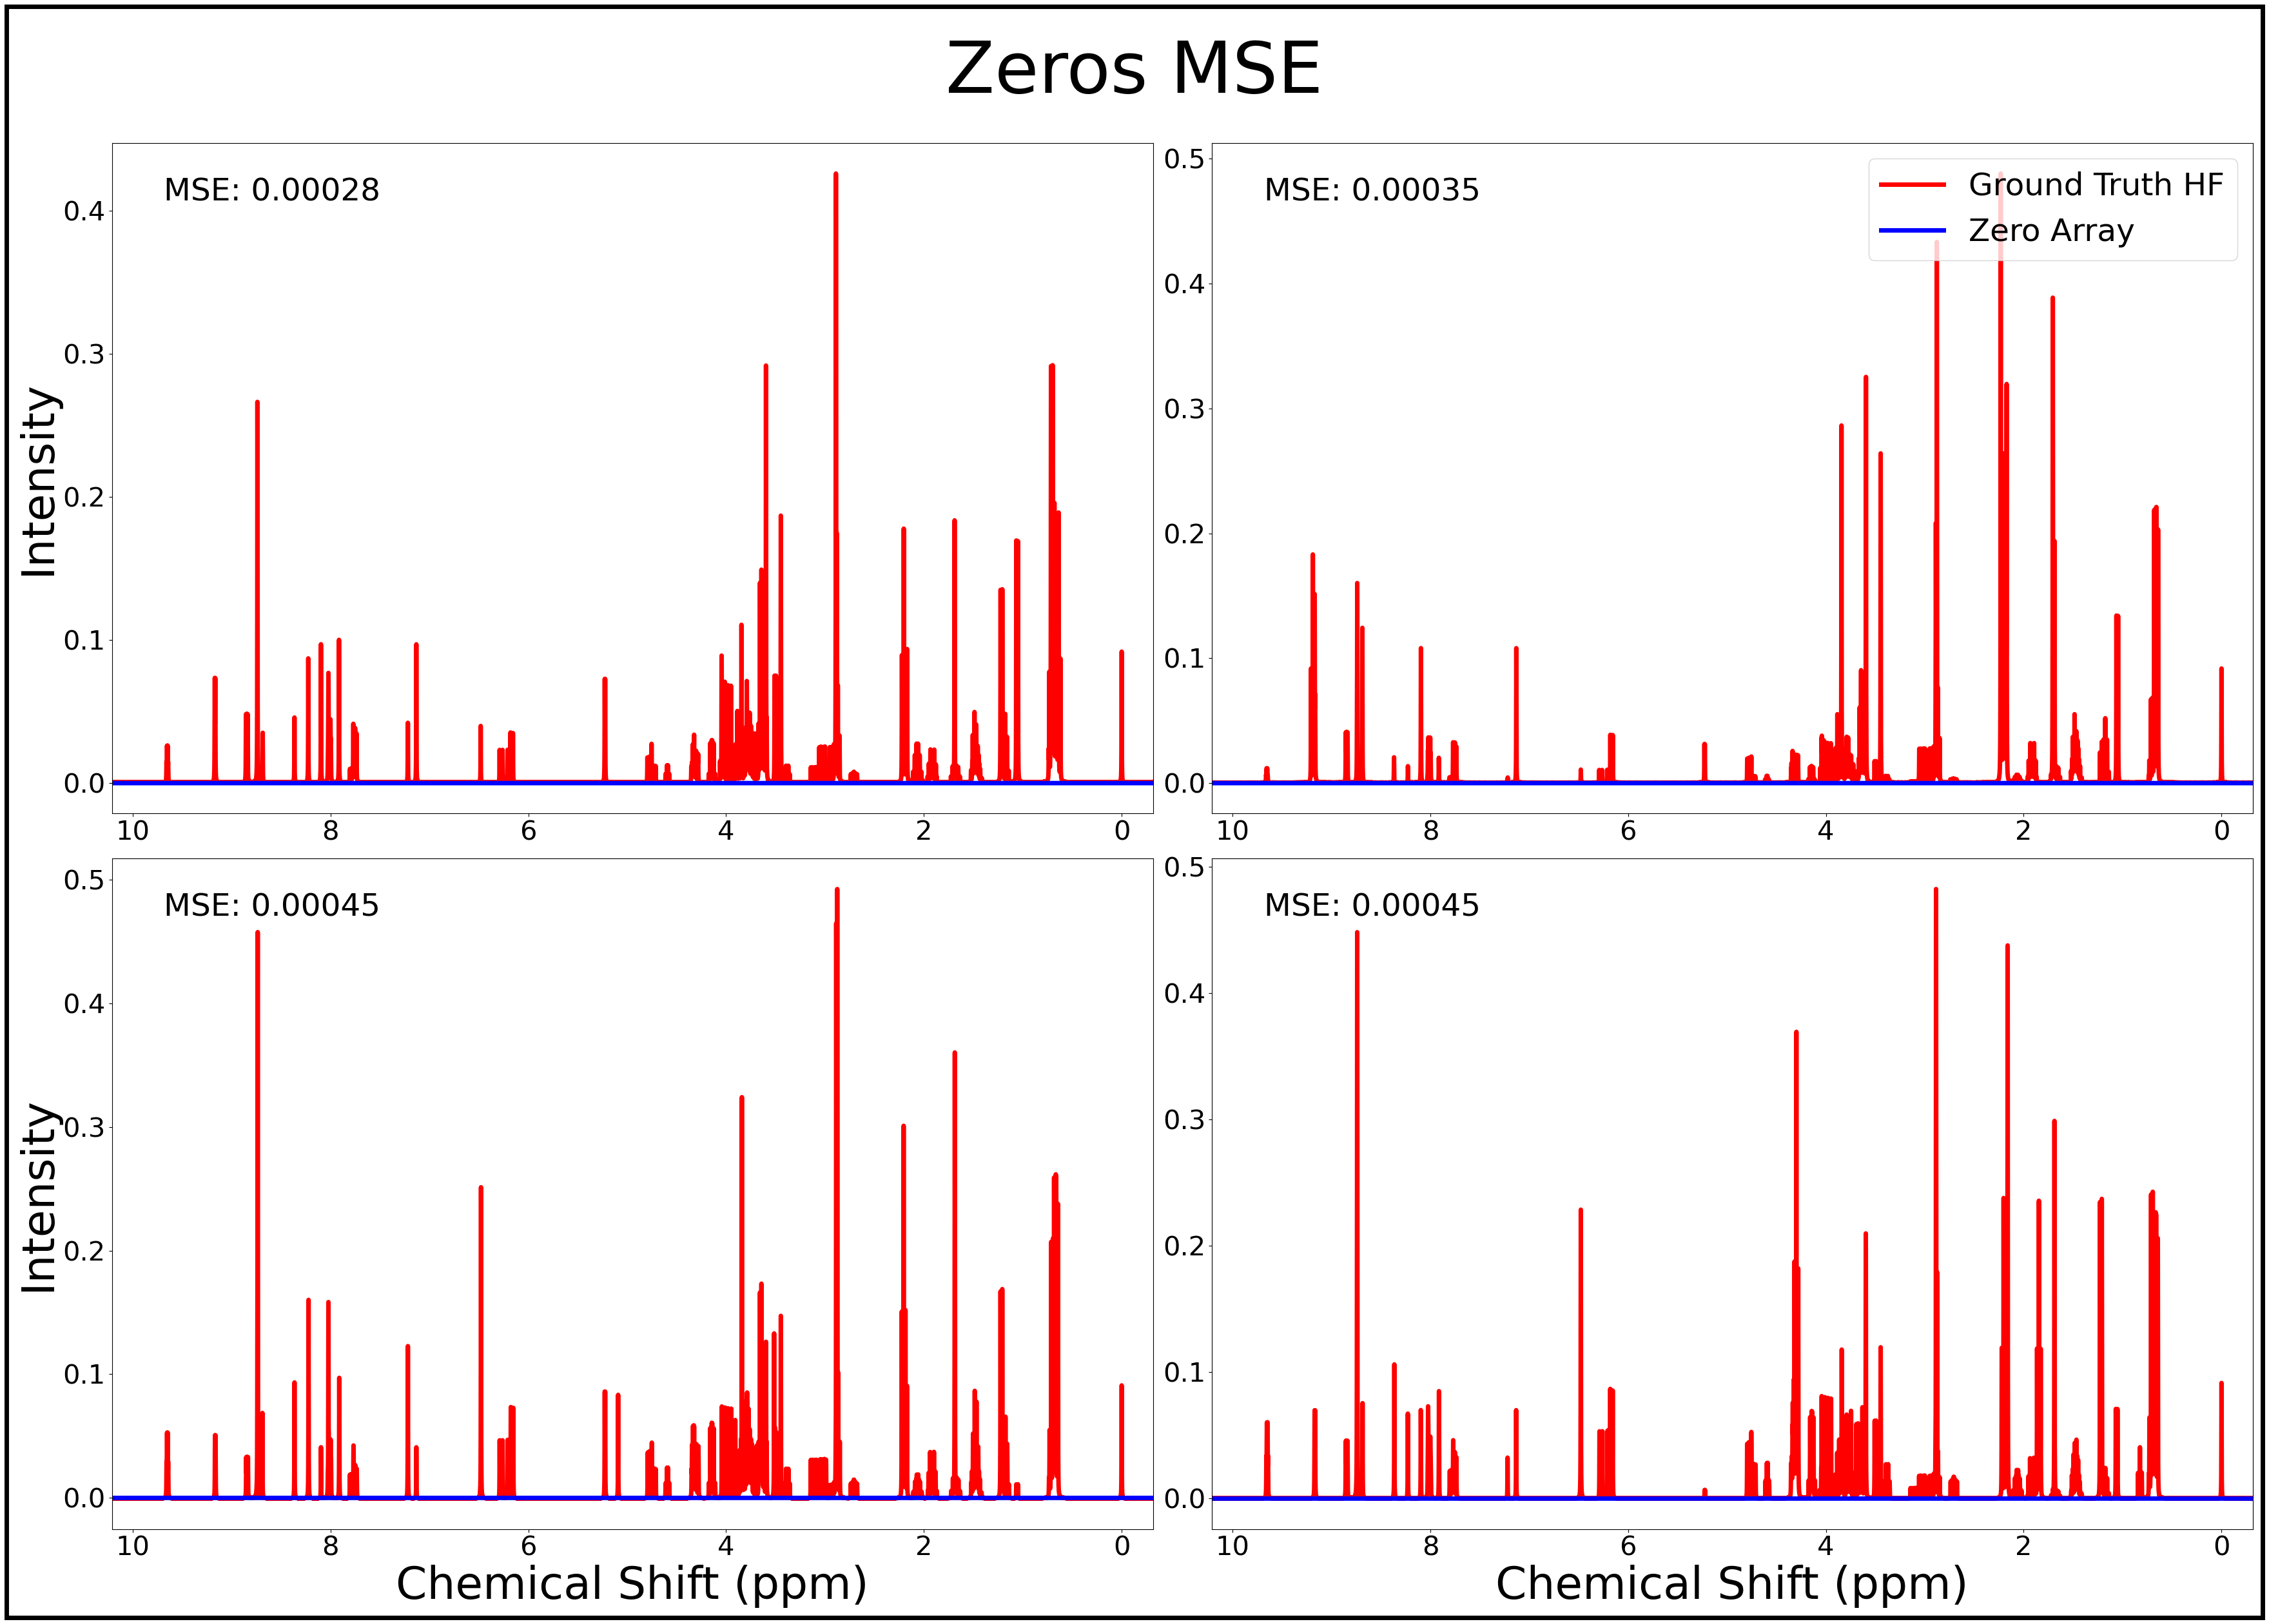

In [16]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')

GT = spectraVal400[:4]
criterion = nn.MSELoss()

# Create a figure with 2 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(35, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = torch.zeros([4,46000])

for i in range(4):
    ax = axes[i]
    ax.plot(ppm, GT[i].cpu().detach().numpy(), color='red', linewidth=5, label='Ground Truth HF')
    ax.plot(ppm, outputs[i], color='blue', linewidth=5, label='Zero Array')
    ax.set_xlim(ppm[0], ppm[-1])

    # Calculate MSE
    mse = criterion(outputs[i].to(device), GT[i]).item()
    ax.text(0.05, 0.95, f'MSE: {mse:.5f}', transform=ax.transAxes, fontsize=35, verticalalignment='top')
    
    # Add legend to the top-right plot (i == 1)
    if i == 1:
        ax.legend(loc='upper right', fontsize = 35)

    # Set x and y labels for the bottom two plots and left five plots
    if i // 2 == 1:  # Bottom two plots (8, 9)
        ax.set_xlabel('Chemical Shift (ppm)', fontsize=50)
    if i % 2 == 0:  # Left five plots (0, 2, 4, 6, 8)
        ax.set_ylabel('Intensity', fontsize=50)
        
    # Modify the size of the tick marks and numbers
    ax.tick_params(axis='both', which='major', labelsize=30)  # major ticks
    ax.tick_params(axis='both', which='minor', labelsize=30)  # minor ticks

# Add an overall title at the top
fig.suptitle('Zeros MSE', fontsize=80)

# Add a rectangle around the entire figure
rect = plt.Rectangle((0, 0), 1, 1, transform=fig.transFigure, linewidth=5, edgecolor='black', facecolor='none')
fig.patches.append(rect)



plt.tight_layout(rect=[0, 0, 1, 0.97])
# Save the figure as a PNG with high resolution
plt.savefig('Zeros_MSE.png', dpi=600, bbox_inches='tight')

plt.show()

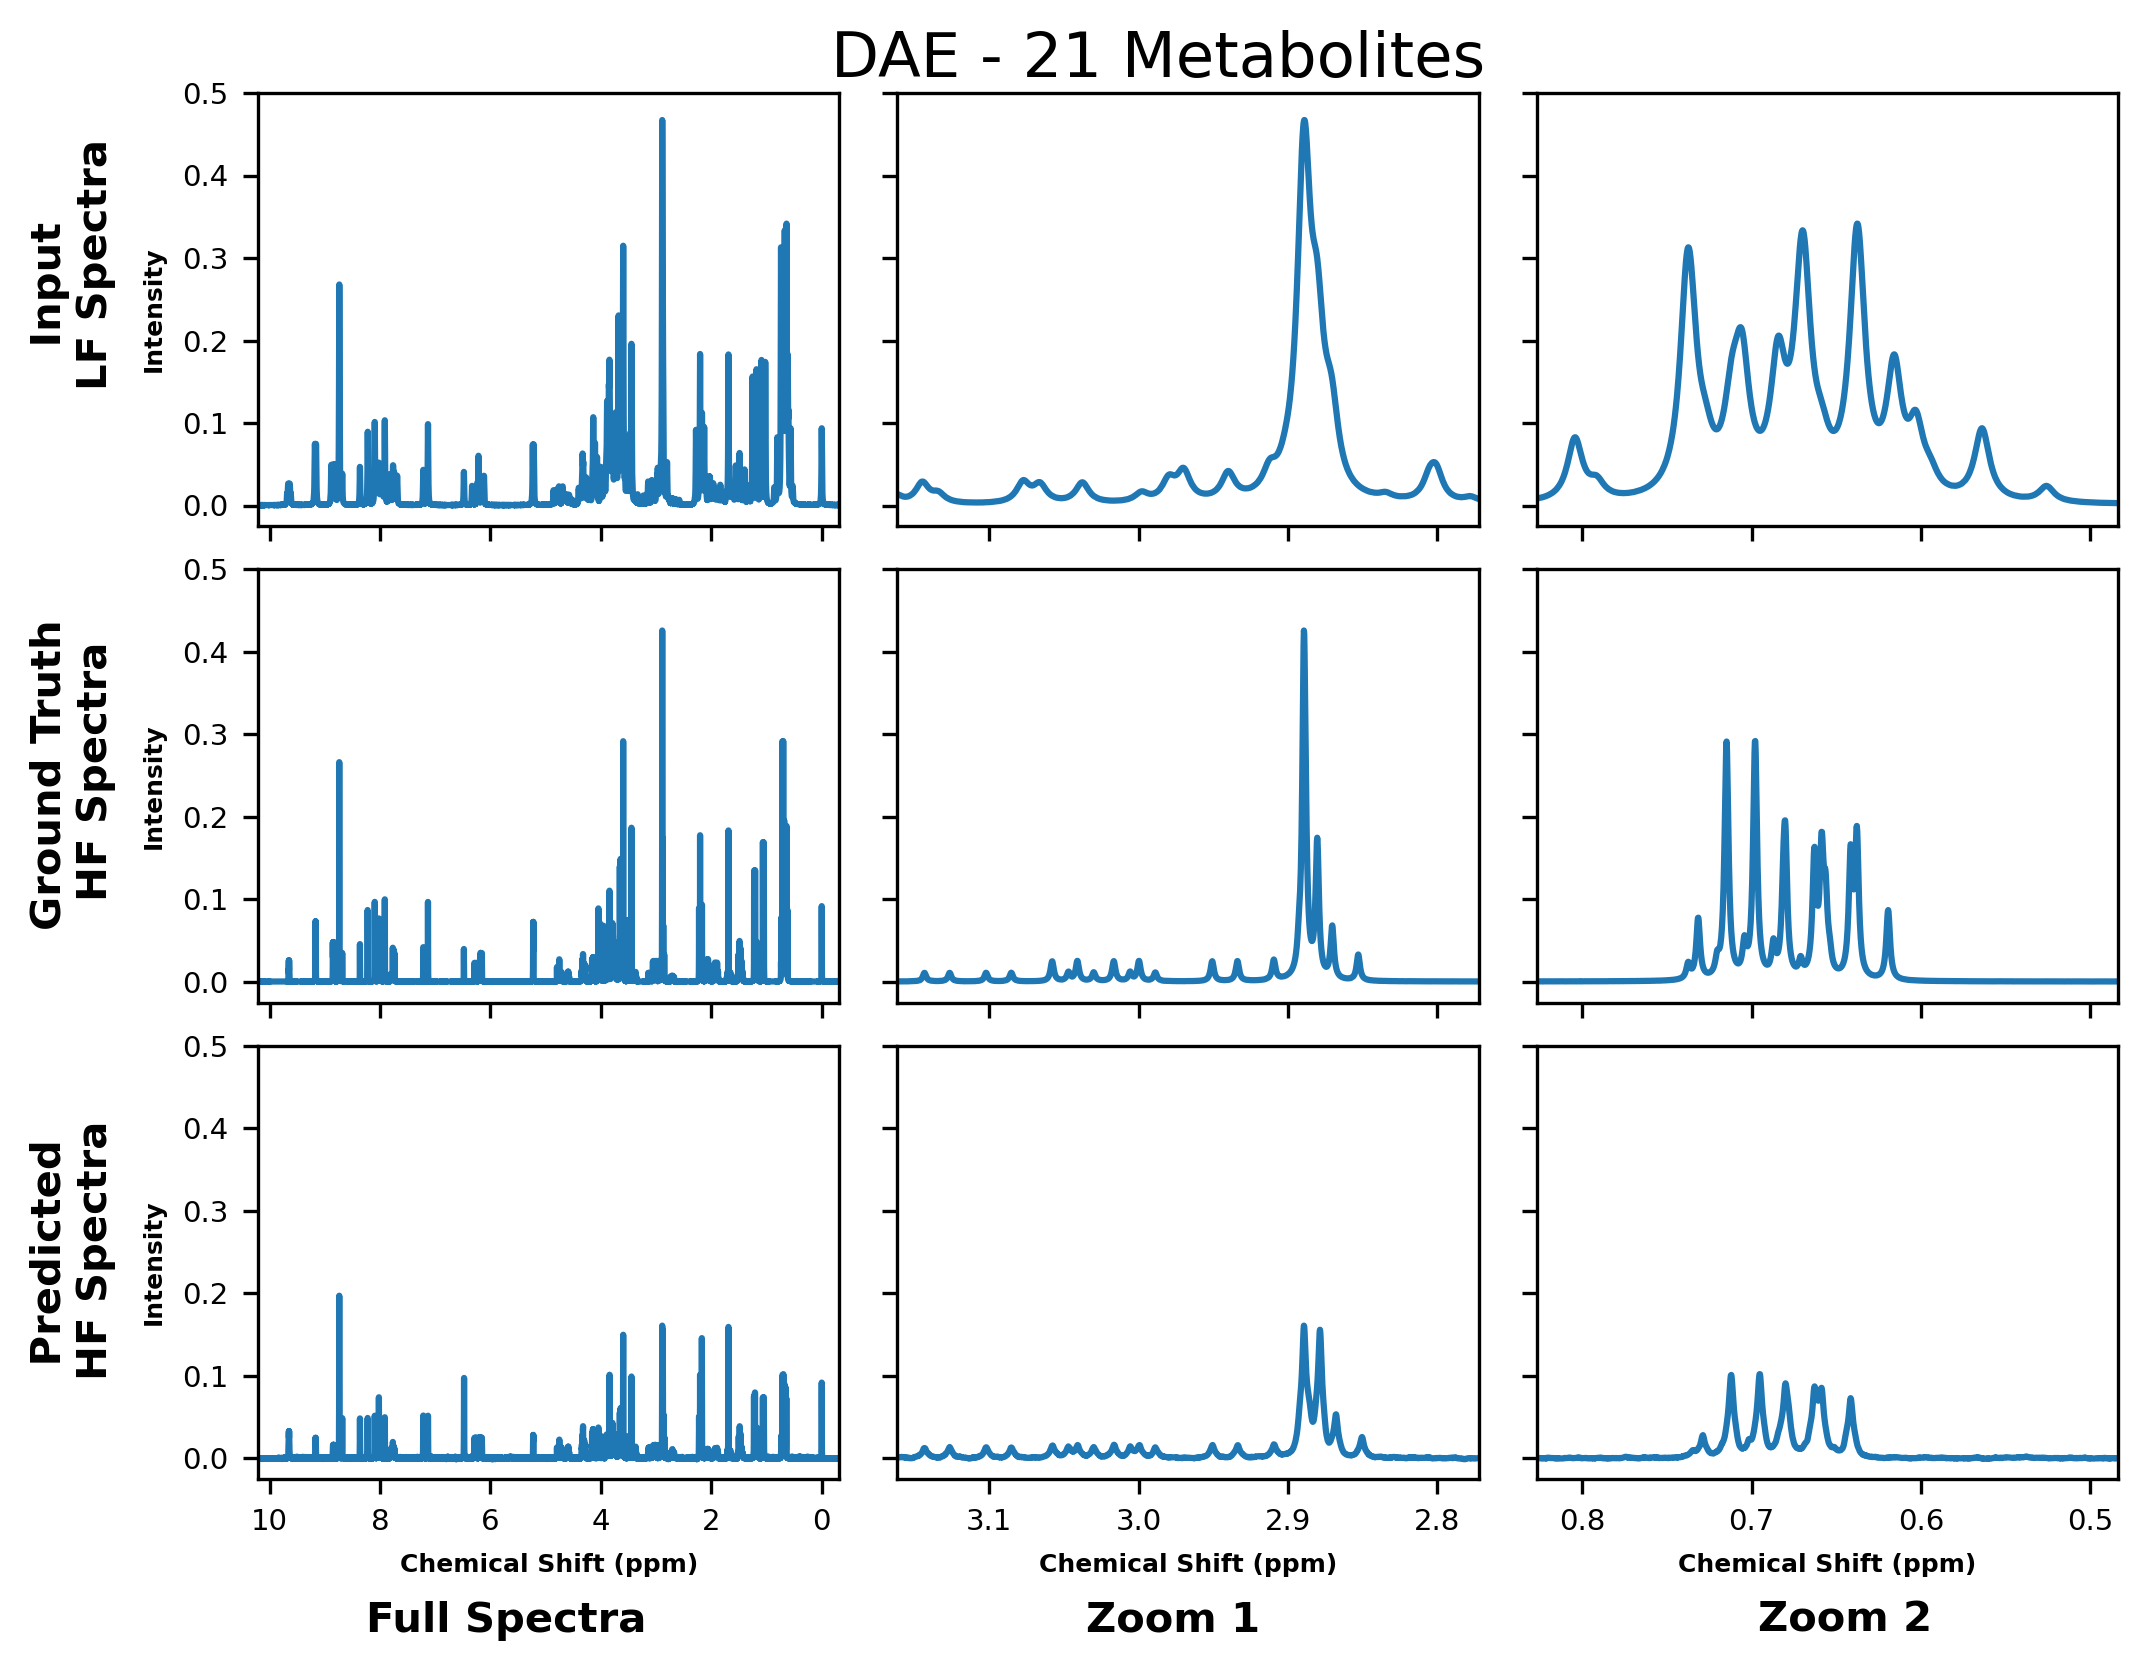

In [13]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')

# Get predicted data from the model
Predicted = model(spectraVal100[0].unsqueeze(0)).cpu().detach().numpy()[0]

# Create figure and subplots with adjusted spacing
fig, axs = plt.subplots(3, 3, figsize=(8, 6), dpi=300)
fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust vertical and horizontal space

# Plotting data for each subplot
axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[0], ppm[-1])
axs[0, 0].set_ylim(-0.025, 0.5)
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[30800], ppm[32500])
axs[0, 1].set_ylim(-0.025, 0.5)
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41000], ppm[42500])
axs[0, 2].set_ylim(-0.025, 0.5)

axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[0], ppm[-1])
axs[1, 0].set_ylim(-0.025, 0.5)
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[30800], ppm[32500])
axs[1, 1].set_ylim(-0.025, 0.5)
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41000], ppm[42500])
axs[1, 2].set_ylim(-0.025, 0.5)

axs[2, 0].plot(ppm, Predicted)
axs[2, 0].set_xlim(ppm[0], ppm[-1])
axs[2, 0].set_ylim(-0.025, 0.5)
axs[2, 1].plot(ppm, Predicted)
axs[2, 1].set_xlim(ppm[30800], ppm[32500])
axs[2, 1].set_ylim(-0.025, 0.5)
axs[2, 2].plot(ppm, Predicted)
axs[2, 2].set_xlim(ppm[41000], ppm[42500])
axs[2, 2].set_ylim(-0.025, 0.5)

# Add main titles inside each subplot
count = -1
plt.rcParams.update({'font.size': 7})
xlabels = ["Chemical Shift (ppm)", "Chemical Shift (ppm)", "Chemical Shift (ppm)"] * 3
ylabels = ["Intensity", "Intensity", "Intensity"] * 3

for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count], fontweight='bold', fontsize=6)
    ax.set_ylabel(ylabels[count], fontweight='bold', fontsize=6)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

    # Add an overall title at the top
fig.suptitle('DAE - 21 Metabolites', fontsize=15, x=0.5, y=0.915)

# Add subtitles as the main titles for each row and column
fig.text(0.03, 0.72, "   Input \nLF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.42, "Ground Truth \n  HF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.17, " Predicted \nHF Spectra", rotation='vertical', fontweight='bold', fontsize=10)

fig.text(0.17, 0.02, "Full Spectra", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.47, 0.02, "Zoom 1", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.75, 0.02, "Zoom 2", va='bottom', fontweight='bold', fontsize=10)

plt.savefig('DAE_Visual.png', dpi=600, bbox_inches='tight')

plt.show()


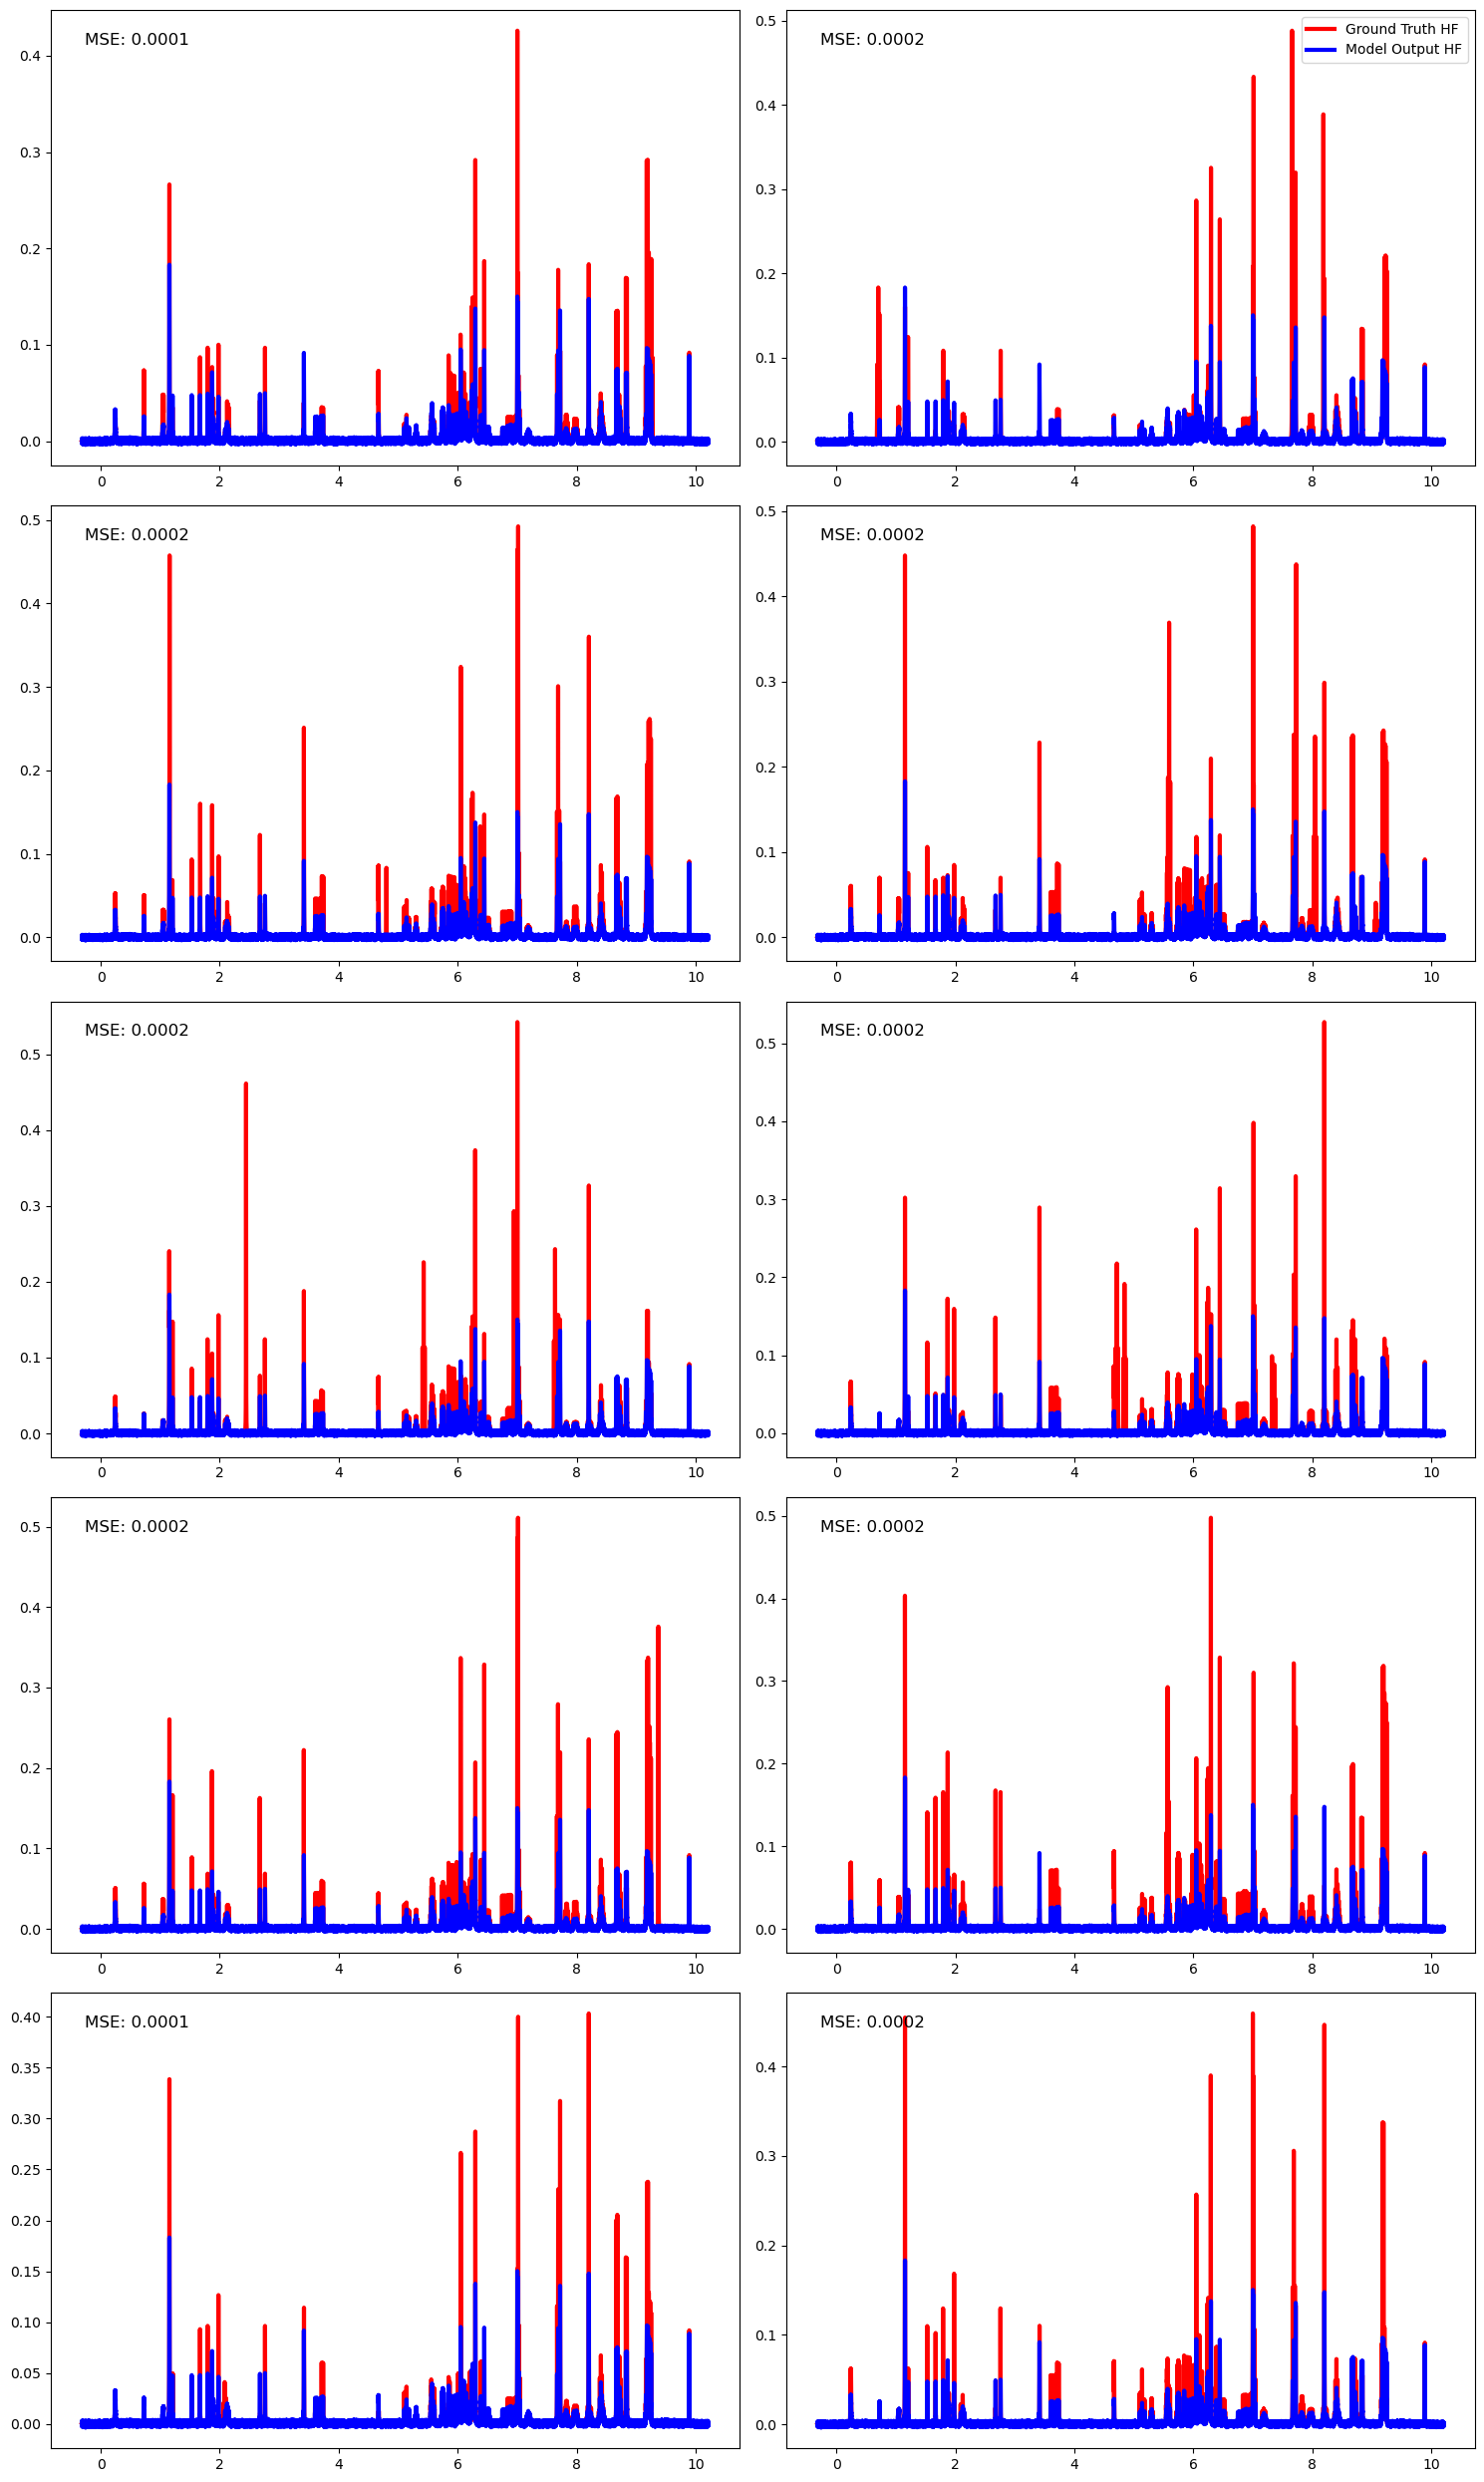

In [19]:
# Assuming GT, model, and criterion are already defined as in your code

zeros = torch.tensor(np.zeros((100,46000))).float().to(device)

# Create a figure with 2 columns and 5 rows
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(zeros).cpu().detach().numpy()

for i in range(10):
    ax = axes[i]
    ax.plot(np.flip(ppm), GT[i].cpu().detach().numpy(), color='red', linewidth=3, label='Ground Truth HF')
    ax.plot(np.flip(ppm), outputs[i], color='blue', linewidth=3, label='Model Output HF')
    
    # Calculate MSE
    mse = criterion(model(zeros)[i], GT[i]).item()
    ax.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    
    # Add legend to the top-right plot (i == 1)
    if i == 1:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Check if model is predicting average concentrations every time (overtraining)

In [15]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 1000
ModelName = "MLP_21Met_ForLFtoHF__HFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [16]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400 = np.load('Dataset21_400MHz_Spec_ForQuant.npy')
conc1 = np.load('Dataset21_400MHz_Conc_ForQuant.npy')

# Load validation dataset
#spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
#spectraValConc = np.load('Dataset21_Val_Conc.npy')

# Load representative validation spectra
RepSpectra400 = np.load("Dataset21_400MHz_RepresentativeExamples_Spectra.npy")
RepConc = np.load("Dataset21_RepresentativeExamples_Concentrations.npy")
RepSpecNames = np.load("Dataset21_RepresentativeExamples_VariableNames.npy")

In [17]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [18]:
## Define NN model object, define some parameters, and instantiate model

# Define some model & training parameters
size_hidden1 = 200
size_hidden2 = 21
criterion = nn.MSELoss(reduction='sum')


# Define model
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(46000, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
    def forward(self, input):
        return (self.lin2(self.relu1(self.lin1(input))))

In [19]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 1500
ModelName = "MLP_21Met_ForLFtoHF__HFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [20]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_400 = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_400.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_400.to(device)

NMR_Model_Aq(
  (lin1): Linear(in_features=46000, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=21, bias=True)
)

In [21]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 1500
ModelName = "MLP_21Met_ForLFtoHF__LFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [22]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra100 = np.load('Dataset21_100MHz_Spec_ForQuant.npy')
conc1 = np.load('Dataset21_100MHz_Conc_ForQuant.npy')

# Load validation dataset
#spectraVal100 = np.load('Dataset21_400MHz_Val_Spec.npy')
#spectraValConc = np.load('Dataset21_Val_Conc.npy')

# Load representative validation spectra
RepSpectra100 = np.load("Dataset21_100MHz_RepresentativeExamples_Spectra.npy")
RepConc = np.load("Dataset21_RepresentativeExamples_Concentrations.npy")
RepSpecNames = np.load("Dataset21_RepresentativeExamples_VariableNames.npy")

In [23]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_100 = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_100.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_100.to(device)

NMR_Model_Aq(
  (lin1): Linear(in_features=46000, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=21, bias=True)
)

In [34]:
print(RepSpecNames[0])
model_400(model(torch.tensor(RepSpectra100[0]).float().to(device)))

AllAq1


tensor([[20.2642, 19.3648, 19.4974, 19.7842, 19.6442, 19.9346, 20.1909, 19.3679,
         19.7669, 19.0956, 19.1079, 18.7394, 19.0988, 19.7092, 18.9918, 19.5180,
         19.1955, 19.7302, 19.2400, 22.0004, 19.2798]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [44]:
print(RepSpecNames[0])
model_100(torch.tensor(RepSpectra100[0]).float().to(device))

AllAq1


tensor([[ 1.0623,  0.7830,  0.7651,  0.2391, -0.2826,  0.4619,  0.3491,  0.6530,
          1.6041,  1.6697,  1.1141,  0.8177,  1.0525,  1.4633, -0.3063,  1.2023,
          1.5167,  1.2820,  1.2181,  1.1345,  1.3340]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [35]:
print(RepSpecNames[1])
model_400(model(torch.tensor(RepSpectra100[1]).float().to(device)))

AllAq5


tensor([[20.2643, 19.3649, 19.4975, 19.7843, 19.6443, 19.9348, 20.1909, 19.3679,
         19.7670, 19.0957, 19.1079, 18.7395, 19.0990, 19.7093, 18.9919, 19.5181,
         19.1955, 19.7303, 19.2400, 22.0005, 19.2798]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [45]:
print(RepSpecNames[1])
model_100(torch.tensor(RepSpectra100[1]).float().to(device))

AllAq5


tensor([[4.9554, 4.6249, 4.8320, 4.5619, 4.7052, 4.7645, 4.7870, 4.7340, 4.8553,
         4.8725, 4.7250, 4.9184, 4.6506, 4.8595, 4.6921, 4.8665, 4.9343, 4.8286,
         4.9432, 4.9290, 4.8487]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [36]:
print(RepSpecNames[2])
model_400(model(torch.tensor(RepSpectra100[2]).float().to(device)))

AllAq25


tensor([[20.2643, 19.3649, 19.4975, 19.7843, 19.6443, 19.9348, 20.1909, 19.3679,
         19.7670, 19.0957, 19.1079, 18.7395, 19.0990, 19.7093, 18.9919, 19.5181,
         19.1955, 19.7303, 19.2400, 22.0005, 19.2798]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [46]:
print(RepSpecNames[2])
model_100(torch.tensor(RepSpectra100[2]).float().to(device))

AllAq25


tensor([[25.2135, 24.7472, 24.8089, 24.9522, 24.8042, 25.1324, 24.9888, 25.0929,
         25.0019, 24.9209, 24.8146, 25.1265, 25.1603, 25.0914, 24.7471, 24.8253,
         24.7749, 25.0764, 24.7317, 25.0754, 24.8297]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [37]:
print(RepSpecNames[3])
model_400(model(torch.tensor(RepSpectra100[3]).float().to(device)))

AllAq50


tensor([[20.2643, 19.3649, 19.4975, 19.7843, 19.6443, 19.9348, 20.1909, 19.3679,
         19.7670, 19.0957, 19.1079, 18.7395, 19.0990, 19.7093, 18.9919, 19.5181,
         19.1955, 19.7303, 19.2400, 22.0005, 19.2798]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [38]:
print(RepSpecNames[6])
model_400(model(torch.tensor(RepSpectra100[6]).float().to(device)))

ShiftedSpec


tensor([[20.2643, 19.3649, 19.4975, 19.7843, 19.6443, 19.9348, 20.1909, 19.3679,
         19.7670, 19.0957, 19.1079, 18.7395, 19.0990, 19.7093, 18.9919, 19.5181,
         19.1955, 19.7303, 19.2400, 22.0005, 19.2798]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [43]:
print(RepSpecNames[10])
model_400(model(torch.tensor(RepSpectra100[10]).float().to(device)))

Blank


tensor([[19.5826, 18.4471, 18.6206, 19.0195, 18.6366, 18.8895, 20.1083, 18.7700,
         19.4886, 18.6319, 18.8507, 18.4923, 18.0834, 19.4187, 18.4725, 18.8723,
         18.9528, 18.9606, 19.1121, 21.7871, 18.9943]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

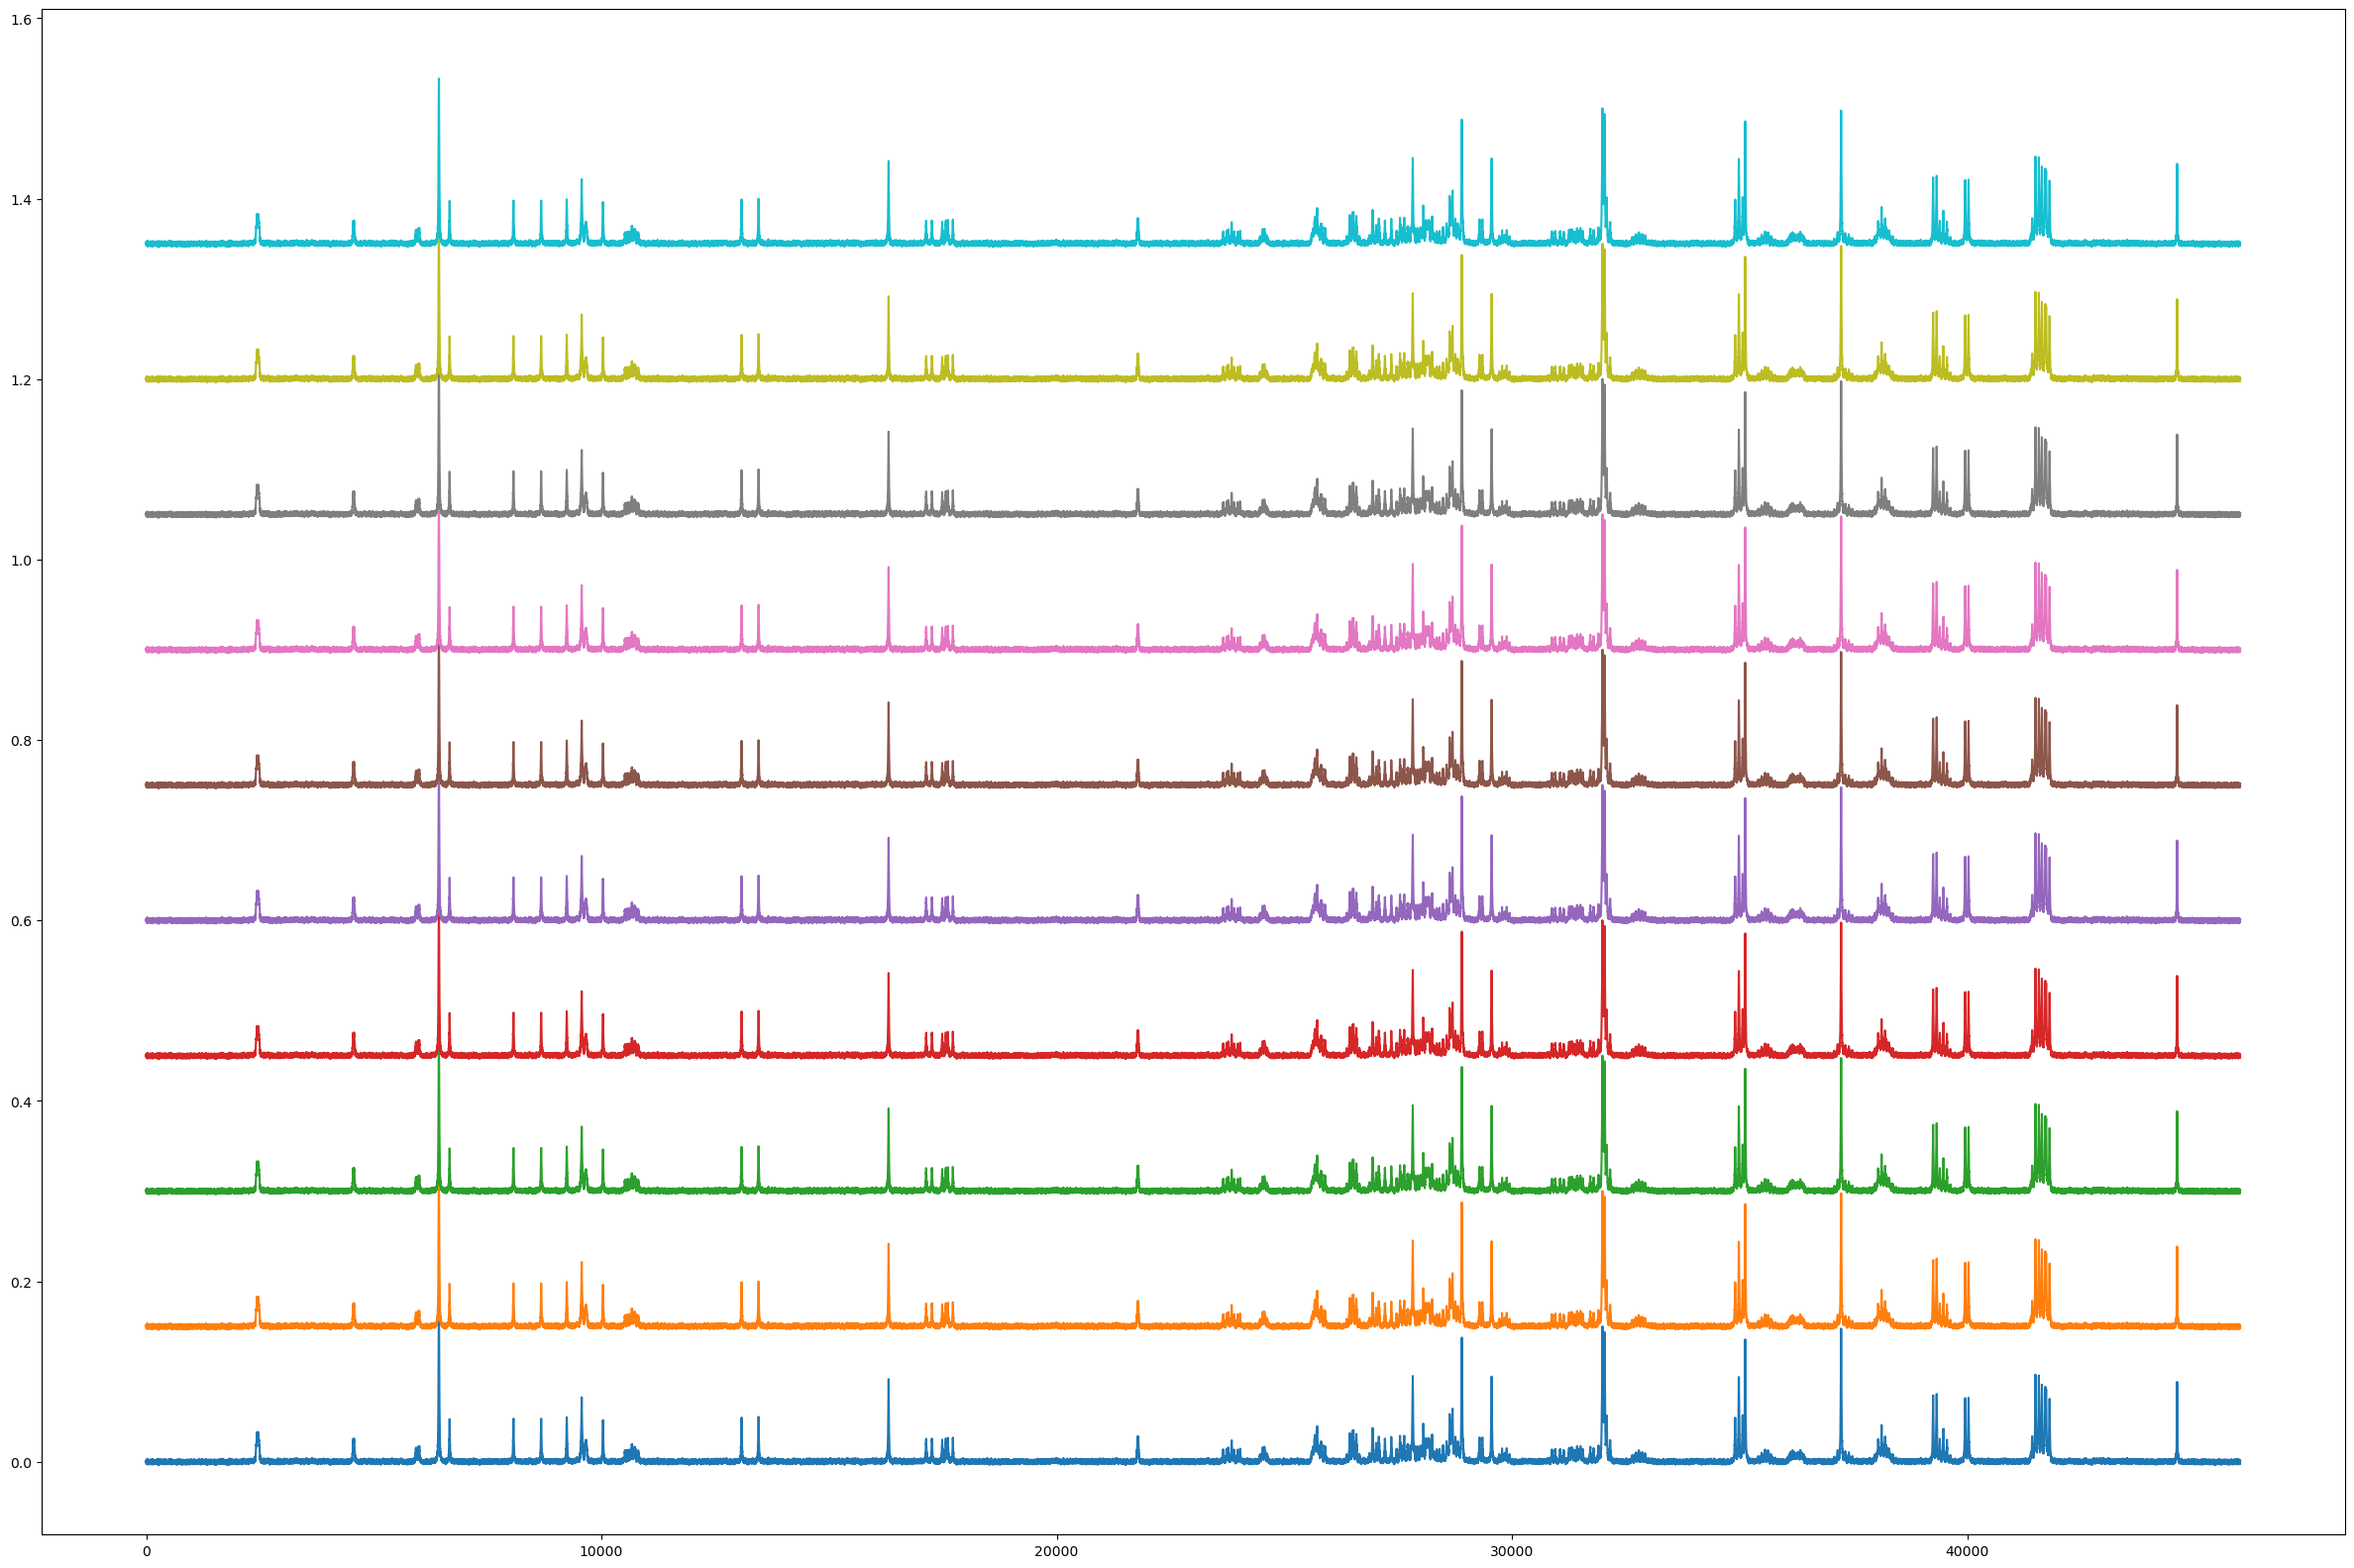

In [24]:
n = 0
for i in np.arange(10):
    plt.plot(model(zeros)[i].cpu().detach().numpy()+n)
    n += 0.15

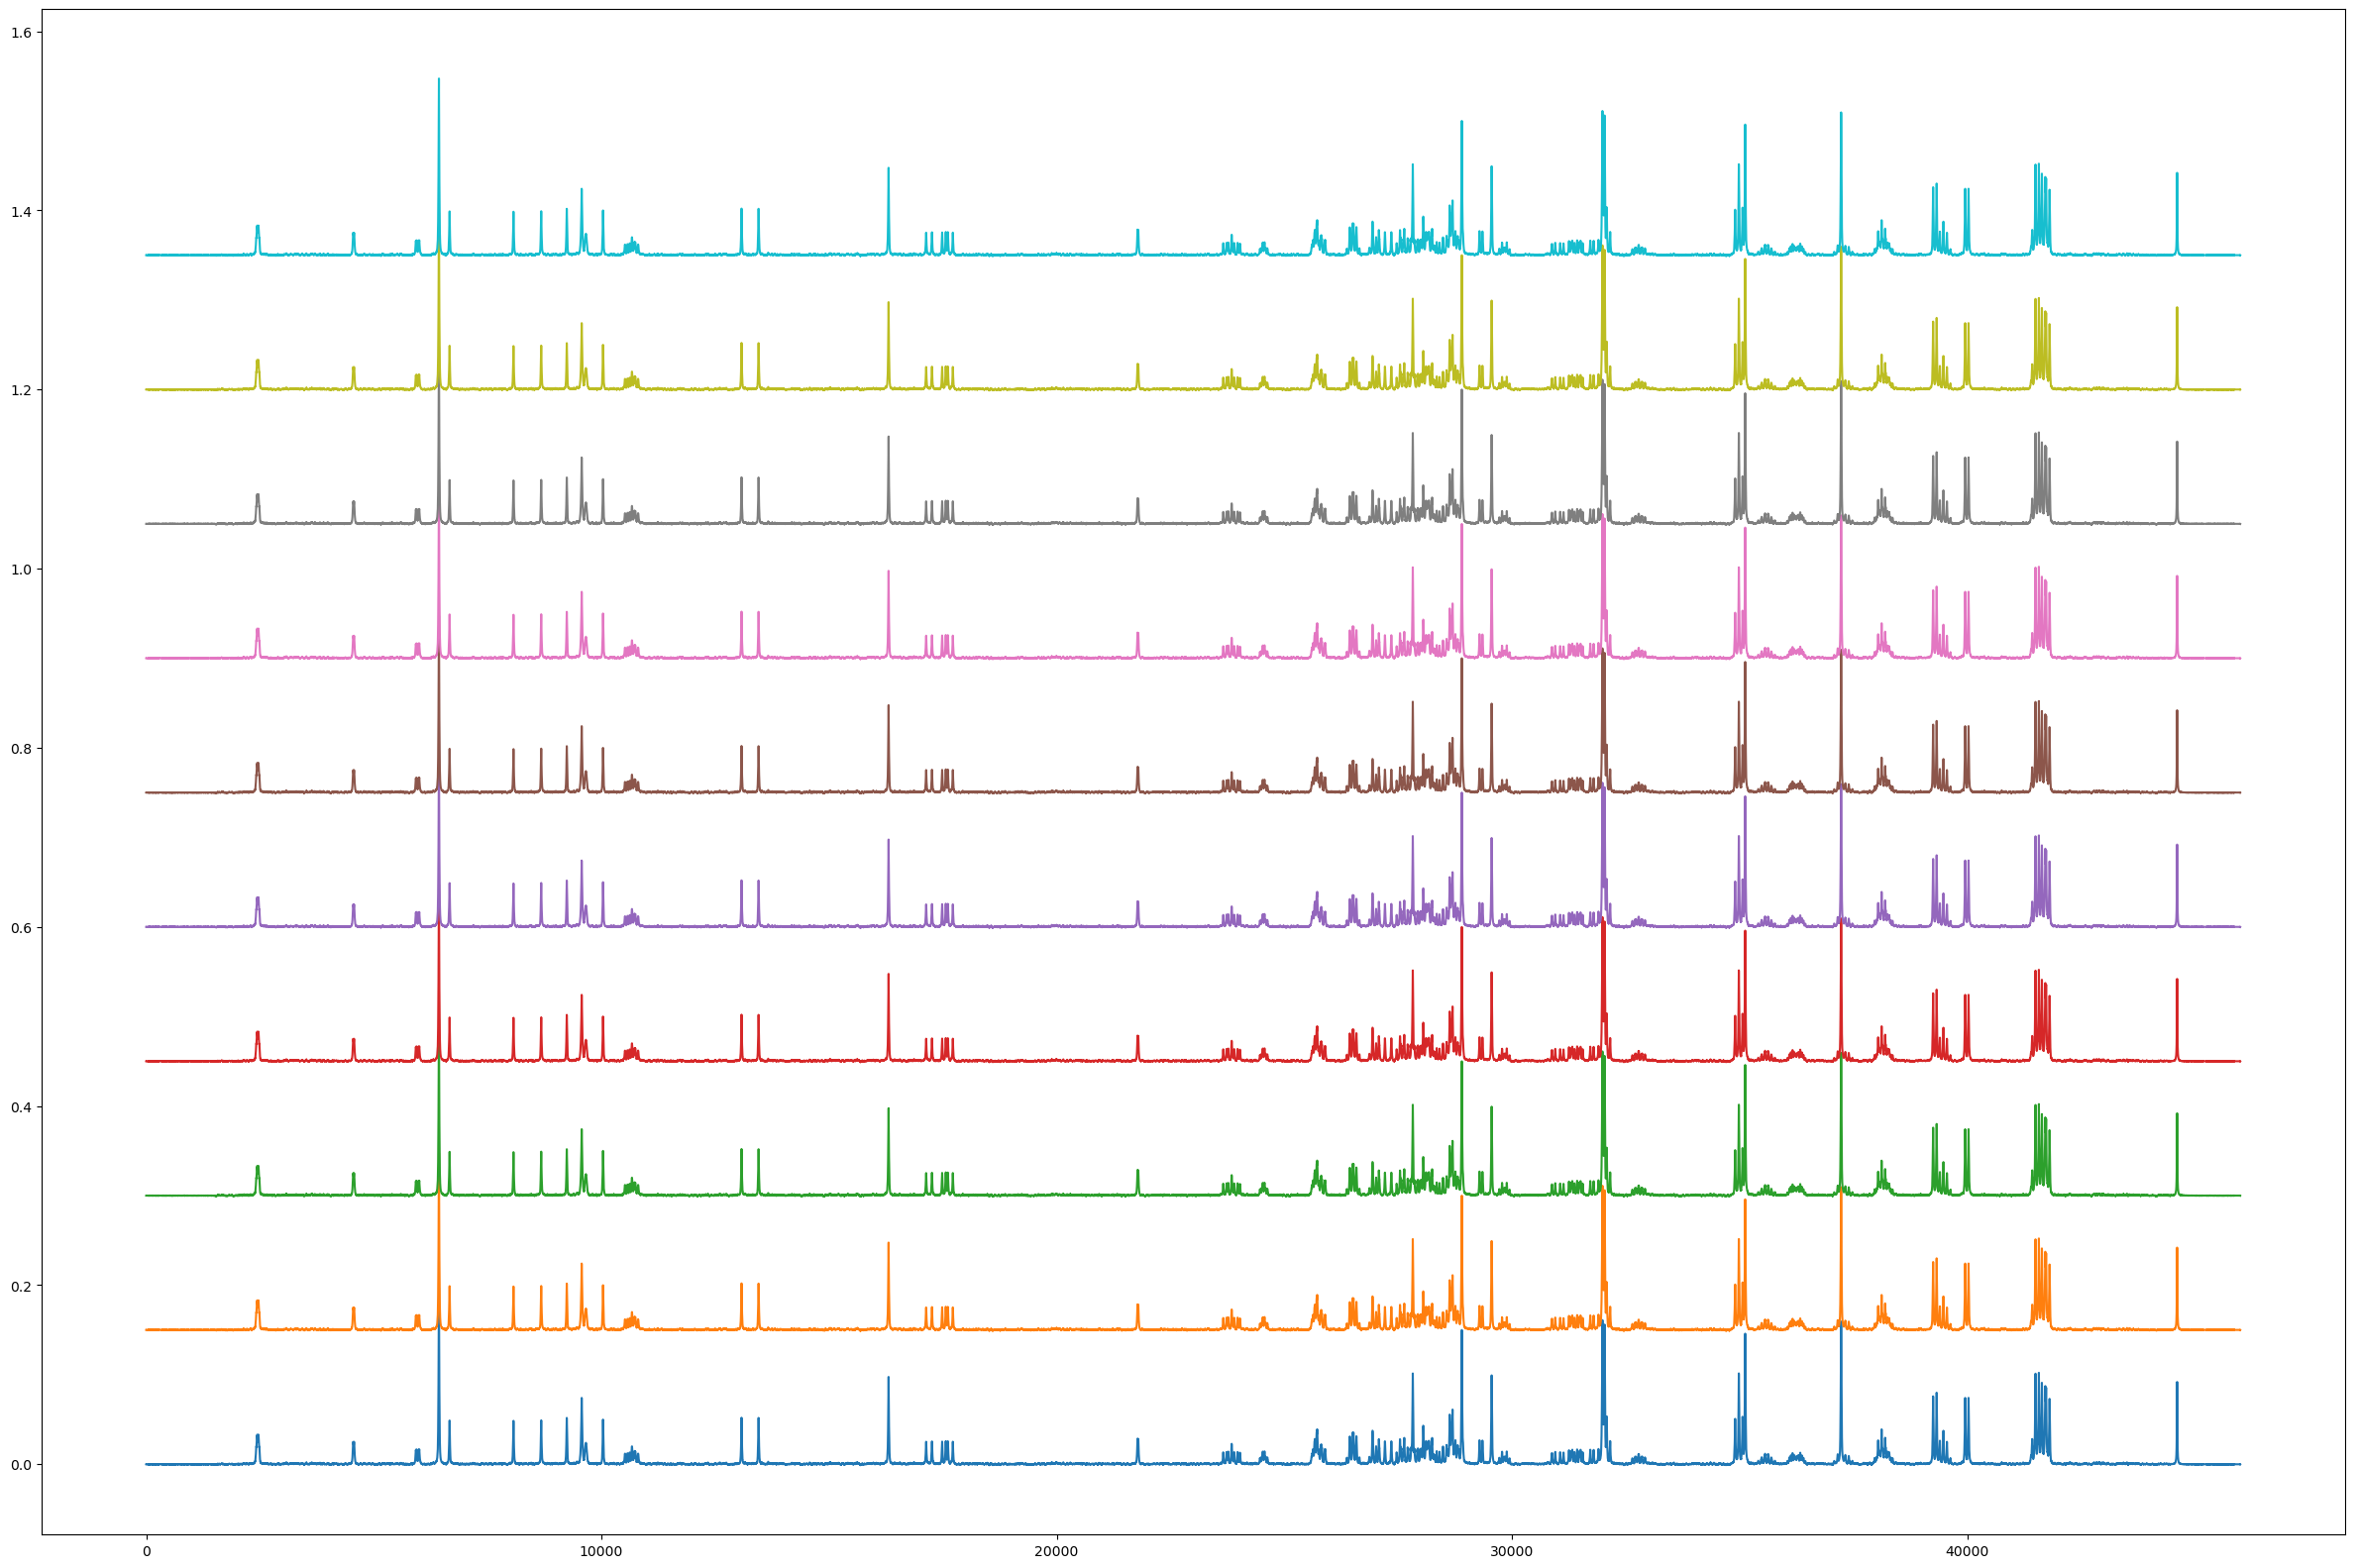

In [25]:
n = 0
for i in np.arange(10):
    plt.plot(model(LF)[i].cpu().detach().numpy()+n)
    n += 0.15

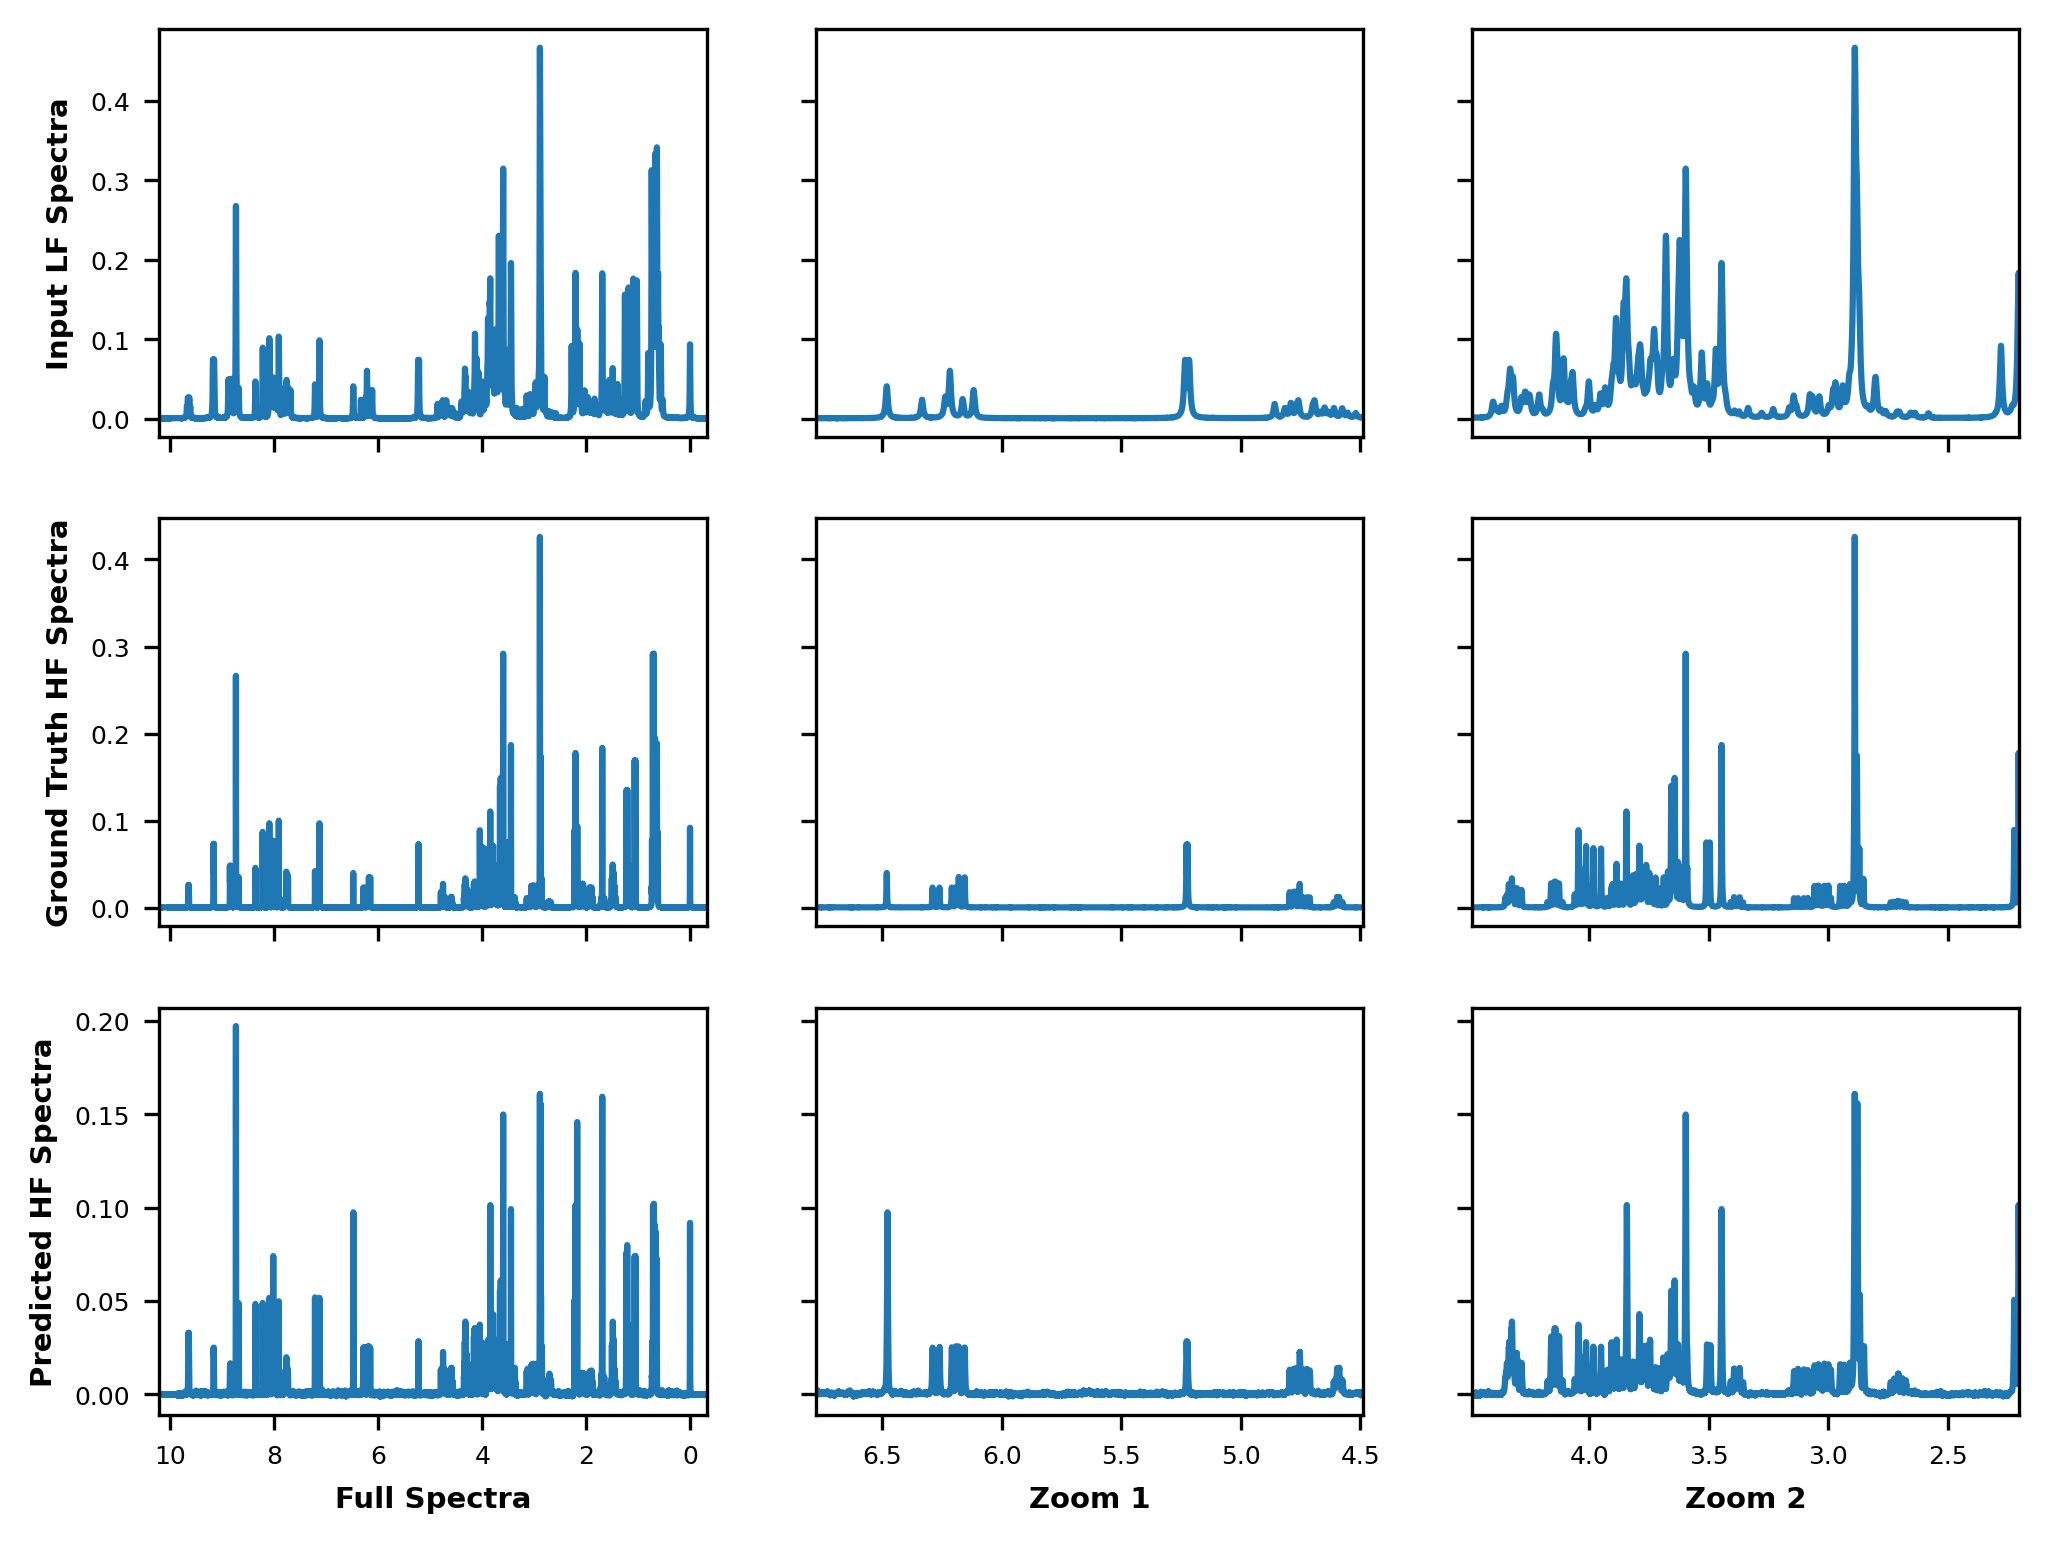

In [21]:
Predicted = model(spectraVal100[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[0],ppm[-1])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[15000],ppm[25000])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[25000],ppm[35000])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[0],ppm[-1])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[15000],ppm[25000])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[25000],ppm[35000])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(ppm, Predicted)
axs[2, 0].set_xlim(ppm[0],ppm[-1])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(ppm, Predicted)
axs[2, 1].set_xlim(ppm[15000],ppm[25000])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(ppm, Predicted)
axs[2, 2].set_xlim(ppm[25000],ppm[35000])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')

count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Full Spectra","Full Spectra","Full Spectra","Zoom 1","Zoom 1","Zoom 1","Full Spectra","Zoom 1","Zoom 2"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

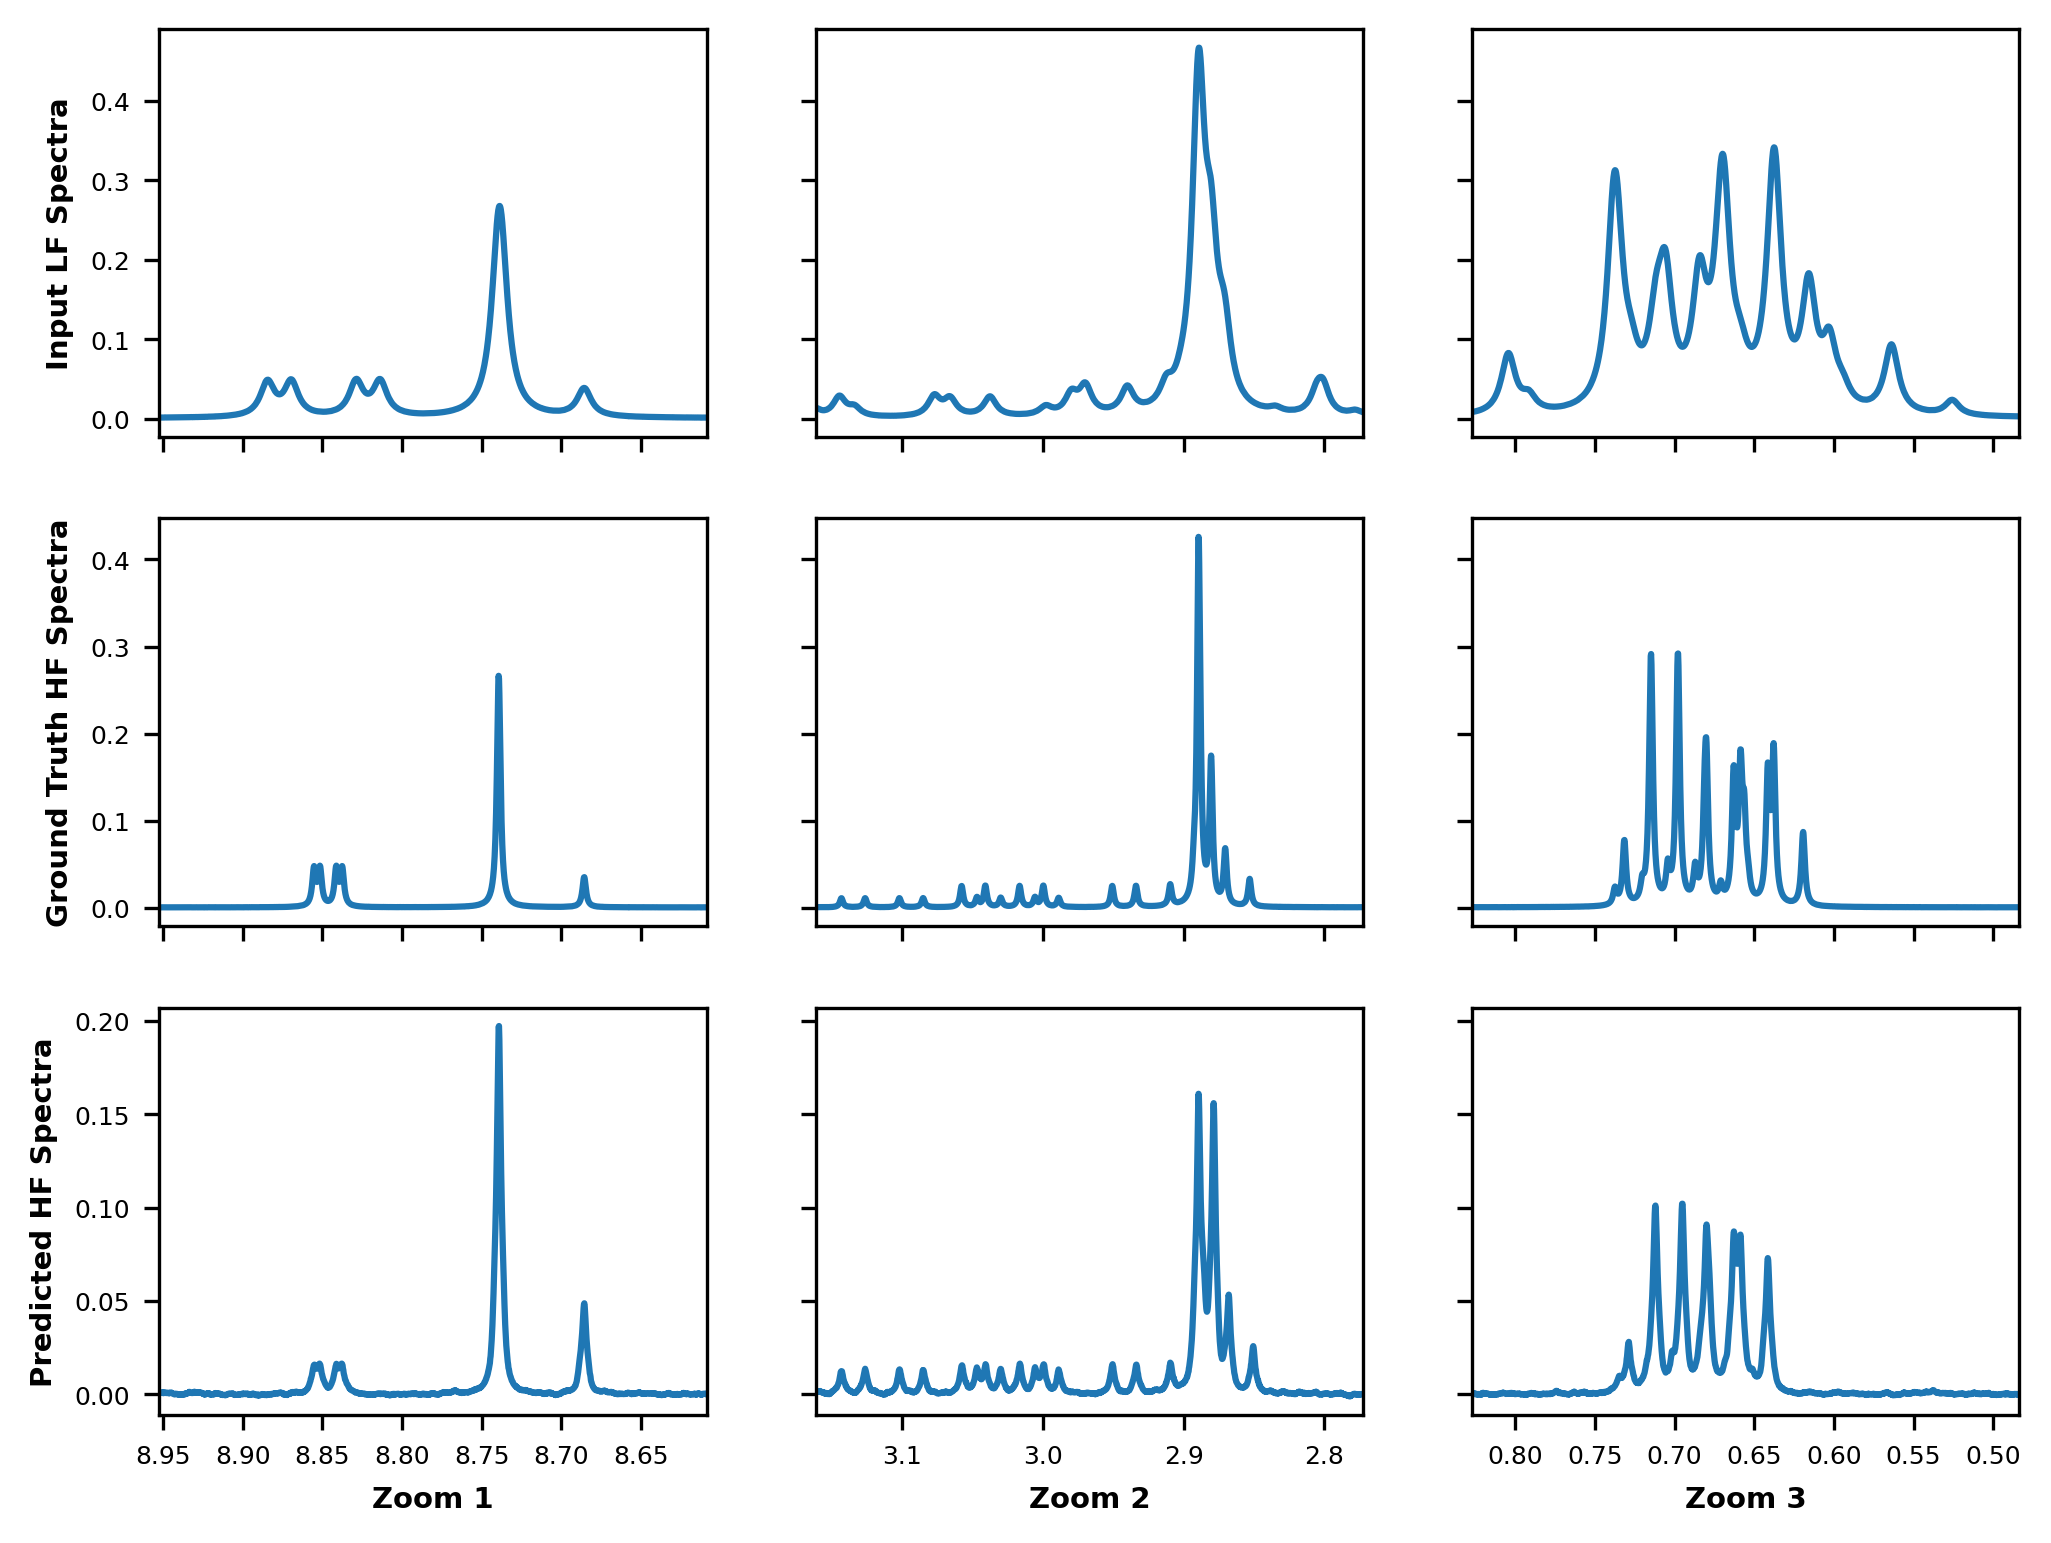

In [22]:
Predicted = model(spectraVal100[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[5500],ppm[7000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[30800],ppm[32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41000],ppm[42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[5500],ppm[7000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[30800],ppm[32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41000],ppm[42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(ppm, Predicted)
axs[2, 0].set_xlim(ppm[5500],ppm[7000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(ppm, Predicted)
axs[2, 1].set_xlim(ppm[30800],ppm[32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(ppm, Predicted)
axs[2, 2].set_xlim(ppm[41000],ppm[42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Full Spectra","Full Spectra","Full Spectra","Zoom 1","Zoom 1","Zoom 1","Zoom 1","Zoom 2","Zoom 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

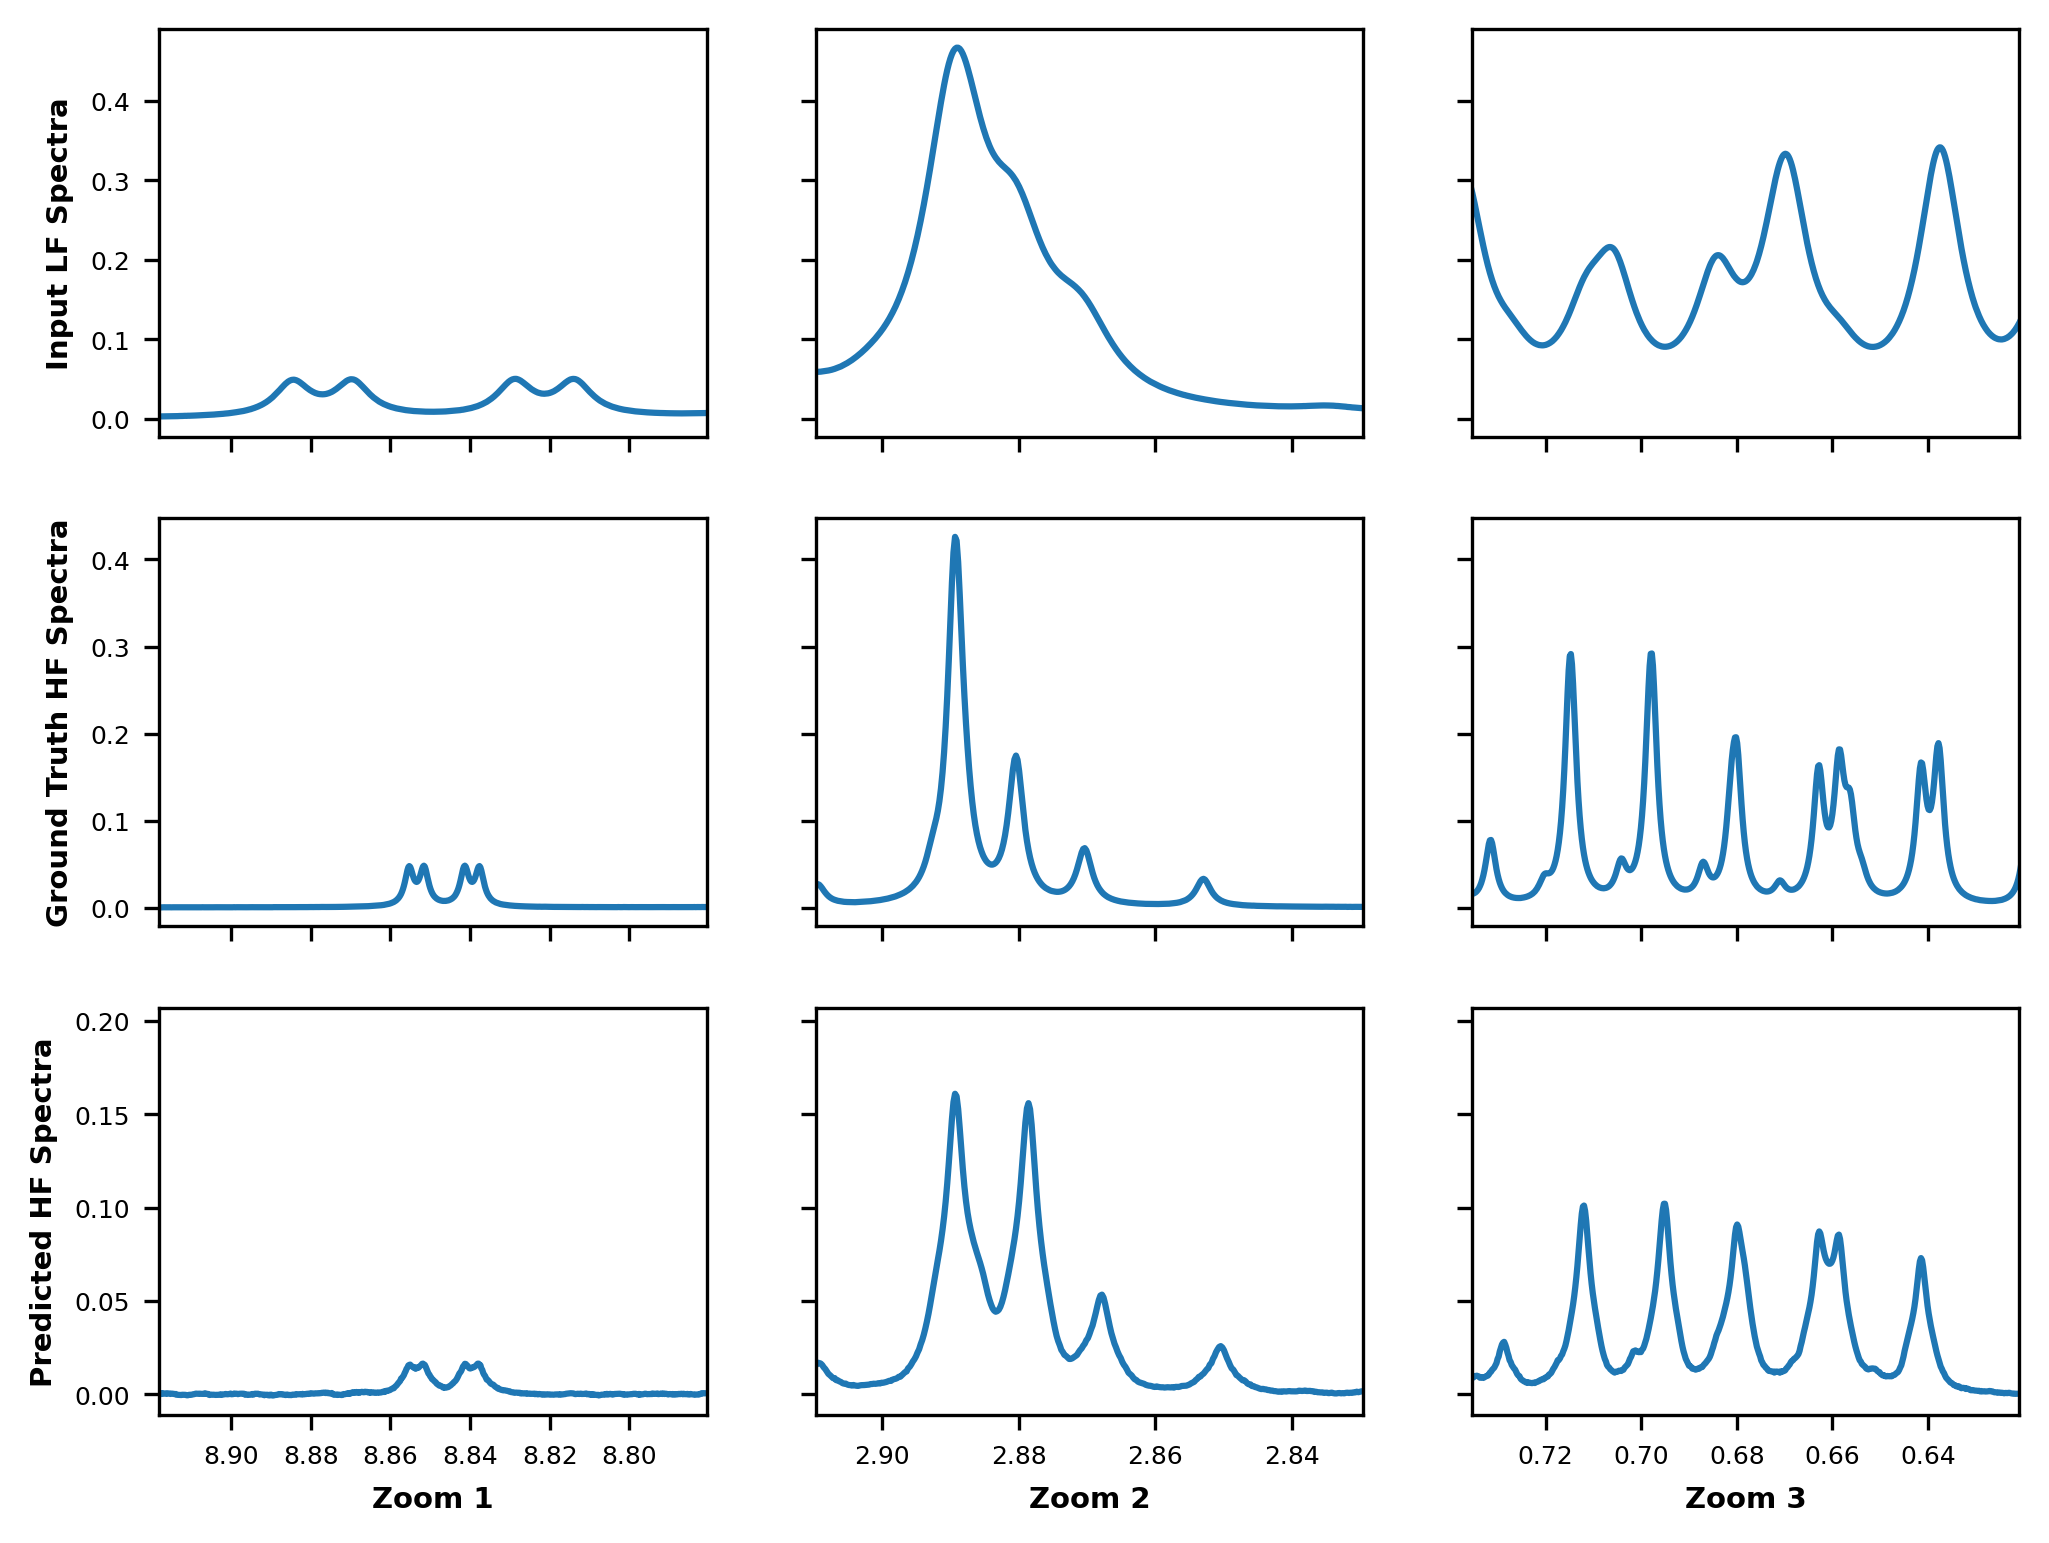

In [23]:
Predicted = model(spectraVal100[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[5650],ppm[6250])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[31900],ppm[32250])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41400],ppm[41900])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[5650],ppm[6250])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[31900],ppm[32250])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41400],ppm[41900])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(ppm, Predicted)
axs[2, 0].set_xlim(ppm[5650],ppm[6250])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(ppm, Predicted)
axs[2, 1].set_xlim(ppm[31900],ppm[32250])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(ppm, Predicted)
axs[2, 2].set_xlim(ppm[41400],ppm[41900])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Full Spectra","Full Spectra","Full Spectra","Zoom 1","Zoom 1","Zoom 1","Zoom 1","Zoom 2","Zoom 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')